# Receiver Function

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/receiver_function/receiver_function.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Receiver functions are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

We refer you to the paper below for description of the algorithms and the forward kernel we use:

*Genetic algorithm inversion for receiver functions with application to crust and uppermost mantle structure beneath Eastern Australia*,
Shibutani, T., Kennett, B. and Sambridge, M., Geophys. Res. Lett., 23 , No. 4, 1829-1832, 1996.

In this notebook, we run inversion on a toy model with optimisation and parallel sampling.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import arviz
import emcee
import multiprocessing

import cofi
import espresso

In [3]:
# randomness is used to initialise emcee walkers starting points
np.random.seed(42)

We are going to use the receiver function kernel wrapped in 
[`espresso`](https://geo-espresso.readthedocs.io/en/latest/user_guide/contrib/generated/_receiver_function/index.html),
with calls to Fortran routines developed by Takuo Shibutani in the backend.

In [4]:
my_receiver_function = espresso.ReceiverFunctionInversion(example_number=4)

Consider a model setup of `n` layers described with 3 parameters for each layer. `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.

In this example, we fix the ratio of S-wave speed to P-wave speed, and treat the interface depths and velocities of 5 layers as unknowns.

In order to better understand the complexity and non-linear nature of seismic receiver function inversion, we have included a few illustrative animations. These animations highlight the substantial influence of velocities and, more prominently, interface depths on the resulting receiver functions.

![depth_layer3_anim4.gif](https://github.com/inlab-geo/cofi-examples/blob/main/examples/receiver_function/depth_layer3_anim4.gif?raw=true)

![vel_layer3_anim4_400f.gif](https://github.com/inlab-geo/cofi-examples/blob/main/examples/receiver_function/vel_layer3_anim4_400f.gif?raw=true)

This is a non-linear problem which can be highly sensitive to the starting model. 

![3Dsurf_x40y10_v55_l270_35](https://github.com/inlab-geo/cofi-examples/blob/main/examples/receiver_function/3Dsurf_x40y10_v55_l270_35.png?raw=true)

Here we set a starting model that is reasonably close to the true model, so that the optimisation converges.

In [5]:
null_model = my_receiver_function.starting_model 

print(f"Number of model parameters in this example: {null_model.size}")
my_receiver_function._model_setup(null_model)

Number of model parameters in this example: 6


array([[ 9. ,  4. ,  1.7],
       [20. ,  5. ,  1.7],
       [50. ,  6. ,  1.7]])

Let's plot the starting Earth model.

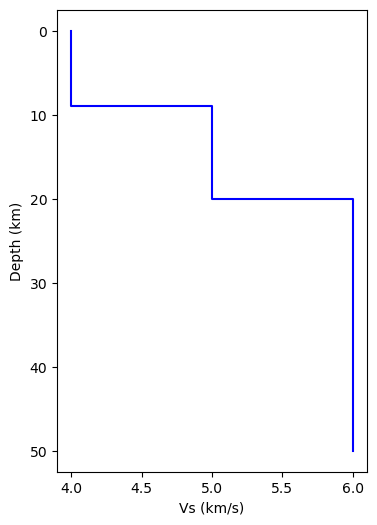

In [6]:
my_receiver_function.plot_model(null_model);

Now we calculate the receiver function and plot it

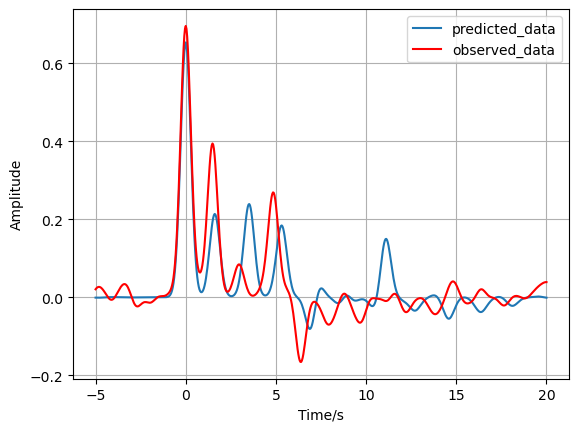

In [7]:
predicted_data = my_receiver_function.forward(null_model)
observed_data = my_receiver_function.data 
my_receiver_function.plot_data(
    data1=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 1. Solve with an optimiser

### 1.1 Define BaseProblem

In [8]:
my_problem = cofi.BaseProblem()

In preparation for optimisation:

In [9]:
def my_misfit(model, include_uncertainty=False):
    predicted_data = my_receiver_function.forward(model)
    misfit_val = my_receiver_function.misfit(predicted_data, observed_data)
    if math.isnan(misfit_val):
        return float("inf")
    return misfit_val

my_problem.set_objective(my_misfit)
my_problem.set_initial_model(null_model)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: (6,)
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
-- none --
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'blobs_dtype', 'bounds', 'constraints']


### 1.2 Define InversionOptions

In [10]:
my_options_optimiser = cofi.InversionOptions()
my_options_optimiser.set_tool("scipy.optimize.minimize")
my_options_optimiser.set_params(method="Nelder-Mead")   # Nelder-Mead or COBYLA

### 1.3 Define Inversion and run

In [11]:
inv_optimiser = cofi.Inversion(my_problem, my_options_optimiser)
my_result_optimiser = inv_optimiser.run()
my_result_optimiser.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 301.19245161163974
nit: 211
nfev: 397
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[ 8.02101741,  4.19843042, 19.98401074,  5.90087326, 44.20330568,
         6.05428975],
       [ 8.02101764,  4.19843037, 19.98400997,  5.90087314, 44.20330475,
         6.05428977],
       [ 8.02101729,  4.19843042, 19.98401081,  5.90087328, 44.20330519,
         6.05428984],
       [ 8.02101779,  4.19843041, 19.98401   ,  5.90087309, 44.20330718,
         6.05428977],
       [ 8.02101745,  4.19843041, 19.9840104 ,  5.90087321, 44.20330976,
         6.05428987],
       [ 8.02101734,  4.19843047, 19.98401115,  5.9008733 , 44.20330716,
         6.05428985],
       [ 8.02101758,  4.19843039, 19.98401021,  5.90087315, 44.20330457,
         6.05428978]]), array([301.19245161, 301.19245161, 301.19245161, 301.19245161,
       301.19245161, 301.19245161, 301.19245161]))
model: [ 8.02101741  4.19843042 19.98

In [12]:
print("Inversion result:    ", my_result_optimiser.model)
print("Reference good model:", my_receiver_function.good_model)

Inversion result:     [ 8.02101741  4.19843042 19.98401074  5.90087326 44.20330568  6.05428975]
Reference good model: [ 8.   4.2 20.   6.  45.   6.2]


### 1.4 Plotting

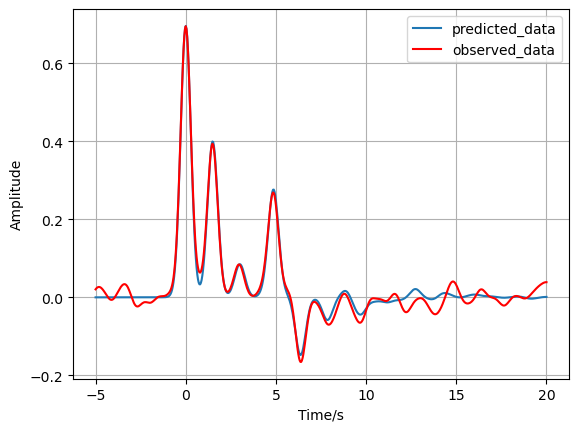

In [13]:
predicted_data = my_receiver_function.forward(my_result_optimiser.model)
my_receiver_function.plot_data(
    data1=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 2. Solve with a sampler

### 2.1 Enrich BaseProblem

In preparation for sampling:

In [14]:
def my_log_likelihood(model):
    data1 = my_receiver_function.data
    data2 = my_receiver_function.forward(model)
    log_likelihood = my_receiver_function.log_likelihood(data1, data2) / 20 # temper the likelihood
    return log_likelihood

def my_log_prior(model):
    log_prior = my_receiver_function.log_prior(model)
    return log_prior

ndim = my_receiver_function.model_size

my_problem.set_model_shape(ndim)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_log_prior(my_log_prior)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: 6
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'log_likelihood', 'log_prior', 'initial_model', 'model_shape', 'blobs_dtype']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['log_posterior', 'log_posterior_with_blobs']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'bounds', 'constraints']


In [15]:
nwalkers = 12
nsteps = 25000
walkers_start = my_result_optimiser.model + 1e-1 * np.random.randn(nwalkers, ndim)

We can run `emcee` in parallel. Some additional preparation:

### 2.2 Define InversionOptions, Inversion and run

In [16]:
import warnings
warnings.filterwarnings("ignore")

my_options_sampler = cofi.InversionOptions()
my_options_sampler.set_tool("emcee")
my_options_sampler.set_params(
    nwalkers=nwalkers,
    nsteps=nsteps,
    initial_state=walkers_start,
    progress=True,
)
inv_sampler = cofi.Inversion(my_problem, my_options_sampler)
inv_result_sampler = inv_sampler.run()


  0%|                                                                                                                                                                                  | 0/25000 [00:00<?, ?it/s]


  0%|                                                                                                                                                                          | 8/25000 [00:00<05:35, 74.56it/s]


  0%|                                                                                                                                                                         | 16/25000 [00:00<05:33, 75.00it/s]


  0%|▏                                                                                                                                                                        | 24/25000 [00:00<05:34, 74.75it/s]


  0%|▏                                                                                                                                                                        | 32/25000 [00:00<05:34, 74.59it/s]


  0%|▎                                                                                                                                                                        | 40/25000 [00:00<05:34, 74.54it/s]


  0%|▎                                                                                                                                                                        | 48/25000 [00:00<05:34, 74.55it/s]


  0%|▍                                                                                                                                                                        | 56/25000 [00:00<05:39, 73.42it/s]


  0%|▍                                                                                                                                                                        | 64/25000 [00:00<05:37, 73.79it/s]


  0%|▍                                                                                                                                                                        | 72/25000 [00:00<05:36, 74.05it/s]


  0%|▌                                                                                                                                                                        | 80/25000 [00:01<05:35, 74.20it/s]


  0%|▌                                                                                                                                                                        | 88/25000 [00:01<05:35, 74.36it/s]


  0%|▋                                                                                                                                                                        | 96/25000 [00:01<05:34, 74.47it/s]


  0%|▋                                                                                                                                                                       | 104/25000 [00:01<05:34, 74.53it/s]


  0%|▊                                                                                                                                                                       | 112/25000 [00:01<05:33, 74.57it/s]


  0%|▊                                                                                                                                                                       | 120/25000 [00:01<05:33, 74.61it/s]


  1%|▊                                                                                                                                                                       | 128/25000 [00:01<05:33, 74.66it/s]


  1%|▉                                                                                                                                                                       | 136/25000 [00:01<05:32, 74.68it/s]


  1%|▉                                                                                                                                                                       | 144/25000 [00:01<05:32, 74.70it/s]


  1%|█                                                                                                                                                                       | 152/25000 [00:02<05:32, 74.72it/s]


  1%|█                                                                                                                                                                       | 160/25000 [00:02<05:32, 74.74it/s]


  1%|█▏                                                                                                                                                                      | 168/25000 [00:02<05:39, 73.16it/s]


  1%|█▏                                                                                                                                                                      | 176/25000 [00:02<05:37, 73.62it/s]


  1%|█▏                                                                                                                                                                      | 184/25000 [00:02<05:35, 73.94it/s]


  1%|█▎                                                                                                                                                                      | 192/25000 [00:02<05:34, 74.19it/s]


  1%|█▎                                                                                                                                                                      | 200/25000 [00:02<05:33, 74.40it/s]


  1%|█▍                                                                                                                                                                      | 208/25000 [00:02<05:32, 74.51it/s]


  1%|█▍                                                                                                                                                                      | 216/25000 [00:02<05:32, 74.58it/s]


  1%|█▌                                                                                                                                                                      | 224/25000 [00:03<05:31, 74.64it/s]


  1%|█▌                                                                                                                                                                      | 232/25000 [00:03<05:31, 74.69it/s]


  1%|█▌                                                                                                                                                                      | 240/25000 [00:03<06:15, 65.90it/s]


  1%|█▋                                                                                                                                                                      | 247/25000 [00:03<06:54, 59.79it/s]


  1%|█▋                                                                                                                                                                      | 255/25000 [00:03<06:29, 63.61it/s]


  1%|█▊                                                                                                                                                                      | 263/25000 [00:03<06:11, 66.62it/s]


  1%|█▊                                                                                                                                                                      | 271/25000 [00:03<06:03, 68.01it/s]


  1%|█▊                                                                                                                                                                      | 279/25000 [00:03<05:54, 69.69it/s]


  1%|█▉                                                                                                                                                                      | 287/25000 [00:03<05:47, 71.12it/s]


  1%|█▉                                                                                                                                                                      | 295/25000 [00:04<05:39, 72.75it/s]


  1%|██                                                                                                                                                                      | 303/25000 [00:04<05:33, 74.14it/s]


  1%|██                                                                                                                                                                      | 311/25000 [00:04<05:29, 74.93it/s]


  1%|██▏                                                                                                                                                                     | 319/25000 [00:04<05:27, 75.41it/s]


  1%|██▏                                                                                                                                                                     | 327/25000 [00:04<05:23, 76.26it/s]


  1%|██▎                                                                                                                                                                     | 335/25000 [00:04<05:21, 76.65it/s]


  1%|██▎                                                                                                                                                                     | 344/25000 [00:04<05:16, 77.99it/s]


  1%|██▎                                                                                                                                                                     | 352/25000 [00:04<05:18, 77.42it/s]


  1%|██▍                                                                                                                                                                     | 360/25000 [00:04<05:21, 76.57it/s]


  1%|██▍                                                                                                                                                                     | 368/25000 [00:05<05:21, 76.66it/s]


  2%|██▌                                                                                                                                                                     | 376/25000 [00:05<05:22, 76.28it/s]


  2%|██▌                                                                                                                                                                     | 384/25000 [00:05<05:20, 76.90it/s]


  2%|██▋                                                                                                                                                                     | 392/25000 [00:05<05:20, 76.88it/s]


  2%|██▋                                                                                                                                                                     | 400/25000 [00:05<05:17, 77.56it/s]


  2%|██▋                                                                                                                                                                     | 408/25000 [00:05<05:16, 77.81it/s]


  2%|██▊                                                                                                                                                                     | 416/25000 [00:05<05:19, 76.85it/s]


  2%|██▊                                                                                                                                                                     | 424/25000 [00:05<05:21, 76.43it/s]


  2%|██▉                                                                                                                                                                     | 432/25000 [00:05<05:23, 75.87it/s]


  2%|██▉                                                                                                                                                                     | 440/25000 [00:05<05:22, 76.19it/s]


  2%|███                                                                                                                                                                     | 448/25000 [00:06<05:23, 75.94it/s]


  2%|███                                                                                                                                                                     | 456/25000 [00:06<05:23, 75.98it/s]


  2%|███                                                                                                                                                                     | 464/25000 [00:06<05:22, 76.13it/s]


  2%|███▏                                                                                                                                                                    | 472/25000 [00:06<05:22, 76.01it/s]


  2%|███▏                                                                                                                                                                    | 480/25000 [00:06<05:24, 75.61it/s]


  2%|███▎                                                                                                                                                                    | 488/25000 [00:06<05:25, 75.29it/s]


  2%|███▎                                                                                                                                                                    | 496/25000 [00:06<05:30, 74.10it/s]


  2%|███▍                                                                                                                                                                    | 504/25000 [00:06<05:29, 74.25it/s]


  2%|███▍                                                                                                                                                                    | 512/25000 [00:06<05:29, 74.36it/s]


  2%|███▍                                                                                                                                                                    | 520/25000 [00:07<05:28, 74.47it/s]


  2%|███▌                                                                                                                                                                    | 528/25000 [00:07<05:28, 74.53it/s]


  2%|███▌                                                                                                                                                                    | 536/25000 [00:07<05:28, 74.54it/s]


  2%|███▋                                                                                                                                                                    | 544/25000 [00:07<05:27, 74.58it/s]


  2%|███▋                                                                                                                                                                    | 552/25000 [00:07<05:27, 74.62it/s]


  2%|███▊                                                                                                                                                                    | 560/25000 [00:07<05:27, 74.52it/s]


  2%|███▊                                                                                                                                                                    | 568/25000 [00:07<05:27, 74.58it/s]


  2%|███▊                                                                                                                                                                    | 576/25000 [00:07<05:27, 74.65it/s]


  2%|███▉                                                                                                                                                                    | 584/25000 [00:07<05:27, 74.66it/s]


  2%|███▉                                                                                                                                                                    | 592/25000 [00:07<05:26, 74.67it/s]


  2%|████                                                                                                                                                                    | 600/25000 [00:08<05:26, 74.64it/s]


  2%|████                                                                                                                                                                    | 608/25000 [00:08<05:27, 74.52it/s]


  2%|████▏                                                                                                                                                                   | 616/25000 [00:08<05:27, 74.47it/s]


  2%|████▏                                                                                                                                                                   | 624/25000 [00:08<05:28, 74.15it/s]


  3%|████▏                                                                                                                                                                   | 632/25000 [00:08<05:27, 74.34it/s]


  3%|████▎                                                                                                                                                                   | 640/25000 [00:08<05:27, 74.43it/s]


  3%|████▎                                                                                                                                                                   | 648/25000 [00:08<05:26, 74.55it/s]


  3%|████▍                                                                                                                                                                   | 656/25000 [00:08<05:28, 74.07it/s]


  3%|████▍                                                                                                                                                                   | 664/25000 [00:08<05:27, 74.29it/s]


  3%|████▌                                                                                                                                                                   | 672/25000 [00:09<05:26, 74.41it/s]


  3%|████▌                                                                                                                                                                   | 680/25000 [00:09<05:26, 74.52it/s]


  3%|████▌                                                                                                                                                                   | 688/25000 [00:09<05:25, 74.58it/s]


  3%|████▋                                                                                                                                                                   | 696/25000 [00:09<05:22, 75.28it/s]


  3%|████▋                                                                                                                                                                   | 704/25000 [00:09<05:23, 75.13it/s]


  3%|████▊                                                                                                                                                                   | 712/25000 [00:09<05:21, 75.45it/s]


  3%|████▊                                                                                                                                                                   | 720/25000 [00:09<05:22, 75.26it/s]


  3%|████▉                                                                                                                                                                   | 728/25000 [00:09<05:18, 76.25it/s]


  3%|████▉                                                                                                                                                                   | 737/25000 [00:09<05:12, 77.54it/s]


  3%|█████                                                                                                                                                                   | 746/25000 [00:10<05:02, 80.22it/s]


  3%|█████                                                                                                                                                                   | 755/25000 [00:10<04:58, 81.20it/s]


  3%|█████▏                                                                                                                                                                  | 764/25000 [00:10<04:51, 83.13it/s]


  3%|█████▏                                                                                                                                                                  | 773/25000 [00:10<04:46, 84.48it/s]


  3%|█████▎                                                                                                                                                                  | 782/25000 [00:10<04:43, 85.46it/s]


  3%|█████▎                                                                                                                                                                  | 793/25000 [00:10<04:27, 90.42it/s]


  3%|█████▍                                                                                                                                                                  | 803/25000 [00:10<04:31, 89.13it/s]


  3%|█████▍                                                                                                                                                                  | 813/25000 [00:10<04:30, 89.49it/s]


  3%|█████▌                                                                                                                                                                  | 822/25000 [00:10<04:31, 88.98it/s]


  3%|█████▌                                                                                                                                                                  | 831/25000 [00:10<04:34, 88.06it/s]


  3%|█████▋                                                                                                                                                                  | 840/25000 [00:11<04:33, 88.24it/s]


  3%|█████▋                                                                                                                                                                  | 849/25000 [00:11<04:34, 88.13it/s]


  3%|█████▊                                                                                                                                                                  | 858/25000 [00:11<04:39, 86.49it/s]


  3%|█████▊                                                                                                                                                                  | 867/25000 [00:11<04:37, 86.88it/s]


  4%|█████▉                                                                                                                                                                  | 876/25000 [00:11<04:41, 85.58it/s]


  4%|█████▉                                                                                                                                                                  | 886/25000 [00:11<04:33, 88.10it/s]


  4%|██████                                                                                                                                                                  | 895/25000 [00:11<04:32, 88.57it/s]


  4%|██████                                                                                                                                                                  | 904/25000 [00:11<04:39, 86.26it/s]


  4%|██████▏                                                                                                                                                                 | 913/25000 [00:11<04:38, 86.42it/s]


  4%|██████▏                                                                                                                                                                 | 922/25000 [00:12<04:37, 86.80it/s]


  4%|██████▎                                                                                                                                                                 | 932/25000 [00:12<04:32, 88.44it/s]


  4%|██████▎                                                                                                                                                                 | 941/25000 [00:12<04:33, 88.03it/s]


  4%|██████▍                                                                                                                                                                 | 950/25000 [00:12<04:32, 88.14it/s]


  4%|██████▍                                                                                                                                                                 | 960/25000 [00:12<04:29, 89.31it/s]


  4%|██████▌                                                                                                                                                                 | 970/25000 [00:12<04:24, 90.72it/s]


  4%|██████▌                                                                                                                                                                 | 980/25000 [00:12<04:23, 91.14it/s]


  4%|██████▋                                                                                                                                                                 | 990/25000 [00:12<04:33, 87.88it/s]


  4%|██████▋                                                                                                                                                                | 1000/25000 [00:12<04:30, 88.63it/s]


  4%|██████▋                                                                                                                                                                | 1009/25000 [00:12<04:33, 87.63it/s]


  4%|██████▊                                                                                                                                                                | 1018/25000 [00:13<04:32, 87.91it/s]


  4%|██████▊                                                                                                                                                                | 1028/25000 [00:13<04:27, 89.71it/s]


  4%|██████▉                                                                                                                                                                | 1037/25000 [00:13<04:29, 89.06it/s]


  4%|██████▉                                                                                                                                                                | 1046/25000 [00:13<04:29, 88.87it/s]


  4%|███████                                                                                                                                                                | 1055/25000 [00:13<04:34, 87.10it/s]


  4%|███████                                                                                                                                                                | 1064/25000 [00:13<04:35, 86.95it/s]


  4%|███████▏                                                                                                                                                               | 1074/25000 [00:13<04:28, 89.07it/s]


  4%|███████▏                                                                                                                                                               | 1084/25000 [00:13<04:26, 89.77it/s]


  4%|███████▎                                                                                                                                                               | 1094/25000 [00:13<04:25, 90.17it/s]


  4%|███████▎                                                                                                                                                               | 1104/25000 [00:14<04:29, 88.62it/s]


  4%|███████▍                                                                                                                                                               | 1114/25000 [00:14<04:28, 88.80it/s]


  4%|███████▌                                                                                                                                                               | 1124/25000 [00:14<04:21, 91.16it/s]


  5%|███████▌                                                                                                                                                               | 1134/25000 [00:14<04:16, 93.20it/s]


  5%|███████▋                                                                                                                                                               | 1144/25000 [00:14<04:17, 92.74it/s]


  5%|███████▋                                                                                                                                                               | 1155/25000 [00:14<04:11, 94.80it/s]


  5%|███████▊                                                                                                                                                               | 1165/25000 [00:14<04:50, 82.16it/s]


  5%|███████▊                                                                                                                                                               | 1175/25000 [00:14<04:39, 85.23it/s]


  5%|███████▉                                                                                                                                                               | 1184/25000 [00:14<04:43, 84.00it/s]


  5%|███████▉                                                                                                                                                               | 1193/25000 [00:15<04:42, 84.24it/s]


  5%|████████                                                                                                                                                               | 1202/25000 [00:15<04:42, 84.18it/s]


  5%|████████                                                                                                                                                               | 1211/25000 [00:15<04:47, 82.76it/s]


  5%|████████▏                                                                                                                                                              | 1220/25000 [00:15<04:41, 84.54it/s]


  5%|████████▏                                                                                                                                                              | 1229/25000 [00:15<04:44, 83.41it/s]


  5%|████████▎                                                                                                                                                              | 1239/25000 [00:15<04:38, 85.20it/s]


  5%|████████▎                                                                                                                                                              | 1248/25000 [00:15<04:34, 86.45it/s]


  5%|████████▍                                                                                                                                                              | 1257/25000 [00:15<04:35, 86.22it/s]


  5%|████████▍                                                                                                                                                              | 1267/25000 [00:15<04:30, 87.64it/s]


  5%|████████▌                                                                                                                                                              | 1276/25000 [00:16<04:32, 87.09it/s]


  5%|████████▌                                                                                                                                                              | 1285/25000 [00:16<04:31, 87.20it/s]


  5%|████████▋                                                                                                                                                              | 1295/25000 [00:16<04:23, 90.05it/s]


  5%|████████▋                                                                                                                                                              | 1305/25000 [00:16<04:27, 88.59it/s]


  5%|████████▊                                                                                                                                                              | 1314/25000 [00:16<04:26, 88.81it/s]


  5%|████████▊                                                                                                                                                              | 1324/25000 [00:16<04:23, 89.69it/s]


  5%|████████▉                                                                                                                                                              | 1334/25000 [00:16<04:23, 89.85it/s]


  5%|████████▉                                                                                                                                                              | 1343/25000 [00:16<04:26, 88.90it/s]


  5%|█████████                                                                                                                                                              | 1354/25000 [00:16<04:16, 92.31it/s]


  5%|█████████                                                                                                                                                              | 1365/25000 [00:17<04:06, 95.82it/s]


  6%|█████████▏                                                                                                                                                             | 1375/25000 [00:17<04:08, 94.88it/s]


  6%|█████████▎                                                                                                                                                             | 1385/25000 [00:17<04:17, 91.88it/s]


  6%|█████████▎                                                                                                                                                             | 1395/25000 [00:17<04:22, 90.07it/s]


  6%|█████████▍                                                                                                                                                             | 1405/25000 [00:17<04:27, 88.09it/s]


  6%|█████████▍                                                                                                                                                             | 1414/25000 [00:17<04:29, 87.39it/s]


  6%|█████████▌                                                                                                                                                             | 1425/25000 [00:17<04:12, 93.23it/s]


  6%|█████████▌                                                                                                                                                             | 1435/25000 [00:17<04:12, 93.33it/s]


  6%|█████████▋                                                                                                                                                             | 1445/25000 [00:17<04:18, 91.09it/s]


  6%|█████████▋                                                                                                                                                             | 1455/25000 [00:18<04:15, 92.09it/s]


  6%|█████████▊                                                                                                                                                             | 1465/25000 [00:18<04:17, 91.28it/s]


  6%|█████████▊                                                                                                                                                             | 1475/25000 [00:18<04:12, 93.04it/s]


  6%|█████████▉                                                                                                                                                             | 1485/25000 [00:18<04:08, 94.63it/s]


  6%|█████████▉                                                                                                                                                             | 1495/25000 [00:18<04:09, 94.34it/s]


  6%|██████████                                                                                                                                                             | 1505/25000 [00:18<04:05, 95.54it/s]


  6%|██████████                                                                                                                                                             | 1515/25000 [00:18<04:05, 95.53it/s]


  6%|██████████▏                                                                                                                                                            | 1525/25000 [00:18<04:10, 93.56it/s]


  6%|██████████▎                                                                                                                                                            | 1535/25000 [00:18<04:22, 89.43it/s]


  6%|██████████▎                                                                                                                                                            | 1544/25000 [00:18<04:23, 88.89it/s]


  6%|██████████▍                                                                                                                                                            | 1554/25000 [00:19<04:15, 91.81it/s]


  6%|██████████▍                                                                                                                                                            | 1564/25000 [00:19<04:12, 92.65it/s]


  6%|██████████▌                                                                                                                                                            | 1574/25000 [00:19<04:12, 92.92it/s]


  6%|██████████▌                                                                                                                                                            | 1584/25000 [00:19<04:09, 93.96it/s]


  6%|██████████▋                                                                                                                                                            | 1594/25000 [00:19<04:09, 93.88it/s]


  6%|██████████▋                                                                                                                                                            | 1604/25000 [00:19<04:13, 92.16it/s]


  6%|██████████▊                                                                                                                                                            | 1614/25000 [00:19<04:16, 91.01it/s]


  6%|██████████▊                                                                                                                                                            | 1624/25000 [00:19<04:16, 91.25it/s]


  7%|██████████▉                                                                                                                                                            | 1635/25000 [00:19<04:07, 94.22it/s]


  7%|██████████▉                                                                                                                                                            | 1645/25000 [00:20<04:11, 92.93it/s]


  7%|███████████                                                                                                                                                            | 1655/25000 [00:20<04:11, 92.86it/s]


  7%|███████████                                                                                                                                                            | 1665/25000 [00:20<04:17, 90.51it/s]


  7%|███████████▏                                                                                                                                                           | 1675/25000 [00:20<04:10, 93.04it/s]


  7%|███████████▎                                                                                                                                                           | 1685/25000 [00:20<04:09, 93.57it/s]


  7%|███████████▎                                                                                                                                                           | 1695/25000 [00:20<04:08, 93.94it/s]


  7%|███████████▍                                                                                                                                                           | 1705/25000 [00:20<04:05, 94.81it/s]


  7%|███████████▍                                                                                                                                                           | 1715/25000 [00:20<04:06, 94.30it/s]


  7%|███████████▌                                                                                                                                                           | 1725/25000 [00:20<04:10, 93.10it/s]


  7%|███████████▌                                                                                                                                                           | 1735/25000 [00:21<04:14, 91.47it/s]


  7%|███████████▋                                                                                                                                                           | 1745/25000 [00:21<04:20, 89.40it/s]


  7%|███████████▋                                                                                                                                                           | 1754/25000 [00:21<04:19, 89.45it/s]


  7%|███████████▊                                                                                                                                                           | 1763/25000 [00:21<04:24, 87.69it/s]


  7%|███████████▊                                                                                                                                                           | 1773/25000 [00:21<04:19, 89.50it/s]


  7%|███████████▉                                                                                                                                                           | 1783/25000 [00:21<04:12, 91.85it/s]


  7%|███████████▉                                                                                                                                                           | 1793/25000 [00:21<04:21, 88.75it/s]


  7%|████████████                                                                                                                                                           | 1802/25000 [00:21<04:22, 88.23it/s]


  7%|████████████                                                                                                                                                           | 1811/25000 [00:21<04:27, 86.60it/s]


  7%|████████████▏                                                                                                                                                          | 1820/25000 [00:22<04:29, 86.17it/s]


  7%|████████████▏                                                                                                                                                          | 1829/25000 [00:22<04:32, 85.11it/s]


  7%|████████████▎                                                                                                                                                          | 1838/25000 [00:22<04:36, 83.64it/s]


  7%|████████████▎                                                                                                                                                          | 1847/25000 [00:22<04:34, 84.33it/s]


  7%|████████████▍                                                                                                                                                          | 1856/25000 [00:22<04:37, 83.38it/s]


  7%|████████████▍                                                                                                                                                          | 1865/25000 [00:22<04:33, 84.62it/s]


  7%|████████████▌                                                                                                                                                          | 1874/25000 [00:22<04:30, 85.52it/s]


  8%|████████████▌                                                                                                                                                          | 1883/25000 [00:22<04:26, 86.70it/s]


  8%|████████████▋                                                                                                                                                          | 1893/25000 [00:22<04:22, 88.16it/s]


  8%|████████████▋                                                                                                                                                          | 1902/25000 [00:22<04:28, 86.03it/s]


  8%|████████████▊                                                                                                                                                          | 1911/25000 [00:23<04:29, 85.77it/s]


  8%|████████████▊                                                                                                                                                          | 1922/25000 [00:23<04:11, 91.61it/s]


  8%|████████████▉                                                                                                                                                          | 1932/25000 [00:23<04:09, 92.57it/s]


  8%|████████████▉                                                                                                                                                          | 1942/25000 [00:23<04:13, 91.09it/s]


  8%|█████████████                                                                                                                                                          | 1952/25000 [00:23<04:12, 91.13it/s]


  8%|█████████████                                                                                                                                                          | 1962/25000 [00:23<04:12, 91.41it/s]


  8%|█████████████▏                                                                                                                                                         | 1972/25000 [00:23<04:09, 92.33it/s]


  8%|█████████████▏                                                                                                                                                         | 1982/25000 [00:23<04:13, 90.64it/s]


  8%|█████████████▎                                                                                                                                                         | 1992/25000 [00:23<04:19, 88.58it/s]


  8%|█████████████▎                                                                                                                                                         | 2002/25000 [00:24<04:15, 89.91it/s]


  8%|█████████████▍                                                                                                                                                         | 2012/25000 [00:24<04:16, 89.70it/s]


  8%|█████████████▌                                                                                                                                                         | 2022/25000 [00:24<04:14, 90.27it/s]


  8%|█████████████▌                                                                                                                                                         | 2033/25000 [00:24<04:02, 94.84it/s]


  8%|█████████████▋                                                                                                                                                         | 2043/25000 [00:24<04:07, 92.59it/s]


  8%|█████████████▋                                                                                                                                                         | 2053/25000 [00:24<04:09, 91.86it/s]


  8%|█████████████▊                                                                                                                                                         | 2063/25000 [00:24<04:18, 88.82it/s]


  8%|█████████████▊                                                                                                                                                         | 2073/25000 [00:24<04:10, 91.40it/s]


  8%|█████████████▉                                                                                                                                                         | 2083/25000 [00:24<04:09, 91.75it/s]


  8%|█████████████▉                                                                                                                                                         | 2093/25000 [00:25<04:10, 91.52it/s]


  8%|██████████████                                                                                                                                                         | 2103/25000 [00:25<04:10, 91.34it/s]


  8%|██████████████                                                                                                                                                         | 2113/25000 [00:25<04:10, 91.27it/s]


  8%|██████████████▏                                                                                                                                                        | 2123/25000 [00:25<04:14, 89.90it/s]


  9%|██████████████▏                                                                                                                                                        | 2133/25000 [00:25<04:18, 88.46it/s]


  9%|██████████████▎                                                                                                                                                        | 2142/25000 [00:25<04:21, 87.43it/s]


  9%|██████████████▎                                                                                                                                                        | 2151/25000 [00:25<04:19, 88.02it/s]


  9%|██████████████▍                                                                                                                                                        | 2160/25000 [00:25<04:20, 87.83it/s]


  9%|██████████████▍                                                                                                                                                        | 2169/25000 [00:25<04:21, 87.21it/s]


  9%|██████████████▌                                                                                                                                                        | 2178/25000 [00:26<04:24, 86.22it/s]


  9%|██████████████▌                                                                                                                                                        | 2187/25000 [00:26<04:25, 86.07it/s]


  9%|██████████████▋                                                                                                                                                        | 2196/25000 [00:26<04:28, 84.92it/s]


  9%|██████████████▋                                                                                                                                                        | 2205/25000 [00:26<04:26, 85.42it/s]


  9%|██████████████▊                                                                                                                                                        | 2214/25000 [00:26<04:25, 85.73it/s]


  9%|██████████████▊                                                                                                                                                        | 2223/25000 [00:26<04:29, 84.47it/s]


  9%|██████████████▉                                                                                                                                                        | 2233/25000 [00:26<04:21, 87.01it/s]


  9%|██████████████▉                                                                                                                                                        | 2242/25000 [00:26<04:19, 87.78it/s]


  9%|███████████████                                                                                                                                                        | 2252/25000 [00:26<04:13, 89.79it/s]


  9%|███████████████                                                                                                                                                        | 2261/25000 [00:26<04:13, 89.62it/s]


  9%|███████████████▏                                                                                                                                                       | 2270/25000 [00:27<04:16, 88.76it/s]


  9%|███████████████▏                                                                                                                                                       | 2280/25000 [00:27<04:09, 91.07it/s]


  9%|███████████████▎                                                                                                                                                       | 2290/25000 [00:27<04:15, 88.94it/s]


  9%|███████████████▎                                                                                                                                                       | 2299/25000 [00:27<04:20, 87.28it/s]


  9%|███████████████▍                                                                                                                                                       | 2308/25000 [00:27<04:23, 86.06it/s]


  9%|███████████████▍                                                                                                                                                       | 2317/25000 [00:27<04:25, 85.51it/s]


  9%|███████████████▌                                                                                                                                                       | 2326/25000 [00:27<04:34, 82.72it/s]


  9%|███████████████▌                                                                                                                                                       | 2335/25000 [00:27<04:31, 83.62it/s]


  9%|███████████████▋                                                                                                                                                       | 2344/25000 [00:27<04:33, 82.78it/s]


  9%|███████████████▋                                                                                                                                                       | 2353/25000 [00:28<04:29, 84.10it/s]


  9%|███████████████▊                                                                                                                                                       | 2362/25000 [00:28<04:26, 85.07it/s]


  9%|███████████████▊                                                                                                                                                       | 2371/25000 [00:28<04:23, 85.79it/s]


 10%|███████████████▉                                                                                                                                                       | 2380/25000 [00:28<04:22, 86.28it/s]


 10%|███████████████▉                                                                                                                                                       | 2390/25000 [00:28<04:14, 88.97it/s]


 10%|████████████████                                                                                                                                                       | 2400/25000 [00:28<04:12, 89.36it/s]


 10%|████████████████                                                                                                                                                       | 2410/25000 [00:28<04:07, 91.33it/s]


 10%|████████████████▏                                                                                                                                                      | 2420/25000 [00:28<04:12, 89.32it/s]


 10%|████████████████▏                                                                                                                                                      | 2429/25000 [00:28<04:20, 86.68it/s]


 10%|████████████████▎                                                                                                                                                      | 2438/25000 [00:29<04:27, 84.20it/s]


 10%|████████████████▎                                                                                                                                                      | 2447/25000 [00:29<04:25, 85.06it/s]


 10%|████████████████▍                                                                                                                                                      | 2456/25000 [00:29<04:26, 84.48it/s]


 10%|████████████████▍                                                                                                                                                      | 2465/25000 [00:29<04:29, 83.62it/s]


 10%|████████████████▌                                                                                                                                                      | 2474/25000 [00:29<04:25, 84.79it/s]


 10%|████████████████▌                                                                                                                                                      | 2483/25000 [00:29<04:21, 86.02it/s]


 10%|████████████████▋                                                                                                                                                      | 2492/25000 [00:29<04:24, 85.18it/s]


 10%|████████████████▋                                                                                                                                                      | 2501/25000 [00:29<04:23, 85.33it/s]


 10%|████████████████▊                                                                                                                                                      | 2510/25000 [00:29<04:26, 84.45it/s]


 10%|████████████████▊                                                                                                                                                      | 2520/25000 [00:29<04:21, 86.01it/s]


 10%|████████████████▉                                                                                                                                                      | 2529/25000 [00:30<04:52, 76.73it/s]


 10%|████████████████▉                                                                                                                                                      | 2538/25000 [00:30<04:47, 78.10it/s]


 10%|█████████████████                                                                                                                                                      | 2547/25000 [00:30<04:39, 80.22it/s]


 10%|█████████████████                                                                                                                                                      | 2556/25000 [00:30<04:34, 81.73it/s]


 10%|█████████████████▏                                                                                                                                                     | 2565/25000 [00:30<04:38, 80.57it/s]


 10%|█████████████████▏                                                                                                                                                     | 2574/25000 [00:30<04:38, 80.55it/s]


 10%|█████████████████▎                                                                                                                                                     | 2583/25000 [00:30<04:30, 82.94it/s]


 10%|█████████████████▎                                                                                                                                                     | 2592/25000 [00:30<04:27, 83.71it/s]


 10%|█████████████████▎                                                                                                                                                     | 2601/25000 [00:30<04:26, 84.21it/s]


 10%|█████████████████▍                                                                                                                                                     | 2611/25000 [00:31<04:47, 77.88it/s]


 10%|█████████████████▍                                                                                                                                                     | 2619/25000 [00:31<05:04, 73.46it/s]


 11%|█████████████████▌                                                                                                                                                     | 2628/25000 [00:31<04:52, 76.39it/s]


 11%|█████████████████▌                                                                                                                                                     | 2638/25000 [00:31<04:39, 79.98it/s]


 11%|█████████████████▋                                                                                                                                                     | 2647/25000 [00:31<04:35, 81.06it/s]


 11%|█████████████████▋                                                                                                                                                     | 2656/25000 [00:31<04:35, 81.20it/s]


 11%|█████████████████▊                                                                                                                                                     | 2665/25000 [00:31<04:31, 82.20it/s]


 11%|█████████████████▊                                                                                                                                                     | 2674/25000 [00:31<04:30, 82.47it/s]


 11%|█████████████████▉                                                                                                                                                     | 2683/25000 [00:32<04:32, 81.94it/s]


 11%|█████████████████▉                                                                                                                                                     | 2692/25000 [00:32<04:28, 83.21it/s]


 11%|██████████████████                                                                                                                                                     | 2701/25000 [00:32<04:26, 83.75it/s]


 11%|██████████████████                                                                                                                                                     | 2710/25000 [00:32<04:21, 85.09it/s]


 11%|██████████████████▏                                                                                                                                                    | 2719/25000 [00:32<04:21, 85.27it/s]


 11%|██████████████████▏                                                                                                                                                    | 2728/25000 [00:32<04:26, 83.51it/s]


 11%|██████████████████▎                                                                                                                                                    | 2737/25000 [00:32<04:25, 83.93it/s]


 11%|██████████████████▎                                                                                                                                                    | 2747/25000 [00:32<04:17, 86.32it/s]


 11%|██████████████████▍                                                                                                                                                    | 2756/25000 [00:32<04:18, 86.13it/s]


 11%|██████████████████▍                                                                                                                                                    | 2765/25000 [00:32<04:19, 85.72it/s]


 11%|██████████████████▌                                                                                                                                                    | 2775/25000 [00:33<04:10, 88.55it/s]


 11%|██████████████████▌                                                                                                                                                    | 2784/25000 [00:33<04:14, 87.19it/s]


 11%|██████████████████▋                                                                                                                                                    | 2793/25000 [00:33<04:13, 87.48it/s]


 11%|██████████████████▋                                                                                                                                                    | 2802/25000 [00:33<04:16, 86.45it/s]


 11%|██████████████████▊                                                                                                                                                    | 2811/25000 [00:33<04:22, 84.63it/s]


 11%|██████████████████▊                                                                                                                                                    | 2820/25000 [00:33<04:19, 85.44it/s]


 11%|██████████████████▉                                                                                                                                                    | 2829/25000 [00:33<04:22, 84.60it/s]


 11%|██████████████████▉                                                                                                                                                    | 2839/25000 [00:33<04:13, 87.54it/s]


 11%|███████████████████                                                                                                                                                    | 2848/25000 [00:33<04:14, 86.97it/s]


 11%|███████████████████                                                                                                                                                    | 2857/25000 [00:34<04:14, 87.12it/s]


 11%|███████████████████▏                                                                                                                                                   | 2866/25000 [00:34<04:14, 86.99it/s]


 12%|███████████████████▏                                                                                                                                                   | 2876/25000 [00:34<04:04, 90.41it/s]


 12%|███████████████████▎                                                                                                                                                   | 2886/25000 [00:34<04:04, 90.55it/s]


 12%|███████████████████▎                                                                                                                                                   | 2896/25000 [00:34<04:08, 89.06it/s]


 12%|███████████████████▍                                                                                                                                                   | 2906/25000 [00:34<04:05, 89.87it/s]


 12%|███████████████████▍                                                                                                                                                   | 2915/25000 [00:34<04:09, 88.58it/s]


 12%|███████████████████▌                                                                                                                                                   | 2924/25000 [00:34<04:13, 87.05it/s]


 12%|███████████████████▌                                                                                                                                                   | 2933/25000 [00:34<04:12, 87.50it/s]


 12%|███████████████████▋                                                                                                                                                   | 2942/25000 [00:35<04:16, 85.87it/s]


 12%|███████████████████▋                                                                                                                                                   | 2952/25000 [00:35<04:10, 88.11it/s]


 12%|███████████████████▊                                                                                                                                                   | 2961/25000 [00:35<04:15, 86.17it/s]


 12%|███████████████████▊                                                                                                                                                   | 2971/25000 [00:35<04:08, 88.70it/s]


 12%|███████████████████▉                                                                                                                                                   | 2980/25000 [00:35<04:08, 88.48it/s]


 12%|███████████████████▉                                                                                                                                                   | 2989/25000 [00:35<04:14, 86.57it/s]


 12%|████████████████████                                                                                                                                                   | 2998/25000 [00:35<04:13, 86.76it/s]


 12%|████████████████████                                                                                                                                                   | 3008/25000 [00:35<04:04, 90.10it/s]


 12%|████████████████████▏                                                                                                                                                  | 3018/25000 [00:35<04:03, 90.33it/s]


 12%|████████████████████▏                                                                                                                                                  | 3028/25000 [00:35<04:05, 89.67it/s]


 12%|████████████████████▎                                                                                                                                                  | 3037/25000 [00:36<04:07, 88.71it/s]


 12%|████████████████████▎                                                                                                                                                  | 3046/25000 [00:36<04:07, 88.56it/s]


 12%|████████████████████▍                                                                                                                                                  | 3055/25000 [00:36<04:11, 87.35it/s]


 12%|████████████████████▍                                                                                                                                                  | 3065/25000 [00:36<04:08, 88.17it/s]


 12%|████████████████████▌                                                                                                                                                  | 3074/25000 [00:36<04:10, 87.65it/s]


 12%|████████████████████▌                                                                                                                                                  | 3084/25000 [00:36<04:05, 89.33it/s]


 12%|████████████████████▋                                                                                                                                                  | 3093/25000 [00:36<04:07, 88.42it/s]


 12%|████████████████████▋                                                                                                                                                  | 3102/25000 [00:36<04:09, 87.84it/s]


 12%|████████████████████▊                                                                                                                                                  | 3111/25000 [00:36<04:14, 86.11it/s]


 12%|████████████████████▊                                                                                                                                                  | 3120/25000 [00:37<04:15, 85.79it/s]


 13%|████████████████████▉                                                                                                                                                  | 3130/25000 [00:37<04:09, 87.58it/s]


 13%|████████████████████▉                                                                                                                                                  | 3139/25000 [00:37<04:12, 86.46it/s]


 13%|█████████████████████                                                                                                                                                  | 3148/25000 [00:37<04:19, 84.30it/s]


 13%|█████████████████████                                                                                                                                                  | 3157/25000 [00:37<04:15, 85.65it/s]


 13%|█████████████████████▏                                                                                                                                                 | 3167/25000 [00:37<04:06, 88.40it/s]


 13%|█████████████████████▏                                                                                                                                                 | 3176/25000 [00:37<04:07, 88.10it/s]


 13%|█████████████████████▎                                                                                                                                                 | 3186/25000 [00:37<04:06, 88.46it/s]


 13%|█████████████████████▎                                                                                                                                                 | 3195/25000 [00:37<04:07, 88.14it/s]


 13%|█████████████████████▍                                                                                                                                                 | 3204/25000 [00:37<04:09, 87.39it/s]


 13%|█████████████████████▍                                                                                                                                                 | 3213/25000 [00:38<04:11, 86.58it/s]


 13%|█████████████████████▌                                                                                                                                                 | 3223/25000 [00:38<04:03, 89.47it/s]


 13%|█████████████████████▌                                                                                                                                                 | 3232/25000 [00:38<04:11, 86.52it/s]


 13%|█████████████████████▋                                                                                                                                                 | 3241/25000 [00:38<04:12, 86.23it/s]


 13%|█████████████████████▋                                                                                                                                                 | 3250/25000 [00:38<04:17, 84.54it/s]


 13%|█████████████████████▊                                                                                                                                                 | 3259/25000 [00:38<04:16, 84.72it/s]


 13%|█████████████████████▊                                                                                                                                                 | 3268/25000 [00:38<04:17, 84.55it/s]


 13%|█████████████████████▉                                                                                                                                                 | 3277/25000 [00:38<04:20, 83.35it/s]


 13%|█████████████████████▉                                                                                                                                                 | 3286/25000 [00:38<04:22, 82.64it/s]


 13%|██████████████████████                                                                                                                                                 | 3295/25000 [00:39<04:21, 83.01it/s]


 13%|██████████████████████                                                                                                                                                 | 3304/25000 [00:39<04:25, 81.65it/s]


 13%|██████████████████████▏                                                                                                                                                | 3313/25000 [00:39<04:24, 81.87it/s]


 13%|██████████████████████▏                                                                                                                                                | 3322/25000 [00:39<04:21, 82.96it/s]


 13%|██████████████████████▎                                                                                                                                                | 3331/25000 [00:39<04:25, 81.61it/s]


 13%|██████████████████████▎                                                                                                                                                | 3340/25000 [00:39<04:29, 80.48it/s]


 13%|██████████████████████▎                                                                                                                                                | 3349/25000 [00:39<04:32, 79.48it/s]


 13%|██████████████████████▍                                                                                                                                                | 3358/25000 [00:39<04:26, 81.25it/s]


 13%|██████████████████████▍                                                                                                                                                | 3368/25000 [00:39<04:12, 85.57it/s]


 14%|██████████████████████▌                                                                                                                                                | 3377/25000 [00:40<04:11, 85.83it/s]


 14%|██████████████████████▌                                                                                                                                                | 3386/25000 [00:40<04:09, 86.53it/s]


 14%|██████████████████████▋                                                                                                                                                | 3396/25000 [00:40<04:06, 87.61it/s]


 14%|██████████████████████▋                                                                                                                                                | 3405/25000 [00:40<04:05, 88.07it/s]


 14%|██████████████████████▊                                                                                                                                                | 3414/25000 [00:40<04:04, 88.39it/s]


 14%|██████████████████████▊                                                                                                                                                | 3424/25000 [00:40<04:01, 89.22it/s]


 14%|██████████████████████▉                                                                                                                                                | 3433/25000 [00:40<04:06, 87.42it/s]


 14%|██████████████████████▉                                                                                                                                                | 3442/25000 [00:40<04:05, 87.72it/s]


 14%|███████████████████████                                                                                                                                                | 3451/25000 [00:40<04:09, 86.50it/s]


 14%|███████████████████████                                                                                                                                                | 3461/25000 [00:41<04:04, 88.18it/s]


 14%|███████████████████████▏                                                                                                                                               | 3470/25000 [00:41<04:08, 86.70it/s]


 14%|███████████████████████▏                                                                                                                                               | 3479/25000 [00:41<04:08, 86.46it/s]


 14%|███████████████████████▎                                                                                                                                               | 3488/25000 [00:41<04:07, 87.08it/s]


 14%|███████████████████████▎                                                                                                                                               | 3497/25000 [00:41<04:05, 87.51it/s]


 14%|███████████████████████▍                                                                                                                                               | 3506/25000 [00:41<04:08, 86.44it/s]


 14%|███████████████████████▍                                                                                                                                               | 3516/25000 [00:41<04:04, 87.94it/s]


 14%|███████████████████████▌                                                                                                                                               | 3525/25000 [00:41<04:05, 87.59it/s]


 14%|███████████████████████▌                                                                                                                                               | 3535/25000 [00:41<03:57, 90.28it/s]


 14%|███████████████████████▋                                                                                                                                               | 3545/25000 [00:41<03:56, 90.84it/s]


 14%|███████████████████████▋                                                                                                                                               | 3555/25000 [00:42<03:51, 92.55it/s]


 14%|███████████████████████▊                                                                                                                                               | 3565/25000 [00:42<03:56, 90.54it/s]


 14%|███████████████████████▉                                                                                                                                               | 3575/25000 [00:42<04:02, 88.44it/s]


 14%|███████████████████████▉                                                                                                                                               | 3584/25000 [00:42<04:06, 86.76it/s]


 14%|████████████████████████                                                                                                                                               | 3594/25000 [00:42<04:01, 88.56it/s]


 14%|████████████████████████                                                                                                                                               | 3604/25000 [00:42<03:56, 90.37it/s]


 14%|████████████████████████▏                                                                                                                                              | 3614/25000 [00:42<03:57, 89.86it/s]


 14%|████████████████████████▏                                                                                                                                              | 3623/25000 [00:42<03:58, 89.76it/s]


 15%|████████████████████████▎                                                                                                                                              | 3633/25000 [00:42<03:57, 89.94it/s]


 15%|████████████████████████▎                                                                                                                                              | 3643/25000 [00:43<03:55, 90.84it/s]


 15%|████████████████████████▍                                                                                                                                              | 3653/25000 [00:43<03:59, 89.16it/s]


 15%|████████████████████████▍                                                                                                                                              | 3663/25000 [00:43<03:57, 89.74it/s]


 15%|████████████████████████▌                                                                                                                                              | 3672/25000 [00:43<04:04, 87.08it/s]


 15%|████████████████████████▌                                                                                                                                              | 3681/25000 [00:43<04:07, 86.02it/s]


 15%|████████████████████████▋                                                                                                                                              | 3691/25000 [00:43<04:04, 87.33it/s]


 15%|████████████████████████▋                                                                                                                                              | 3701/25000 [00:43<04:00, 88.53it/s]


 15%|████████████████████████▊                                                                                                                                              | 3711/25000 [00:43<03:54, 90.67it/s]


 15%|████████████████████████▊                                                                                                                                              | 3721/25000 [00:43<03:54, 90.57it/s]


 15%|████████████████████████▉                                                                                                                                              | 3731/25000 [00:44<03:54, 90.77it/s]


 15%|████████████████████████▉                                                                                                                                              | 3741/25000 [00:44<03:58, 89.08it/s]


 15%|█████████████████████████                                                                                                                                              | 3750/25000 [00:44<04:01, 87.94it/s]


 15%|█████████████████████████                                                                                                                                              | 3760/25000 [00:44<03:56, 89.65it/s]


 15%|█████████████████████████▏                                                                                                                                             | 3770/25000 [00:44<03:52, 91.44it/s]


 15%|█████████████████████████▎                                                                                                                                             | 3780/25000 [00:44<03:59, 88.74it/s]


 15%|█████████████████████████▎                                                                                                                                             | 3790/25000 [00:44<03:55, 90.23it/s]


 15%|█████████████████████████▍                                                                                                                                             | 3800/25000 [00:44<03:51, 91.58it/s]


 15%|█████████████████████████▍                                                                                                                                             | 3810/25000 [00:44<03:50, 92.01it/s]


 15%|█████████████████████████▌                                                                                                                                             | 3820/25000 [00:45<03:52, 91.28it/s]


 15%|█████████████████████████▌                                                                                                                                             | 3830/25000 [00:45<03:57, 88.99it/s]


 15%|█████████████████████████▋                                                                                                                                             | 3840/25000 [00:45<03:54, 90.25it/s]


 15%|█████████████████████████▋                                                                                                                                             | 3850/25000 [00:45<03:54, 90.29it/s]


 15%|█████████████████████████▊                                                                                                                                             | 3860/25000 [00:45<03:50, 91.61it/s]


 15%|█████████████████████████▊                                                                                                                                             | 3870/25000 [00:45<03:55, 89.91it/s]


 16%|█████████████████████████▉                                                                                                                                             | 3880/25000 [00:45<03:59, 88.04it/s]


 16%|█████████████████████████▉                                                                                                                                             | 3889/25000 [00:45<04:06, 85.53it/s]


 16%|██████████████████████████                                                                                                                                             | 3898/25000 [00:45<04:11, 83.74it/s]


 16%|██████████████████████████                                                                                                                                             | 3907/25000 [00:46<04:12, 83.46it/s]


 16%|██████████████████████████▏                                                                                                                                            | 3916/25000 [00:46<04:15, 82.52it/s]


 16%|██████████████████████████▏                                                                                                                                            | 3925/25000 [00:46<04:13, 83.28it/s]


 16%|██████████████████████████▎                                                                                                                                            | 3934/25000 [00:46<04:17, 81.95it/s]


 16%|██████████████████████████▎                                                                                                                                            | 3943/25000 [00:46<04:19, 81.03it/s]


 16%|██████████████████████████▍                                                                                                                                            | 3952/25000 [00:46<04:15, 82.43it/s]


 16%|██████████████████████████▍                                                                                                                                            | 3961/25000 [00:46<04:11, 83.68it/s]


 16%|██████████████████████████▌                                                                                                                                            | 3970/25000 [00:46<04:12, 83.37it/s]


 16%|██████████████████████████▌                                                                                                                                            | 3979/25000 [00:46<04:15, 82.24it/s]


 16%|██████████████████████████▋                                                                                                                                            | 3988/25000 [00:47<04:16, 81.91it/s]


 16%|██████████████████████████▋                                                                                                                                            | 3997/25000 [00:47<04:20, 80.77it/s]


 16%|██████████████████████████▊                                                                                                                                            | 4006/25000 [00:47<04:18, 81.32it/s]


 16%|██████████████████████████▊                                                                                                                                            | 4015/25000 [00:47<04:14, 82.43it/s]


 16%|██████████████████████████▉                                                                                                                                            | 4024/25000 [00:47<04:15, 82.03it/s]


 16%|██████████████████████████▉                                                                                                                                            | 4033/25000 [00:47<04:09, 83.96it/s]


 16%|███████████████████████████                                                                                                                                            | 4043/25000 [00:47<04:03, 86.18it/s]


 16%|███████████████████████████                                                                                                                                            | 4052/25000 [00:47<04:02, 86.38it/s]


 16%|███████████████████████████▏                                                                                                                                           | 4061/25000 [00:47<04:07, 84.55it/s]


 16%|███████████████████████████▏                                                                                                                                           | 4070/25000 [00:48<04:06, 84.87it/s]


 16%|███████████████████████████▎                                                                                                                                           | 4080/25000 [00:48<04:01, 86.80it/s]


 16%|███████████████████████████▎                                                                                                                                           | 4089/25000 [00:48<03:59, 87.37it/s]


 16%|███████████████████████████▍                                                                                                                                           | 4100/25000 [00:48<03:46, 92.19it/s]


 16%|███████████████████████████▍                                                                                                                                           | 4110/25000 [00:48<03:44, 93.09it/s]


 16%|███████████████████████████▌                                                                                                                                           | 4120/25000 [00:48<03:42, 94.00it/s]


 17%|███████████████████████████▌                                                                                                                                           | 4130/25000 [00:48<03:42, 93.70it/s]


 17%|███████████████████████████▋                                                                                                                                           | 4140/25000 [00:48<03:47, 91.76it/s]


 17%|███████████████████████████▋                                                                                                                                           | 4150/25000 [00:48<03:53, 89.10it/s]


 17%|███████████████████████████▊                                                                                                                                           | 4159/25000 [00:48<04:00, 86.83it/s]


 17%|███████████████████████████▊                                                                                                                                           | 4168/25000 [00:49<04:00, 86.56it/s]


 17%|███████████████████████████▉                                                                                                                                           | 4177/25000 [00:49<03:59, 86.89it/s]


 17%|███████████████████████████▉                                                                                                                                           | 4186/25000 [00:49<04:00, 86.62it/s]


 17%|████████████████████████████                                                                                                                                           | 4195/25000 [00:49<03:58, 87.16it/s]


 17%|████████████████████████████                                                                                                                                           | 4206/25000 [00:49<03:49, 90.74it/s]


 17%|████████████████████████████▏                                                                                                                                          | 4216/25000 [00:49<03:43, 92.95it/s]


 17%|████████████████████████████▏                                                                                                                                          | 4226/25000 [00:49<03:43, 92.85it/s]


 17%|████████████████████████████▎                                                                                                                                          | 4236/25000 [00:49<03:44, 92.36it/s]


 17%|████████████████████████████▎                                                                                                                                          | 4247/25000 [00:49<03:35, 96.21it/s]


 17%|████████████████████████████▍                                                                                                                                          | 4257/25000 [00:50<03:42, 93.30it/s]


 17%|████████████████████████████▌                                                                                                                                          | 4267/25000 [00:50<03:43, 92.94it/s]


 17%|████████████████████████████▌                                                                                                                                          | 4277/25000 [00:50<03:42, 93.21it/s]


 17%|████████████████████████████▋                                                                                                                                          | 4287/25000 [00:50<03:49, 90.28it/s]


 17%|████████████████████████████▋                                                                                                                                          | 4297/25000 [00:50<03:50, 90.00it/s]


 17%|████████████████████████████▊                                                                                                                                          | 4307/25000 [00:50<03:50, 89.60it/s]


 17%|████████████████████████████▊                                                                                                                                          | 4316/25000 [00:50<03:53, 88.54it/s]


 17%|████████████████████████████▉                                                                                                                                          | 4325/25000 [00:50<04:00, 86.04it/s]


 17%|████████████████████████████▉                                                                                                                                          | 4334/25000 [00:50<03:59, 86.27it/s]


 17%|█████████████████████████████                                                                                                                                          | 4343/25000 [00:51<04:02, 85.20it/s]


 17%|█████████████████████████████                                                                                                                                          | 4352/25000 [00:51<04:03, 84.94it/s]


 17%|█████████████████████████████▏                                                                                                                                         | 4361/25000 [00:51<03:59, 86.25it/s]


 17%|█████████████████████████████▏                                                                                                                                         | 4370/25000 [00:51<04:01, 85.42it/s]


 18%|█████████████████████████████▎                                                                                                                                         | 4379/25000 [00:51<04:01, 85.32it/s]


 18%|█████████████████████████████▎                                                                                                                                         | 4388/25000 [00:51<04:02, 85.00it/s]


 18%|█████████████████████████████▍                                                                                                                                         | 4398/25000 [00:51<03:58, 86.46it/s]


 18%|█████████████████████████████▍                                                                                                                                         | 4408/25000 [00:51<03:52, 88.52it/s]


 18%|█████████████████████████████▌                                                                                                                                         | 4417/25000 [00:51<03:51, 88.92it/s]


 18%|█████████████████████████████▌                                                                                                                                         | 4426/25000 [00:51<03:52, 88.41it/s]


 18%|█████████████████████████████▋                                                                                                                                         | 4436/25000 [00:52<03:45, 91.39it/s]


 18%|█████████████████████████████▋                                                                                                                                         | 4446/25000 [00:52<03:48, 89.84it/s]


 18%|█████████████████████████████▊                                                                                                                                         | 4456/25000 [00:52<03:43, 91.85it/s]


 18%|█████████████████████████████▊                                                                                                                                         | 4466/25000 [00:52<03:44, 91.29it/s]


 18%|█████████████████████████████▉                                                                                                                                         | 4476/25000 [00:52<03:45, 91.08it/s]


 18%|█████████████████████████████▉                                                                                                                                         | 4486/25000 [00:52<03:41, 92.59it/s]


 18%|██████████████████████████████                                                                                                                                         | 4496/25000 [00:52<03:48, 89.80it/s]


 18%|██████████████████████████████                                                                                                                                         | 4506/25000 [00:52<03:42, 92.01it/s]


 18%|██████████████████████████████▏                                                                                                                                        | 4516/25000 [00:52<03:46, 90.33it/s]


 18%|██████████████████████████████▏                                                                                                                                        | 4526/25000 [00:53<03:53, 87.52it/s]


 18%|██████████████████████████████▎                                                                                                                                        | 4535/25000 [00:53<03:57, 86.35it/s]


 18%|██████████████████████████████▎                                                                                                                                        | 4544/25000 [00:53<04:06, 83.15it/s]


 18%|██████████████████████████████▍                                                                                                                                        | 4553/25000 [00:53<04:04, 83.49it/s]


 18%|██████████████████████████████▍                                                                                                                                        | 4562/25000 [00:53<04:00, 84.88it/s]


 18%|██████████████████████████████▌                                                                                                                                        | 4572/25000 [00:53<03:51, 88.07it/s]


 18%|██████████████████████████████▌                                                                                                                                        | 4581/25000 [00:53<03:52, 87.71it/s]


 18%|██████████████████████████████▋                                                                                                                                        | 4590/25000 [00:53<03:51, 88.05it/s]


 18%|██████████████████████████████▋                                                                                                                                        | 4600/25000 [00:53<03:46, 90.07it/s]


 18%|██████████████████████████████▊                                                                                                                                        | 4610/25000 [00:54<03:44, 90.99it/s]


 18%|██████████████████████████████▊                                                                                                                                        | 4620/25000 [00:54<03:45, 90.29it/s]


 19%|██████████████████████████████▉                                                                                                                                        | 4630/25000 [00:54<03:55, 86.60it/s]


 19%|██████████████████████████████▉                                                                                                                                        | 4639/25000 [00:54<04:00, 84.57it/s]


 19%|███████████████████████████████                                                                                                                                        | 4648/25000 [00:54<04:02, 83.96it/s]


 19%|███████████████████████████████                                                                                                                                        | 4657/25000 [00:54<04:04, 83.33it/s]


 19%|███████████████████████████████▏                                                                                                                                       | 4666/25000 [00:54<04:08, 81.93it/s]


 19%|███████████████████████████████▏                                                                                                                                       | 4675/25000 [00:54<04:03, 83.35it/s]


 19%|███████████████████████████████▎                                                                                                                                       | 4684/25000 [00:54<04:00, 84.57it/s]


 19%|███████████████████████████████▎                                                                                                                                       | 4693/25000 [00:55<03:58, 85.24it/s]


 19%|███████████████████████████████▍                                                                                                                                       | 4702/25000 [00:55<03:57, 85.47it/s]


 19%|███████████████████████████████▍                                                                                                                                       | 4712/25000 [00:55<03:48, 88.79it/s]


 19%|███████████████████████████████▌                                                                                                                                       | 4722/25000 [00:55<03:43, 90.61it/s]


 19%|███████████████████████████████▌                                                                                                                                       | 4732/25000 [00:55<03:45, 90.01it/s]


 19%|███████████████████████████████▋                                                                                                                                       | 4742/25000 [00:55<03:50, 87.70it/s]


 19%|███████████████████████████████▋                                                                                                                                       | 4751/25000 [00:55<03:49, 88.12it/s]


 19%|███████████████████████████████▊                                                                                                                                       | 4760/25000 [00:55<03:52, 87.14it/s]


 19%|███████████████████████████████▊                                                                                                                                       | 4770/25000 [00:55<03:47, 88.90it/s]


 19%|███████████████████████████████▉                                                                                                                                       | 4780/25000 [00:55<03:39, 92.01it/s]


 19%|███████████████████████████████▉                                                                                                                                       | 4790/25000 [00:56<03:42, 90.75it/s]


 19%|████████████████████████████████                                                                                                                                       | 4800/25000 [00:56<03:44, 89.88it/s]


 19%|████████████████████████████████▏                                                                                                                                      | 4810/25000 [00:56<03:46, 89.01it/s]


 19%|████████████████████████████████▏                                                                                                                                      | 4819/25000 [00:56<03:46, 89.15it/s]


 19%|████████████████████████████████▎                                                                                                                                      | 4829/25000 [00:56<03:45, 89.50it/s]


 19%|████████████████████████████████▎                                                                                                                                      | 4838/25000 [00:56<03:48, 88.19it/s]


 19%|████████████████████████████████▍                                                                                                                                      | 4848/25000 [00:56<03:40, 91.21it/s]


 19%|████████████████████████████████▍                                                                                                                                      | 4858/25000 [00:56<03:48, 88.18it/s]


 19%|████████████████████████████████▌                                                                                                                                      | 4868/25000 [00:56<03:45, 89.11it/s]


 20%|████████████████████████████████▌                                                                                                                                      | 4877/25000 [00:57<03:47, 88.45it/s]


 20%|████████████████████████████████▋                                                                                                                                      | 4886/25000 [00:57<03:54, 85.74it/s]


 20%|████████████████████████████████▋                                                                                                                                      | 4895/25000 [00:57<03:54, 85.56it/s]


 20%|████████████████████████████████▊                                                                                                                                      | 4904/25000 [00:57<03:57, 84.47it/s]


 20%|████████████████████████████████▊                                                                                                                                      | 4913/25000 [00:57<03:57, 84.60it/s]


 20%|████████████████████████████████▉                                                                                                                                      | 4922/25000 [00:57<03:53, 86.02it/s]


 20%|████████████████████████████████▉                                                                                                                                      | 4931/25000 [00:57<03:53, 85.98it/s]


 20%|████████████████████████████████▉                                                                                                                                      | 4940/25000 [00:57<03:54, 85.49it/s]


 20%|█████████████████████████████████                                                                                                                                      | 4950/25000 [00:57<03:51, 86.79it/s]


 20%|█████████████████████████████████▏                                                                                                                                     | 4959/25000 [00:58<03:50, 86.80it/s]


 20%|█████████████████████████████████▏                                                                                                                                     | 4969/25000 [00:58<03:45, 88.94it/s]


 20%|█████████████████████████████████▎                                                                                                                                     | 4978/25000 [00:58<03:47, 87.83it/s]


 20%|█████████████████████████████████▎                                                                                                                                     | 4989/25000 [00:58<03:38, 91.44it/s]


 20%|█████████████████████████████████▍                                                                                                                                     | 4999/25000 [00:58<03:40, 90.68it/s]


 20%|█████████████████████████████████▍                                                                                                                                     | 5009/25000 [00:58<03:50, 86.81it/s]


 20%|█████████████████████████████████▌                                                                                                                                     | 5018/25000 [00:58<03:49, 87.06it/s]


 20%|█████████████████████████████████▌                                                                                                                                     | 5027/25000 [00:58<03:52, 85.93it/s]


 20%|█████████████████████████████████▋                                                                                                                                     | 5037/25000 [00:58<03:48, 87.30it/s]


 20%|█████████████████████████████████▋                                                                                                                                     | 5046/25000 [00:59<03:50, 86.65it/s]


 20%|█████████████████████████████████▊                                                                                                                                     | 5055/25000 [00:59<03:48, 87.47it/s]


 20%|█████████████████████████████████▊                                                                                                                                     | 5064/25000 [00:59<03:50, 86.31it/s]


 20%|█████████████████████████████████▉                                                                                                                                     | 5073/25000 [00:59<03:51, 85.93it/s]


 20%|█████████████████████████████████▉                                                                                                                                     | 5083/25000 [00:59<03:49, 86.76it/s]


 20%|██████████████████████████████████                                                                                                                                     | 5092/25000 [00:59<03:49, 86.75it/s]


 20%|██████████████████████████████████                                                                                                                                     | 5101/25000 [00:59<03:51, 85.98it/s]


 20%|██████████████████████████████████▏                                                                                                                                    | 5111/25000 [00:59<03:49, 86.83it/s]


 20%|██████████████████████████████████▏                                                                                                                                    | 5120/25000 [00:59<03:50, 86.31it/s]


 21%|██████████████████████████████████▎                                                                                                                                    | 5130/25000 [01:00<03:47, 87.51it/s]


 21%|██████████████████████████████████▎                                                                                                                                    | 5139/25000 [01:00<03:50, 86.31it/s]


 21%|██████████████████████████████████▍                                                                                                                                    | 5148/25000 [01:00<04:26, 74.37it/s]


 21%|██████████████████████████████████▍                                                                                                                                    | 5157/25000 [01:00<04:18, 76.80it/s]


 21%|██████████████████████████████████▌                                                                                                                                    | 5166/25000 [01:00<04:07, 80.14it/s]


 21%|██████████████████████████████████▌                                                                                                                                    | 5176/25000 [01:00<03:58, 83.02it/s]


 21%|██████████████████████████████████▋                                                                                                                                    | 5186/25000 [01:00<03:47, 87.14it/s]


 21%|██████████████████████████████████▋                                                                                                                                    | 5195/25000 [01:00<03:45, 87.82it/s]


 21%|██████████████████████████████████▊                                                                                                                                    | 5204/25000 [01:00<03:44, 88.09it/s]


 21%|██████████████████████████████████▊                                                                                                                                    | 5213/25000 [01:01<03:49, 86.14it/s]


 21%|██████████████████████████████████▉                                                                                                                                    | 5223/25000 [01:01<03:44, 88.08it/s]


 21%|██████████████████████████████████▉                                                                                                                                    | 5232/25000 [01:01<03:44, 88.23it/s]


 21%|███████████████████████████████████                                                                                                                                    | 5241/25000 [01:01<04:30, 73.00it/s]


 21%|███████████████████████████████████                                                                                                                                    | 5250/25000 [01:01<04:19, 75.97it/s]


 21%|███████████████████████████████████▏                                                                                                                                   | 5259/25000 [01:01<04:10, 78.90it/s]


 21%|███████████████████████████████████▏                                                                                                                                   | 5269/25000 [01:01<03:57, 83.05it/s]


 21%|███████████████████████████████████▎                                                                                                                                   | 5278/25000 [01:01<03:52, 84.90it/s]


 21%|███████████████████████████████████▎                                                                                                                                   | 5287/25000 [01:01<03:49, 85.99it/s]


 21%|███████████████████████████████████▍                                                                                                                                   | 5296/25000 [01:02<03:48, 86.38it/s]


 21%|███████████████████████████████████▍                                                                                                                                   | 5306/25000 [01:02<03:41, 88.76it/s]


 21%|███████████████████████████████████▌                                                                                                                                   | 5316/25000 [01:02<03:39, 89.79it/s]


 21%|███████████████████████████████████▌                                                                                                                                   | 5326/25000 [01:02<04:26, 73.80it/s]


 21%|███████████████████████████████████▋                                                                                                                                   | 5335/25000 [01:02<04:18, 76.04it/s]


 21%|███████████████████████████████████▋                                                                                                                                   | 5345/25000 [01:02<04:06, 79.70it/s]


 21%|███████████████████████████████████▊                                                                                                                                   | 5354/25000 [01:02<04:03, 80.78it/s]


 21%|███████████████████████████████████▊                                                                                                                                   | 5364/25000 [01:02<03:49, 85.54it/s]


 21%|███████████████████████████████████▉                                                                                                                                   | 5373/25000 [01:02<03:48, 85.85it/s]


 22%|███████████████████████████████████▉                                                                                                                                   | 5382/25000 [01:03<03:49, 85.61it/s]


 22%|████████████████████████████████████                                                                                                                                   | 5391/25000 [01:03<03:49, 85.45it/s]


 22%|████████████████████████████████████                                                                                                                                   | 5400/25000 [01:03<03:46, 86.48it/s]


 22%|████████████████████████████████████▏                                                                                                                                  | 5410/25000 [01:03<03:43, 87.55it/s]


 22%|████████████████████████████████████▏                                                                                                                                  | 5419/25000 [01:03<03:43, 87.55it/s]


 22%|████████████████████████████████████▎                                                                                                                                  | 5428/25000 [01:03<03:47, 85.92it/s]


 22%|████████████████████████████████████▎                                                                                                                                  | 5437/25000 [01:03<03:54, 83.36it/s]


 22%|████████████████████████████████████▍                                                                                                                                  | 5446/25000 [01:03<03:59, 81.55it/s]


 22%|████████████████████████████████████▍                                                                                                                                  | 5455/25000 [01:03<04:00, 81.17it/s]


 22%|████████████████████████████████████▍                                                                                                                                  | 5464/25000 [01:04<03:58, 81.81it/s]


 22%|████████████████████████████████████▌                                                                                                                                  | 5473/25000 [01:04<03:58, 81.84it/s]


 22%|████████████████████████████████████▌                                                                                                                                  | 5482/25000 [01:04<04:00, 81.17it/s]


 22%|████████████████████████████████████▋                                                                                                                                  | 5491/25000 [01:04<04:02, 80.44it/s]


 22%|████████████████████████████████████▋                                                                                                                                  | 5500/25000 [01:04<03:56, 82.48it/s]


 22%|████████████████████████████████████▊                                                                                                                                  | 5509/25000 [01:04<03:55, 82.90it/s]


 22%|████████████████████████████████████▊                                                                                                                                  | 5519/25000 [01:04<03:48, 85.10it/s]


 22%|████████████████████████████████████▉                                                                                                                                  | 5528/25000 [01:04<03:46, 85.88it/s]


 22%|████████████████████████████████████▉                                                                                                                                  | 5538/25000 [01:04<03:42, 87.52it/s]


 22%|█████████████████████████████████████                                                                                                                                  | 5547/25000 [01:05<03:44, 86.78it/s]


 22%|█████████████████████████████████████                                                                                                                                  | 5556/25000 [01:05<03:46, 85.91it/s]


 22%|█████████████████████████████████████▏                                                                                                                                 | 5566/25000 [01:05<03:42, 87.15it/s]


 22%|█████████████████████████████████████▏                                                                                                                                 | 5575/25000 [01:05<03:41, 87.83it/s]


 22%|█████████████████████████████████████▎                                                                                                                                 | 5584/25000 [01:05<03:44, 86.64it/s]


 22%|█████████████████████████████████████▎                                                                                                                                 | 5593/25000 [01:05<03:46, 85.69it/s]


 22%|█████████████████████████████████████▍                                                                                                                                 | 5602/25000 [01:05<03:46, 85.78it/s]


 22%|█████████████████████████████████████▍                                                                                                                                 | 5611/25000 [01:05<03:49, 84.61it/s]


 22%|█████████████████████████████████████▌                                                                                                                                 | 5620/25000 [01:05<03:48, 84.96it/s]


 23%|█████████████████████████████████████▌                                                                                                                                 | 5629/25000 [01:05<03:45, 85.79it/s]


 23%|█████████████████████████████████████▋                                                                                                                                 | 5638/25000 [01:06<03:45, 85.82it/s]


 23%|█████████████████████████████████████▋                                                                                                                                 | 5647/25000 [01:06<03:42, 86.90it/s]


 23%|█████████████████████████████████████▊                                                                                                                                 | 5656/25000 [01:06<03:43, 86.52it/s]


 23%|█████████████████████████████████████▊                                                                                                                                 | 5665/25000 [01:06<03:46, 85.40it/s]


 23%|█████████████████████████████████████▉                                                                                                                                 | 5675/25000 [01:06<03:38, 88.60it/s]


 23%|█████████████████████████████████████▉                                                                                                                                 | 5684/25000 [01:06<03:37, 88.89it/s]


 23%|██████████████████████████████████████                                                                                                                                 | 5693/25000 [01:06<03:37, 88.94it/s]


 23%|██████████████████████████████████████                                                                                                                                 | 5704/25000 [01:06<03:30, 91.58it/s]


 23%|██████████████████████████████████████▏                                                                                                                                | 5714/25000 [01:06<03:26, 93.52it/s]


 23%|██████████████████████████████████████▏                                                                                                                                | 5724/25000 [01:07<03:24, 94.09it/s]


 23%|██████████████████████████████████████▎                                                                                                                                | 5734/25000 [01:07<03:30, 91.49it/s]


 23%|██████████████████████████████████████▎                                                                                                                                | 5744/25000 [01:07<03:32, 90.78it/s]


 23%|██████████████████████████████████████▍                                                                                                                                | 5754/25000 [01:07<03:35, 89.51it/s]


 23%|██████████████████████████████████████▍                                                                                                                                | 5763/25000 [01:07<03:34, 89.56it/s]


 23%|██████████████████████████████████████▌                                                                                                                                | 5772/25000 [01:07<03:36, 88.67it/s]


 23%|██████████████████████████████████████▌                                                                                                                                | 5781/25000 [01:07<03:35, 88.98it/s]


 23%|██████████████████████████████████████▋                                                                                                                                | 5790/25000 [01:07<03:37, 88.52it/s]


 23%|██████████████████████████████████████▋                                                                                                                                | 5799/25000 [01:07<03:39, 87.40it/s]


 23%|██████████████████████████████████████▊                                                                                                                                | 5808/25000 [01:07<03:38, 87.66it/s]


 23%|██████████████████████████████████████▊                                                                                                                                | 5817/25000 [01:08<03:38, 87.86it/s]


 23%|██████████████████████████████████████▉                                                                                                                                | 5827/25000 [01:08<03:32, 90.41it/s]


 23%|██████████████████████████████████████▉                                                                                                                                | 5837/25000 [01:08<03:27, 92.13it/s]


 23%|███████████████████████████████████████                                                                                                                                | 5847/25000 [01:08<03:29, 91.44it/s]


 23%|███████████████████████████████████████                                                                                                                                | 5857/25000 [01:08<03:29, 91.23it/s]


 23%|███████████████████████████████████████▏                                                                                                                               | 5867/25000 [01:08<03:38, 87.42it/s]


 24%|███████████████████████████████████████▎                                                                                                                               | 5876/25000 [01:08<03:41, 86.15it/s]


 24%|███████████████████████████████████████▎                                                                                                                               | 5885/25000 [01:08<03:47, 84.15it/s]


 24%|███████████████████████████████████████▍                                                                                                                               | 5895/25000 [01:08<03:43, 85.67it/s]


 24%|███████████████████████████████████████▍                                                                                                                               | 5904/25000 [01:09<03:41, 86.14it/s]


 24%|███████████████████████████████████████▌                                                                                                                               | 5914/25000 [01:09<03:37, 87.58it/s]


 24%|███████████████████████████████████████▌                                                                                                                               | 5923/25000 [01:09<03:38, 87.26it/s]


 24%|███████████████████████████████████████▋                                                                                                                               | 5933/25000 [01:09<03:32, 89.65it/s]


 24%|███████████████████████████████████████▋                                                                                                                               | 5942/25000 [01:09<03:33, 89.23it/s]


 24%|███████████████████████████████████████▊                                                                                                                               | 5951/25000 [01:09<03:36, 87.91it/s]


 24%|███████████████████████████████████████▊                                                                                                                               | 5960/25000 [01:09<03:38, 87.03it/s]


 24%|███████████████████████████████████████▉                                                                                                                               | 5970/25000 [01:09<03:32, 89.53it/s]


 24%|███████████████████████████████████████▉                                                                                                                               | 5980/25000 [01:09<03:30, 90.47it/s]


 24%|████████████████████████████████████████                                                                                                                               | 5990/25000 [01:10<03:29, 90.56it/s]


 24%|████████████████████████████████████████                                                                                                                               | 6000/25000 [01:10<03:28, 91.16it/s]


 24%|████████████████████████████████████████▏                                                                                                                              | 6010/25000 [01:10<03:32, 89.29it/s]


 24%|████████████████████████████████████████▏                                                                                                                              | 6019/25000 [01:10<03:33, 88.80it/s]


 24%|████████████████████████████████████████▎                                                                                                                              | 6029/25000 [01:10<03:32, 89.17it/s]


 24%|████████████████████████████████████████▎                                                                                                                              | 6039/25000 [01:10<03:31, 89.45it/s]


 24%|████████████████████████████████████████▍                                                                                                                              | 6049/25000 [01:10<03:31, 89.54it/s]


 24%|████████████████████████████████████████▍                                                                                                                              | 6059/25000 [01:10<03:28, 90.70it/s]


 24%|████████████████████████████████████████▌                                                                                                                              | 6069/25000 [01:10<03:30, 89.73it/s]


 24%|████████████████████████████████████████▌                                                                                                                              | 6078/25000 [01:11<03:37, 87.05it/s]


 24%|████████████████████████████████████████▋                                                                                                                              | 6087/25000 [01:11<03:36, 87.40it/s]


 24%|████████████████████████████████████████▋                                                                                                                              | 6097/25000 [01:11<03:30, 89.72it/s]


 24%|████████████████████████████████████████▊                                                                                                                              | 6107/25000 [01:11<03:29, 90.09it/s]


 24%|████████████████████████████████████████▊                                                                                                                              | 6117/25000 [01:11<03:32, 88.72it/s]


 25%|████████████████████████████████████████▉                                                                                                                              | 6126/25000 [01:11<03:36, 87.09it/s]


 25%|████████████████████████████████████████▉                                                                                                                              | 6135/25000 [01:11<03:40, 85.63it/s]


 25%|█████████████████████████████████████████                                                                                                                              | 6144/25000 [01:11<03:38, 86.12it/s]


 25%|█████████████████████████████████████████                                                                                                                              | 6153/25000 [01:11<03:41, 85.00it/s]


 25%|█████████████████████████████████████████▏                                                                                                                             | 6162/25000 [01:11<03:39, 85.69it/s]


 25%|█████████████████████████████████████████▏                                                                                                                             | 6172/25000 [01:12<03:35, 87.25it/s]


 25%|█████████████████████████████████████████▎                                                                                                                             | 6183/25000 [01:12<03:23, 92.27it/s]


 25%|█████████████████████████████████████████▍                                                                                                                             | 6194/25000 [01:12<03:13, 97.17it/s]


 25%|█████████████████████████████████████████▍                                                                                                                             | 6204/25000 [01:12<03:22, 93.05it/s]


 25%|█████████████████████████████████████████▌                                                                                                                             | 6214/25000 [01:12<03:20, 93.52it/s]


 25%|█████████████████████████████████████████▌                                                                                                                             | 6224/25000 [01:12<03:24, 91.81it/s]


 25%|█████████████████████████████████████████▋                                                                                                                             | 6234/25000 [01:12<03:32, 88.16it/s]


 25%|█████████████████████████████████████████▋                                                                                                                             | 6243/25000 [01:12<03:34, 87.39it/s]


 25%|█████████████████████████████████████████▊                                                                                                                             | 6252/25000 [01:12<03:40, 84.92it/s]


 25%|█████████████████████████████████████████▊                                                                                                                             | 6261/25000 [01:13<03:42, 84.39it/s]


 25%|█████████████████████████████████████████▉                                                                                                                             | 6271/25000 [01:13<03:36, 86.33it/s]


 25%|█████████████████████████████████████████▉                                                                                                                             | 6282/25000 [01:13<03:25, 90.99it/s]


 25%|██████████████████████████████████████████                                                                                                                             | 6292/25000 [01:13<03:26, 90.44it/s]


 25%|██████████████████████████████████████████                                                                                                                             | 6302/25000 [01:13<03:32, 87.79it/s]


 25%|██████████████████████████████████████████▏                                                                                                                            | 6311/25000 [01:13<03:34, 87.16it/s]


 25%|██████████████████████████████████████████▏                                                                                                                            | 6320/25000 [01:13<03:35, 86.50it/s]


 25%|██████████████████████████████████████████▎                                                                                                                            | 6329/25000 [01:13<03:41, 84.43it/s]


 25%|██████████████████████████████████████████▎                                                                                                                            | 6338/25000 [01:13<03:38, 85.54it/s]


 25%|██████████████████████████████████████████▍                                                                                                                            | 6347/25000 [01:14<03:38, 85.33it/s]


 25%|██████████████████████████████████████████▍                                                                                                                            | 6356/25000 [01:14<03:40, 84.68it/s]


 25%|██████████████████████████████████████████▌                                                                                                                            | 6365/25000 [01:14<03:37, 85.73it/s]


 25%|██████████████████████████████████████████▌                                                                                                                            | 6374/25000 [01:14<03:36, 86.10it/s]


 26%|██████████████████████████████████████████▋                                                                                                                            | 6384/25000 [01:14<03:32, 87.58it/s]


 26%|██████████████████████████████████████████▋                                                                                                                            | 6394/25000 [01:14<03:27, 89.59it/s]


 26%|██████████████████████████████████████████▊                                                                                                                            | 6403/25000 [01:14<03:29, 88.96it/s]


 26%|██████████████████████████████████████████▊                                                                                                                            | 6413/25000 [01:14<03:24, 91.05it/s]


 26%|██████████████████████████████████████████▉                                                                                                                            | 6424/25000 [01:14<03:19, 93.22it/s]


 26%|██████████████████████████████████████████▉                                                                                                                            | 6434/25000 [01:15<03:23, 91.42it/s]


 26%|███████████████████████████████████████████                                                                                                                            | 6444/25000 [01:15<03:26, 89.73it/s]


 26%|███████████████████████████████████████████                                                                                                                            | 6453/25000 [01:15<03:32, 87.34it/s]


 26%|███████████████████████████████████████████▏                                                                                                                           | 6463/25000 [01:15<03:27, 89.14it/s]


 26%|███████████████████████████████████████████▏                                                                                                                           | 6473/25000 [01:15<03:25, 90.33it/s]


 26%|███████████████████████████████████████████▎                                                                                                                           | 6483/25000 [01:15<03:22, 91.48it/s]


 26%|███████████████████████████████████████████▎                                                                                                                           | 6493/25000 [01:15<03:28, 88.94it/s]


 26%|███████████████████████████████████████████▍                                                                                                                           | 6503/25000 [01:15<03:26, 89.48it/s]


 26%|███████████████████████████████████████████▌                                                                                                                           | 6513/25000 [01:15<03:25, 90.11it/s]


 26%|███████████████████████████████████████████▌                                                                                                                           | 6523/25000 [01:16<03:24, 90.57it/s]


 26%|███████████████████████████████████████████▋                                                                                                                           | 6533/25000 [01:16<03:24, 90.42it/s]


 26%|███████████████████████████████████████████▋                                                                                                                           | 6543/25000 [01:16<03:26, 89.52it/s]


 26%|███████████████████████████████████████████▊                                                                                                                           | 6552/25000 [01:16<03:26, 89.17it/s]


 26%|███████████████████████████████████████████▊                                                                                                                           | 6561/25000 [01:16<03:30, 87.59it/s]


 26%|███████████████████████████████████████████▉                                                                                                                           | 6570/25000 [01:16<03:33, 86.46it/s]


 26%|███████████████████████████████████████████▉                                                                                                                           | 6579/25000 [01:16<03:35, 85.35it/s]


 26%|████████████████████████████████████████████                                                                                                                           | 6588/25000 [01:16<03:37, 84.46it/s]


 26%|████████████████████████████████████████████                                                                                                                           | 6597/25000 [01:16<03:43, 82.16it/s]


 26%|████████████████████████████████████████████▏                                                                                                                          | 6606/25000 [01:17<03:47, 80.82it/s]


 26%|████████████████████████████████████████████▏                                                                                                                          | 6615/25000 [01:17<03:52, 79.06it/s]


 26%|████████████████████████████████████████████▏                                                                                                                          | 6623/25000 [01:17<03:53, 78.85it/s]


 27%|████████████████████████████████████████████▎                                                                                                                          | 6631/25000 [01:17<03:55, 78.01it/s]


 27%|████████████████████████████████████████████▎                                                                                                                          | 6639/25000 [01:17<03:56, 77.65it/s]


 27%|████████████████████████████████████████████▍                                                                                                                          | 6647/25000 [01:17<03:56, 77.71it/s]


 27%|████████████████████████████████████████████▍                                                                                                                          | 6655/25000 [01:17<03:57, 77.39it/s]


 27%|████████████████████████████████████████████▌                                                                                                                          | 6664/25000 [01:17<03:52, 78.70it/s]


 27%|████████████████████████████████████████████▌                                                                                                                          | 6673/25000 [01:17<03:46, 80.97it/s]


 27%|████████████████████████████████████████████▋                                                                                                                          | 6683/25000 [01:17<03:36, 84.49it/s]


 27%|████████████████████████████████████████████▋                                                                                                                          | 6692/25000 [01:18<03:37, 84.06it/s]


 27%|████████████████████████████████████████████▊                                                                                                                          | 6701/25000 [01:18<03:39, 83.53it/s]


 27%|████████████████████████████████████████████▊                                                                                                                          | 6710/25000 [01:18<03:36, 84.63it/s]


 27%|████████████████████████████████████████████▉                                                                                                                          | 6720/25000 [01:18<03:31, 86.28it/s]


 27%|████████████████████████████████████████████▉                                                                                                                          | 6729/25000 [01:18<03:31, 86.32it/s]


 27%|█████████████████████████████████████████████                                                                                                                          | 6738/25000 [01:18<03:29, 87.36it/s]


 27%|█████████████████████████████████████████████                                                                                                                          | 6747/25000 [01:18<03:33, 85.63it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                         | 6756/25000 [01:18<03:32, 85.74it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                         | 6765/25000 [01:18<03:34, 85.17it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                         | 6774/25000 [01:19<03:34, 84.79it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                         | 6783/25000 [01:19<03:33, 85.29it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                         | 6792/25000 [01:19<03:31, 86.15it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                         | 6801/25000 [01:19<03:29, 87.01it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                         | 6810/25000 [01:19<03:28, 87.34it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                         | 6820/25000 [01:19<03:21, 90.32it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                         | 6830/25000 [01:19<03:23, 89.36it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                         | 6839/25000 [01:19<03:31, 85.94it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                         | 6848/25000 [01:19<03:29, 86.83it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                         | 6858/25000 [01:20<03:24, 88.81it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                         | 6867/25000 [01:20<03:25, 88.39it/s]


 28%|█████████████████████████████████████████████▉                                                                                                                         | 6876/25000 [01:20<03:29, 86.52it/s]


 28%|█████████████████████████████████████████████▉                                                                                                                         | 6885/25000 [01:20<03:30, 86.24it/s]


 28%|██████████████████████████████████████████████                                                                                                                         | 6894/25000 [01:20<03:34, 84.30it/s]


 28%|██████████████████████████████████████████████                                                                                                                         | 6904/25000 [01:20<03:27, 87.30it/s]


 28%|██████████████████████████████████████████████▏                                                                                                                        | 6913/25000 [01:20<03:28, 86.74it/s]


 28%|██████████████████████████████████████████████▏                                                                                                                        | 6922/25000 [01:20<03:26, 87.47it/s]


 28%|██████████████████████████████████████████████▎                                                                                                                        | 6931/25000 [01:20<03:31, 85.62it/s]


 28%|██████████████████████████████████████████████▎                                                                                                                        | 6941/25000 [01:20<03:27, 87.21it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                        | 6951/25000 [01:21<03:20, 90.12it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                        | 6961/25000 [01:21<03:22, 89.08it/s]


 28%|██████████████████████████████████████████████▌                                                                                                                        | 6970/25000 [01:21<03:23, 88.81it/s]


 28%|██████████████████████████████████████████████▌                                                                                                                        | 6979/25000 [01:21<03:23, 88.48it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                        | 6988/25000 [01:21<03:23, 88.51it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                        | 6998/25000 [01:21<03:21, 89.21it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                        | 7008/25000 [01:21<03:20, 89.70it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                        | 7017/25000 [01:21<03:23, 88.51it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                        | 7027/25000 [01:21<03:17, 90.81it/s]


 28%|███████████████████████████████████████████████                                                                                                                        | 7037/25000 [01:22<03:12, 93.25it/s]


 28%|███████████████████████████████████████████████                                                                                                                        | 7047/25000 [01:22<03:20, 89.63it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                       | 7057/25000 [01:22<03:23, 88.23it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                       | 7066/25000 [01:22<03:26, 87.00it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                       | 7076/25000 [01:22<03:23, 87.89it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                       | 7086/25000 [01:22<03:20, 89.27it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                       | 7096/25000 [01:22<03:20, 89.46it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                       | 7105/25000 [01:22<03:20, 89.11it/s]


 28%|███████████████████████████████████████████████▌                                                                                                                       | 7116/25000 [01:22<03:12, 92.98it/s]


 29%|███████████████████████████████████████████████▌                                                                                                                       | 7126/25000 [01:23<03:10, 93.68it/s]


 29%|███████████████████████████████████████████████▋                                                                                                                       | 7136/25000 [01:23<03:15, 91.18it/s]


 29%|███████████████████████████████████████████████▋                                                                                                                       | 7146/25000 [01:23<03:19, 89.30it/s]


 29%|███████████████████████████████████████████████▊                                                                                                                       | 7155/25000 [01:23<03:22, 88.24it/s]


 29%|███████████████████████████████████████████████▊                                                                                                                       | 7164/25000 [01:23<03:21, 88.49it/s]


 29%|███████████████████████████████████████████████▉                                                                                                                       | 7173/25000 [01:23<03:22, 88.16it/s]


 29%|███████████████████████████████████████████████▉                                                                                                                       | 7183/25000 [01:23<03:19, 89.18it/s]


 29%|████████████████████████████████████████████████                                                                                                                       | 7193/25000 [01:23<03:19, 89.43it/s]


 29%|████████████████████████████████████████████████                                                                                                                       | 7202/25000 [01:23<03:24, 87.09it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                      | 7211/25000 [01:23<03:25, 86.68it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                      | 7221/25000 [01:24<03:21, 88.16it/s]


 29%|████████████████████████████████████████████████▎                                                                                                                      | 7230/25000 [01:24<03:23, 87.18it/s]


 29%|████████████████████████████████████████████████▎                                                                                                                      | 7239/25000 [01:24<03:24, 86.68it/s]


 29%|████████████████████████████████████████████████▍                                                                                                                      | 7248/25000 [01:24<03:24, 86.62it/s]


 29%|████████████████████████████████████████████████▍                                                                                                                      | 7257/25000 [01:24<03:23, 87.38it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                      | 7266/25000 [01:24<03:24, 86.55it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                      | 7275/25000 [01:24<03:27, 85.46it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                      | 7284/25000 [01:24<03:26, 85.98it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                      | 7293/25000 [01:24<03:27, 85.36it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                      | 7302/25000 [01:25<03:24, 86.63it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                      | 7312/25000 [01:25<03:21, 87.71it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                      | 7322/25000 [01:25<03:18, 89.24it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                      | 7332/25000 [01:25<03:17, 89.49it/s]


 29%|█████████████████████████████████████████████████                                                                                                                      | 7342/25000 [01:25<03:15, 90.37it/s]


 29%|█████████████████████████████████████████████████                                                                                                                      | 7352/25000 [01:25<03:14, 90.77it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                     | 7362/25000 [01:25<03:10, 92.40it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                     | 7372/25000 [01:25<03:06, 94.35it/s]


 30%|█████████████████████████████████████████████████▎                                                                                                                     | 7383/25000 [01:25<03:03, 96.16it/s]


 30%|█████████████████████████████████████████████████▍                                                                                                                     | 7393/25000 [01:26<03:07, 93.72it/s]


 30%|█████████████████████████████████████████████████▍                                                                                                                     | 7403/25000 [01:26<03:07, 93.65it/s]


 30%|█████████████████████████████████████████████████▌                                                                                                                     | 7413/25000 [01:26<03:07, 93.56it/s]


 30%|█████████████████████████████████████████████████▌                                                                                                                     | 7423/25000 [01:26<03:06, 94.35it/s]


 30%|█████████████████████████████████████████████████▋                                                                                                                     | 7433/25000 [01:26<03:07, 93.82it/s]


 30%|█████████████████████████████████████████████████▋                                                                                                                     | 7443/25000 [01:26<03:12, 91.32it/s]


 30%|█████████████████████████████████████████████████▊                                                                                                                     | 7453/25000 [01:26<03:16, 89.34it/s]


 30%|█████████████████████████████████████████████████▊                                                                                                                     | 7462/25000 [01:26<03:19, 87.76it/s]


 30%|█████████████████████████████████████████████████▉                                                                                                                     | 7471/25000 [01:26<03:22, 86.59it/s]


 30%|█████████████████████████████████████████████████▉                                                                                                                     | 7480/25000 [01:27<03:27, 84.56it/s]


 30%|██████████████████████████████████████████████████                                                                                                                     | 7489/25000 [01:27<03:26, 84.81it/s]


 30%|██████████████████████████████████████████████████                                                                                                                     | 7498/25000 [01:27<03:24, 85.76it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                    | 7507/25000 [01:27<03:21, 86.95it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                    | 7517/25000 [01:27<03:18, 88.12it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                    | 7526/25000 [01:27<03:20, 87.12it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                    | 7535/25000 [01:27<03:22, 86.11it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                    | 7544/25000 [01:27<03:26, 84.69it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                    | 7554/25000 [01:27<03:21, 86.71it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                    | 7563/25000 [01:27<03:20, 86.91it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                    | 7573/25000 [01:28<03:18, 87.58it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                    | 7583/25000 [01:28<03:17, 88.06it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                    | 7592/25000 [01:28<03:21, 86.32it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                    | 7601/25000 [01:28<03:20, 86.61it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                    | 7610/25000 [01:28<03:20, 86.59it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                    | 7619/25000 [01:28<03:22, 85.70it/s]


 31%|██████████████████████████████████████████████████▉                                                                                                                    | 7628/25000 [01:28<03:23, 85.38it/s]


 31%|███████████████████████████████████████████████████                                                                                                                    | 7637/25000 [01:28<03:20, 86.51it/s]


 31%|███████████████████████████████████████████████████                                                                                                                    | 7646/25000 [01:28<03:20, 86.49it/s]


 31%|███████████████████████████████████████████████████▏                                                                                                                   | 7656/25000 [01:29<03:15, 88.89it/s]


 31%|███████████████████████████████████████████████████▏                                                                                                                   | 7665/25000 [01:29<03:19, 86.85it/s]


 31%|███████████████████████████████████████████████████▎                                                                                                                   | 7674/25000 [01:29<03:19, 86.93it/s]


 31%|███████████████████████████████████████████████████▎                                                                                                                   | 7683/25000 [01:29<03:20, 86.26it/s]


 31%|███████████████████████████████████████████████████▍                                                                                                                   | 7692/25000 [01:29<03:26, 83.69it/s]


 31%|███████████████████████████████████████████████████▍                                                                                                                   | 7701/25000 [01:29<03:27, 83.25it/s]


 31%|███████████████████████████████████████████████████▌                                                                                                                   | 7711/25000 [01:29<03:21, 85.91it/s]


 31%|███████████████████████████████████████████████████▌                                                                                                                   | 7720/25000 [01:29<03:18, 86.84it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                   | 7730/25000 [01:29<03:11, 90.13it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                   | 7740/25000 [01:29<03:08, 91.44it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 7750/25000 [01:30<03:08, 91.48it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 7760/25000 [01:30<03:09, 90.75it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                   | 7770/25000 [01:30<03:47, 75.67it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                   | 7779/25000 [01:30<03:37, 79.12it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 7789/25000 [01:30<03:25, 83.84it/s]


 31%|████████████████████████████████████████████████████                                                                                                                   | 7798/25000 [01:30<03:22, 85.16it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                  | 7808/25000 [01:30<03:17, 87.09it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                  | 7817/25000 [01:30<03:16, 87.63it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                  | 7827/25000 [01:31<03:13, 88.58it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                  | 7836/25000 [01:31<03:20, 85.72it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 7845/25000 [01:31<03:21, 85.17it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 7855/25000 [01:31<03:16, 87.41it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                  | 7864/25000 [01:31<03:52, 73.85it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                  | 7874/25000 [01:31<03:41, 77.35it/s]


 32%|████████████████████████████████████████████████████▋                                                                                                                  | 7883/25000 [01:31<03:34, 79.67it/s]


 32%|████████████████████████████████████████████████████▋                                                                                                                  | 7893/25000 [01:31<03:23, 84.01it/s]


 32%|████████████████████████████████████████████████████▊                                                                                                                  | 7903/25000 [01:31<03:16, 86.99it/s]


 32%|████████████████████████████████████████████████████▊                                                                                                                  | 7912/25000 [01:32<03:14, 87.82it/s]


 32%|████████████████████████████████████████████████████▉                                                                                                                  | 7921/25000 [01:32<03:17, 86.43it/s]


 32%|████████████████████████████████████████████████████▉                                                                                                                  | 7931/25000 [01:32<03:15, 87.50it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                  | 7940/25000 [01:32<03:16, 86.78it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                  | 7949/25000 [01:32<03:17, 86.48it/s]


 32%|█████████████████████████████████████████████████████▏                                                                                                                 | 7958/25000 [01:32<03:15, 87.21it/s]


 32%|█████████████████████████████████████████████████████▏                                                                                                                 | 7967/25000 [01:32<03:18, 85.79it/s]


 32%|█████████████████████████████████████████████████████▎                                                                                                                 | 7976/25000 [01:32<03:21, 84.59it/s]


 32%|█████████████████████████████████████████████████████▎                                                                                                                 | 7985/25000 [01:32<03:27, 81.97it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 7994/25000 [01:33<03:31, 80.24it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 8003/25000 [01:33<03:33, 79.72it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                 | 8011/25000 [01:33<03:33, 79.74it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                 | 8019/25000 [01:33<03:34, 79.31it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                 | 8027/25000 [01:33<03:34, 79.22it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                 | 8035/25000 [01:33<03:36, 78.21it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                 | 8043/25000 [01:33<03:38, 77.70it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                 | 8051/25000 [01:33<03:41, 76.37it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                 | 8059/25000 [01:33<03:40, 76.96it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                 | 8069/25000 [01:33<03:28, 81.26it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                 | 8078/25000 [01:34<03:27, 81.53it/s]


 32%|██████████████████████████████████████████████████████                                                                                                                 | 8087/25000 [01:34<03:23, 83.21it/s]


 32%|██████████████████████████████████████████████████████                                                                                                                 | 8096/25000 [01:34<03:22, 83.35it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                | 8105/25000 [01:34<03:25, 82.25it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                | 8114/25000 [01:34<03:26, 81.84it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                | 8123/25000 [01:34<03:23, 82.89it/s]


 33%|██████████████████████████████████████████████████████▎                                                                                                                | 8133/25000 [01:34<03:18, 84.98it/s]


 33%|██████████████████████████████████████████████████████▍                                                                                                                | 8142/25000 [01:34<03:23, 82.71it/s]


 33%|██████████████████████████████████████████████████████▍                                                                                                                | 8151/25000 [01:34<03:24, 82.31it/s]


 33%|██████████████████████████████████████████████████████▌                                                                                                                | 8160/25000 [01:35<03:20, 83.92it/s]


 33%|██████████████████████████████████████████████████████▌                                                                                                                | 8169/25000 [01:35<03:18, 84.89it/s]


 33%|██████████████████████████████████████████████████████▋                                                                                                                | 8178/25000 [01:35<03:26, 81.39it/s]


 33%|██████████████████████████████████████████████████████▋                                                                                                                | 8188/25000 [01:35<03:20, 83.87it/s]


 33%|██████████████████████████████████████████████████████▊                                                                                                                | 8197/25000 [01:35<03:17, 85.04it/s]


 33%|██████████████████████████████████████████████████████▊                                                                                                                | 8206/25000 [01:35<03:16, 85.40it/s]


 33%|██████████████████████████████████████████████████████▉                                                                                                                | 8215/25000 [01:35<03:14, 86.14it/s]


 33%|██████████████████████████████████████████████████████▉                                                                                                                | 8224/25000 [01:35<03:16, 85.49it/s]


 33%|██████████████████████████████████████████████████████▉                                                                                                                | 8233/25000 [01:35<03:21, 83.28it/s]


 33%|███████████████████████████████████████████████████████                                                                                                                | 8242/25000 [01:36<03:24, 81.82it/s]


 33%|███████████████████████████████████████████████████████                                                                                                                | 8251/25000 [01:36<03:21, 83.24it/s]


 33%|███████████████████████████████████████████████████████▏                                                                                                               | 8260/25000 [01:36<03:23, 82.33it/s]


 33%|███████████████████████████████████████████████████████▏                                                                                                               | 8269/25000 [01:36<03:19, 84.03it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                               | 8278/25000 [01:36<03:20, 83.51it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                               | 8287/25000 [01:36<03:20, 83.29it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                               | 8296/25000 [01:36<03:23, 82.04it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                               | 8306/25000 [01:36<03:15, 85.39it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                               | 8316/25000 [01:36<03:10, 87.53it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                               | 8325/25000 [01:37<03:12, 86.54it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 8334/25000 [01:37<03:14, 85.74it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 8343/25000 [01:37<03:11, 86.95it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                               | 8352/25000 [01:37<03:15, 85.17it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                               | 8361/25000 [01:37<03:18, 83.98it/s]


 33%|███████████████████████████████████████████████████████▉                                                                                                               | 8370/25000 [01:37<03:20, 82.86it/s]


 34%|███████████████████████████████████████████████████████▉                                                                                                               | 8379/25000 [01:37<03:22, 82.24it/s]


 34%|████████████████████████████████████████████████████████                                                                                                               | 8388/25000 [01:37<03:20, 82.92it/s]


 34%|████████████████████████████████████████████████████████                                                                                                               | 8397/25000 [01:37<03:17, 84.04it/s]


 34%|████████████████████████████████████████████████████████▏                                                                                                              | 8406/25000 [01:37<03:18, 83.50it/s]


 34%|████████████████████████████████████████████████████████▏                                                                                                              | 8415/25000 [01:38<03:14, 85.33it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                              | 8425/25000 [01:38<03:11, 86.59it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                              | 8434/25000 [01:38<03:10, 86.80it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                              | 8443/25000 [01:38<03:09, 87.22it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                              | 8453/25000 [01:38<03:06, 88.61it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                              | 8463/25000 [01:38<03:02, 90.85it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                              | 8473/25000 [01:38<03:03, 90.28it/s]


 34%|████████████████████████████████████████████████████████▋                                                                                                              | 8483/25000 [01:38<03:06, 88.42it/s]


 34%|████████████████████████████████████████████████████████▋                                                                                                              | 8492/25000 [01:38<03:13, 85.34it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                              | 8501/25000 [01:39<03:15, 84.39it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                              | 8510/25000 [01:39<03:18, 83.06it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                              | 8519/25000 [01:39<03:16, 84.03it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                              | 8528/25000 [01:39<03:17, 83.60it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                              | 8537/25000 [01:39<03:13, 85.14it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                              | 8547/25000 [01:39<03:08, 87.13it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                             | 8556/25000 [01:39<03:12, 85.49it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                             | 8565/25000 [01:39<03:11, 85.77it/s]


 34%|█████████████████████████████████████████████████████████▎                                                                                                             | 8574/25000 [01:39<03:09, 86.79it/s]


 34%|█████████████████████████████████████████████████████████▎                                                                                                             | 8583/25000 [01:40<03:11, 85.67it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                             | 8592/25000 [01:40<03:12, 85.41it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                             | 8601/25000 [01:40<03:10, 86.03it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                             | 8611/25000 [01:40<03:05, 88.22it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                             | 8621/25000 [01:40<03:02, 89.84it/s]


 35%|█████████████████████████████████████████████████████████▋                                                                                                             | 8630/25000 [01:40<03:04, 88.79it/s]


 35%|█████████████████████████████████████████████████████████▋                                                                                                             | 8640/25000 [01:40<03:02, 89.44it/s]


 35%|█████████████████████████████████████████████████████████▊                                                                                                             | 8649/25000 [01:40<03:04, 88.61it/s]


 35%|█████████████████████████████████████████████████████████▊                                                                                                             | 8659/25000 [01:40<03:03, 89.06it/s]


 35%|█████████████████████████████████████████████████████████▉                                                                                                             | 8668/25000 [01:40<03:03, 88.87it/s]


 35%|█████████████████████████████████████████████████████████▉                                                                                                             | 8677/25000 [01:41<03:06, 87.37it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                             | 8687/25000 [01:41<03:05, 87.96it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                             | 8696/25000 [01:41<03:08, 86.56it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                            | 8705/25000 [01:41<03:07, 87.01it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                            | 8715/25000 [01:41<03:05, 87.72it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                            | 8725/25000 [01:41<03:01, 89.72it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                            | 8735/25000 [01:41<02:59, 90.84it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                            | 8745/25000 [01:41<03:00, 90.09it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                            | 8755/25000 [01:41<02:58, 91.26it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                            | 8765/25000 [01:42<02:56, 92.18it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                            | 8775/25000 [01:42<02:56, 92.07it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                            | 8785/25000 [01:42<03:11, 84.85it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                            | 8794/25000 [01:42<03:12, 84.35it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                            | 8803/25000 [01:42<03:18, 81.49it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                            | 8812/25000 [01:42<03:17, 82.09it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 8821/25000 [01:42<03:18, 81.45it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 8830/25000 [01:42<03:15, 82.65it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                            | 8840/25000 [01:42<03:10, 84.96it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                            | 8849/25000 [01:43<03:08, 85.52it/s]


 35%|███████████████████████████████████████████████████████████▏                                                                                                           | 8858/25000 [01:43<03:07, 86.17it/s]


 35%|███████████████████████████████████████████████████████████▏                                                                                                           | 8868/25000 [01:43<03:03, 88.08it/s]


 36%|███████████████████████████████████████████████████████████▎                                                                                                           | 8877/25000 [01:43<03:02, 88.14it/s]


 36%|███████████████████████████████████████████████████████████▎                                                                                                           | 8886/25000 [01:43<03:04, 87.15it/s]


 36%|███████████████████████████████████████████████████████████▍                                                                                                           | 8896/25000 [01:43<03:00, 89.08it/s]


 36%|███████████████████████████████████████████████████████████▍                                                                                                           | 8906/25000 [01:43<02:59, 89.42it/s]


 36%|███████████████████████████████████████████████████████████▌                                                                                                           | 8915/25000 [01:43<03:02, 88.02it/s]


 36%|███████████████████████████████████████████████████████████▌                                                                                                           | 8924/25000 [01:43<03:05, 86.80it/s]


 36%|███████████████████████████████████████████████████████████▋                                                                                                           | 8933/25000 [01:44<03:09, 84.62it/s]


 36%|███████████████████████████████████████████████████████████▋                                                                                                           | 8942/25000 [01:44<03:09, 84.80it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                           | 8951/25000 [01:44<03:11, 83.78it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                           | 8960/25000 [01:44<03:12, 83.48it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                           | 8969/25000 [01:44<03:11, 83.68it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                           | 8978/25000 [01:44<03:13, 82.74it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                           | 8987/25000 [01:44<03:10, 84.10it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                           | 8996/25000 [01:44<03:07, 85.54it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                          | 9005/25000 [01:44<03:06, 85.86it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                          | 9015/25000 [01:45<03:03, 87.13it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                          | 9024/25000 [01:45<03:03, 87.24it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                          | 9033/25000 [01:45<03:04, 86.53it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                          | 9042/25000 [01:45<03:03, 87.14it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                          | 9051/25000 [01:45<03:03, 86.98it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                          | 9061/25000 [01:45<02:57, 89.86it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                          | 9070/25000 [01:45<02:58, 89.47it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                          | 9080/25000 [01:45<02:57, 89.74it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                          | 9089/25000 [01:45<02:59, 88.84it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                          | 9098/25000 [01:45<03:02, 87.19it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                          | 9107/25000 [01:46<03:01, 87.61it/s]


 36%|████████████████████████████████████████████████████████████▉                                                                                                          | 9117/25000 [01:46<02:59, 88.42it/s]


 37%|████████████████████████████████████████████████████████████▉                                                                                                          | 9126/25000 [01:46<03:01, 87.67it/s]


 37%|█████████████████████████████████████████████████████████████                                                                                                          | 9135/25000 [01:46<03:05, 85.46it/s]


 37%|█████████████████████████████████████████████████████████████                                                                                                          | 9145/25000 [01:46<03:02, 86.92it/s]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 9154/25000 [01:46<03:03, 86.23it/s]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 9163/25000 [01:46<03:03, 86.34it/s]


 37%|█████████████████████████████████████████████████████████████▎                                                                                                         | 9173/25000 [01:46<02:59, 88.31it/s]


 37%|█████████████████████████████████████████████████████████████▎                                                                                                         | 9182/25000 [01:46<03:04, 85.81it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                         | 9191/25000 [01:47<03:07, 84.23it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                         | 9200/25000 [01:47<03:06, 84.75it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 9209/25000 [01:47<03:05, 85.08it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 9218/25000 [01:47<03:02, 86.38it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                         | 9229/25000 [01:47<02:53, 91.03it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                         | 9239/25000 [01:47<02:54, 90.55it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                         | 9249/25000 [01:47<02:53, 90.95it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                         | 9259/25000 [01:47<02:53, 90.74it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                         | 9269/25000 [01:47<02:57, 88.56it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                         | 9278/25000 [01:48<03:00, 87.27it/s]


 37%|██████████████████████████████████████████████████████████████                                                                                                         | 9287/25000 [01:48<02:59, 87.62it/s]


 37%|██████████████████████████████████████████████████████████████                                                                                                         | 9297/25000 [01:48<02:56, 89.09it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 9307/25000 [01:48<02:51, 91.76it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 9317/25000 [01:48<02:48, 93.11it/s]


 37%|██████████████████████████████████████████████████████████████▎                                                                                                        | 9327/25000 [01:48<02:50, 92.06it/s]


 37%|██████████████████████████████████████████████████████████████▎                                                                                                        | 9337/25000 [01:48<02:46, 94.07it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                        | 9347/25000 [01:48<02:51, 91.02it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                        | 9357/25000 [01:48<02:49, 92.16it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                        | 9367/25000 [01:48<02:47, 93.11it/s]


 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 9377/25000 [01:49<02:49, 92.18it/s]


 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 9387/25000 [01:49<02:51, 91.01it/s]


 38%|██████████████████████████████████████████████████████████████▊                                                                                                        | 9397/25000 [01:49<02:52, 90.49it/s]


 38%|██████████████████████████████████████████████████████████████▊                                                                                                        | 9407/25000 [01:49<02:52, 90.37it/s]


 38%|██████████████████████████████████████████████████████████████▉                                                                                                        | 9418/25000 [01:49<02:48, 92.74it/s]


 38%|██████████████████████████████████████████████████████████████▉                                                                                                        | 9428/25000 [01:49<02:48, 92.44it/s]


 38%|███████████████████████████████████████████████████████████████                                                                                                        | 9438/25000 [01:49<02:53, 89.93it/s]


 38%|███████████████████████████████████████████████████████████████                                                                                                        | 9448/25000 [01:49<02:57, 87.75it/s]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                       | 9458/25000 [01:49<02:53, 89.42it/s]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                       | 9467/25000 [01:50<02:54, 88.80it/s]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                       | 9476/25000 [01:50<02:59, 86.63it/s]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                       | 9485/25000 [01:50<03:02, 84.80it/s]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                       | 9494/25000 [01:50<03:05, 83.80it/s]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                       | 9504/25000 [01:50<03:00, 85.66it/s]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                       | 9514/25000 [01:50<02:58, 86.71it/s]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                       | 9524/25000 [01:50<02:55, 88.16it/s]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                       | 9533/25000 [01:50<02:58, 86.64it/s]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                       | 9542/25000 [01:50<03:02, 84.88it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                       | 9551/25000 [01:51<03:03, 84.15it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                       | 9560/25000 [01:51<03:03, 84.06it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 9569/25000 [01:51<03:00, 85.33it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 9579/25000 [01:51<02:57, 86.77it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                       | 9589/25000 [01:51<02:54, 88.55it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                       | 9599/25000 [01:51<02:51, 90.06it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                      | 9609/25000 [01:51<02:56, 87.37it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                      | 9618/25000 [01:51<02:57, 86.87it/s]


 39%|████████████████████████████████████████████████████████████████▎                                                                                                      | 9628/25000 [01:51<02:52, 89.09it/s]


 39%|████████████████████████████████████████████████████████████████▍                                                                                                      | 9639/25000 [01:52<02:44, 93.23it/s]


 39%|████████████████████████████████████████████████████████████████▍                                                                                                      | 9649/25000 [01:52<02:45, 92.53it/s]


 39%|████████████████████████████████████████████████████████████████▌                                                                                                      | 9659/25000 [01:52<02:48, 91.30it/s]


 39%|████████████████████████████████████████████████████████████████▌                                                                                                      | 9669/25000 [01:52<02:50, 89.90it/s]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                      | 9679/25000 [01:52<02:51, 89.22it/s]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                      | 9688/25000 [01:52<02:55, 87.14it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                      | 9697/25000 [01:52<03:03, 83.49it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                      | 9706/25000 [01:52<03:04, 82.97it/s]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 9716/25000 [01:52<03:00, 84.90it/s]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 9725/25000 [01:53<02:58, 85.61it/s]


 39%|█████████████████████████████████████████████████████████████████                                                                                                      | 9734/25000 [01:53<03:00, 84.74it/s]


 39%|█████████████████████████████████████████████████████████████████                                                                                                      | 9744/25000 [01:53<02:56, 86.66it/s]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                     | 9754/25000 [01:53<02:50, 89.31it/s]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                     | 9764/25000 [01:53<02:48, 90.41it/s]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                     | 9774/25000 [01:53<02:45, 91.95it/s]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                     | 9784/25000 [01:53<02:47, 90.64it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 9794/25000 [01:53<02:50, 88.93it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 9803/25000 [01:53<02:51, 88.61it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                     | 9813/25000 [01:54<02:46, 91.23it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                     | 9823/25000 [01:54<02:43, 92.83it/s]


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                     | 9833/25000 [01:54<02:43, 92.63it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 9843/25000 [01:54<02:44, 91.92it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 9853/25000 [01:54<02:44, 91.97it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                     | 9863/25000 [01:54<02:46, 91.16it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                     | 9873/25000 [01:54<02:51, 88.28it/s]


 40%|██████████████████████████████████████████████████████████████████                                                                                                     | 9883/25000 [01:54<02:46, 90.84it/s]


 40%|██████████████████████████████████████████████████████████████████                                                                                                     | 9893/25000 [01:54<02:51, 88.13it/s]


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 9902/25000 [01:55<02:52, 87.49it/s]


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 9911/25000 [01:55<02:56, 85.36it/s]


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 9920/25000 [01:55<03:02, 82.60it/s]


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                    | 9929/25000 [01:55<03:04, 81.84it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                    | 9938/25000 [01:55<03:01, 82.99it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                    | 9947/25000 [01:55<03:10, 79.04it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                    | 9956/25000 [01:55<03:06, 80.87it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                    | 9965/25000 [01:55<03:08, 79.82it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                    | 9974/25000 [01:55<03:02, 82.19it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                    | 9983/25000 [01:56<02:59, 83.84it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                    | 9992/25000 [01:56<02:55, 85.42it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 10002/25000 [01:56<02:51, 87.68it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 10011/25000 [01:56<02:51, 87.39it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                   | 10020/25000 [01:56<02:50, 87.96it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                   | 10029/25000 [01:56<02:55, 85.55it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 10038/25000 [01:56<02:58, 83.89it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 10047/25000 [01:56<02:56, 84.91it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 10056/25000 [01:56<02:56, 84.71it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 10065/25000 [01:56<02:54, 85.57it/s]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 10074/25000 [01:57<02:52, 86.45it/s]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 10083/25000 [01:57<02:51, 86.96it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                   | 10092/25000 [01:57<02:52, 86.40it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                   | 10101/25000 [01:57<02:52, 86.23it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 10110/25000 [01:57<02:53, 85.60it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 10120/25000 [01:57<02:51, 86.51it/s]


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 10129/25000 [01:57<02:55, 84.73it/s]


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 10138/25000 [01:57<02:55, 84.68it/s]


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 10148/25000 [01:57<02:51, 86.55it/s]


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 10157/25000 [01:58<02:52, 85.81it/s]


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 10166/25000 [01:58<02:52, 85.90it/s]


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 10175/25000 [01:58<02:51, 86.32it/s]


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 10185/25000 [01:58<02:47, 88.51it/s]


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 10194/25000 [01:58<02:48, 88.11it/s]


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 10203/25000 [01:58<02:48, 87.85it/s]


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 10212/25000 [01:58<02:49, 87.19it/s]


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 10221/25000 [01:58<02:53, 85.41it/s]


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 10230/25000 [01:58<02:54, 84.54it/s]


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 10239/25000 [01:58<02:51, 85.87it/s]


 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 10249/25000 [01:59<02:50, 86.61it/s]


 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 10259/25000 [01:59<02:45, 88.93it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                 | 10269/25000 [01:59<02:43, 90.05it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 10279/25000 [01:59<02:44, 89.75it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 10289/25000 [01:59<02:39, 92.41it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                 | 10300/25000 [01:59<02:36, 94.22it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                 | 10310/25000 [01:59<02:36, 94.00it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 10320/25000 [01:59<02:40, 91.71it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 10330/25000 [01:59<02:39, 91.98it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 10340/25000 [02:00<02:39, 91.64it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 10350/25000 [02:00<02:42, 90.19it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 10360/25000 [02:00<02:45, 88.24it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 10369/25000 [02:00<02:48, 87.06it/s]


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 10378/25000 [02:00<03:27, 70.31it/s]


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 10388/25000 [02:00<03:13, 75.69it/s]


 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 10398/25000 [02:00<02:58, 81.58it/s]


 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 10408/25000 [02:00<02:50, 85.40it/s]


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 10418/25000 [02:01<02:45, 87.94it/s]


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 10428/25000 [02:01<02:47, 87.07it/s]


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                                | 10438/25000 [02:01<02:45, 87.98it/s]


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                                | 10447/25000 [02:01<02:46, 87.62it/s]


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 10456/25000 [02:01<02:47, 86.78it/s]


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 10465/25000 [02:01<02:50, 85.24it/s]


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 10474/25000 [02:01<02:52, 84.45it/s]


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 10483/25000 [02:01<02:52, 84.29it/s]


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 10492/25000 [02:01<02:50, 84.93it/s]


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 10501/25000 [02:02<02:48, 86.24it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                | 10510/25000 [02:02<02:46, 87.18it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                | 10519/25000 [02:02<02:47, 86.53it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 10529/25000 [02:02<02:43, 88.76it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 10538/25000 [02:02<02:42, 88.99it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                | 10548/25000 [02:02<02:38, 91.01it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                | 10558/25000 [02:02<02:39, 90.50it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 10568/25000 [02:02<02:40, 89.67it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 10577/25000 [02:02<02:42, 88.75it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 10586/25000 [02:02<02:43, 88.20it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 10595/25000 [02:03<02:45, 87.03it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 10605/25000 [02:03<02:42, 88.52it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 10614/25000 [02:03<02:42, 88.76it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 10624/25000 [02:03<02:39, 90.29it/s]


 43%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 10634/25000 [02:03<02:35, 92.45it/s]


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 10644/25000 [02:03<02:37, 91.21it/s]


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 10654/25000 [02:03<02:39, 89.75it/s]


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 10663/25000 [02:03<02:42, 88.28it/s]


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 10672/25000 [02:03<02:45, 86.70it/s]


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                               | 10681/25000 [02:04<02:45, 86.43it/s]


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                               | 10691/25000 [02:04<02:42, 87.85it/s]


 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 10701/25000 [02:04<02:37, 90.68it/s]


 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 10711/25000 [02:04<02:35, 91.61it/s]


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 10721/25000 [02:04<02:37, 90.88it/s]


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 10731/25000 [02:04<02:36, 91.43it/s]


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 10741/25000 [02:04<02:38, 90.06it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 10751/25000 [02:04<02:40, 88.56it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 10761/25000 [02:04<02:40, 88.80it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 10771/25000 [02:05<02:36, 90.72it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 10781/25000 [02:05<02:33, 92.38it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 10791/25000 [02:05<02:34, 92.17it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 10801/25000 [02:05<02:36, 91.01it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 10811/25000 [02:05<02:38, 89.70it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 10820/25000 [02:05<02:39, 89.08it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 10829/25000 [02:05<02:40, 88.52it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 10838/25000 [02:05<02:39, 88.75it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 10847/25000 [02:05<02:41, 87.83it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 10856/25000 [02:05<02:42, 87.01it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 10865/25000 [02:06<02:41, 87.74it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 10874/25000 [02:06<02:40, 87.92it/s]


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 10883/25000 [02:06<02:41, 87.59it/s]


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 10892/25000 [02:06<02:42, 86.82it/s]


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 10901/25000 [02:06<02:44, 85.76it/s]


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 10910/25000 [02:06<02:47, 84.01it/s]


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 10920/25000 [02:06<02:42, 86.70it/s]


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 10929/25000 [02:06<02:43, 86.12it/s]


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 10938/25000 [02:06<02:42, 86.30it/s]


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 10947/25000 [02:07<02:45, 84.95it/s]


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 10956/25000 [02:07<02:44, 85.15it/s]


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                             | 10965/25000 [02:07<02:47, 83.90it/s]


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                             | 10974/25000 [02:07<02:44, 85.19it/s]


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                             | 10983/25000 [02:07<02:46, 84.16it/s]


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                             | 10992/25000 [02:07<02:48, 83.37it/s]


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 11001/25000 [02:07<02:48, 82.85it/s]


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 11010/25000 [02:07<02:47, 83.40it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                            | 11020/25000 [02:07<02:40, 87.23it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                            | 11029/25000 [02:07<02:39, 87.59it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                            | 11039/25000 [02:08<02:37, 88.46it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                            | 11049/25000 [02:08<02:37, 88.72it/s]


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 11058/25000 [02:08<02:40, 86.90it/s]


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 11068/25000 [02:08<02:37, 88.68it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 11078/25000 [02:08<02:34, 90.21it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 11088/25000 [02:08<02:32, 91.02it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                            | 11098/25000 [02:08<02:30, 92.67it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 11108/25000 [02:08<02:28, 93.51it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 11118/25000 [02:08<02:29, 93.01it/s]


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 11128/25000 [02:09<02:29, 92.64it/s]


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 11138/25000 [02:09<02:31, 91.50it/s]


 45%|██████████████████████████████████████████████████████████████████████████                                                                                            | 11148/25000 [02:09<02:30, 92.12it/s]


 45%|██████████████████████████████████████████████████████████████████████████                                                                                            | 11158/25000 [02:09<02:27, 93.61it/s]


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                           | 11168/25000 [02:09<02:27, 93.60it/s]


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                           | 11178/25000 [02:09<02:33, 90.16it/s]


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 11188/25000 [02:09<02:35, 89.10it/s]


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 11198/25000 [02:09<02:34, 89.32it/s]


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 11208/25000 [02:09<02:32, 90.46it/s]


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 11218/25000 [02:10<02:33, 89.56it/s]


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 11229/25000 [02:10<02:28, 92.65it/s]


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 11239/25000 [02:10<02:30, 91.37it/s]


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 11249/25000 [02:10<02:29, 92.01it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 11259/25000 [02:10<02:33, 89.40it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 11268/25000 [02:10<02:35, 88.29it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 11278/25000 [02:10<02:31, 90.60it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 11288/25000 [02:10<02:31, 90.64it/s]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 11298/25000 [02:10<02:32, 89.95it/s]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 11308/25000 [02:11<02:32, 89.73it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                          | 11318/25000 [02:11<02:31, 90.28it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                          | 11328/25000 [02:11<02:30, 90.72it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 11338/25000 [02:11<02:30, 90.49it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 11348/25000 [02:11<02:34, 88.60it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 11358/25000 [02:11<02:32, 89.27it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 11368/25000 [02:11<02:32, 89.49it/s]


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 11378/25000 [02:11<02:31, 90.09it/s]


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 11388/25000 [02:11<02:33, 88.80it/s]


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                          | 11398/25000 [02:12<02:32, 89.18it/s]


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                          | 11407/25000 [02:12<02:32, 89.11it/s]


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 11416/25000 [02:12<02:32, 89.14it/s]


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 11426/25000 [02:12<02:29, 90.73it/s]


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 11436/25000 [02:12<02:31, 89.48it/s]


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 11445/25000 [02:12<02:35, 87.33it/s]


 46%|████████████████████████████████████████████████████████████████████████████                                                                                          | 11454/25000 [02:12<02:40, 84.38it/s]


 46%|████████████████████████████████████████████████████████████████████████████                                                                                          | 11463/25000 [02:12<02:38, 85.21it/s]


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 11472/25000 [02:12<02:41, 83.67it/s]


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 11482/25000 [02:13<02:37, 86.09it/s]


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 11491/25000 [02:13<02:37, 85.92it/s]


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 11500/25000 [02:13<02:36, 86.36it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 11510/25000 [02:13<02:34, 87.25it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 11521/25000 [02:13<02:28, 90.91it/s]


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                         | 11531/25000 [02:13<02:29, 90.38it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                         | 11541/25000 [02:13<02:31, 88.96it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                         | 11550/25000 [02:13<02:31, 88.71it/s]


 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 11560/25000 [02:13<02:29, 89.92it/s]


 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 11571/25000 [02:14<02:22, 94.11it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                         | 11581/25000 [02:14<02:25, 92.32it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                         | 11591/25000 [02:14<02:27, 91.09it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 11601/25000 [02:14<02:31, 88.43it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 11610/25000 [02:14<02:34, 86.39it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 11619/25000 [02:14<02:37, 84.97it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 11628/25000 [02:14<02:36, 85.41it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 11637/25000 [02:14<02:38, 84.51it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 11646/25000 [02:14<02:37, 84.59it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 11655/25000 [02:15<02:38, 84.43it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 11664/25000 [02:15<02:35, 85.61it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 11673/25000 [02:15<02:37, 84.71it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 11682/25000 [02:15<02:38, 84.28it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 11691/25000 [02:15<02:36, 85.11it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 11700/25000 [02:15<02:36, 85.02it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 11709/25000 [02:15<02:34, 86.19it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 11718/25000 [02:15<02:32, 86.93it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 11728/25000 [02:15<02:31, 87.68it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                        | 11738/25000 [02:15<02:28, 89.22it/s]


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 11747/25000 [02:16<02:30, 88.18it/s]


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 11756/25000 [02:16<02:30, 87.94it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 11767/25000 [02:16<02:24, 91.78it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 11777/25000 [02:16<02:27, 89.71it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 11787/25000 [02:16<02:25, 91.12it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 11797/25000 [02:16<02:24, 91.52it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11807/25000 [02:16<02:24, 91.61it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                       | 11817/25000 [02:16<02:23, 91.62it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 11827/25000 [02:16<02:24, 90.89it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 11837/25000 [02:17<02:26, 89.63it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11846/25000 [02:17<02:28, 88.72it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11855/25000 [02:17<02:28, 88.36it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 11865/25000 [02:17<02:25, 90.44it/s]


 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 11875/25000 [02:17<02:24, 90.73it/s]


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 11885/25000 [02:17<02:24, 90.80it/s]


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 11895/25000 [02:17<02:21, 92.42it/s]


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 11905/25000 [02:17<02:26, 89.38it/s]


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 11915/25000 [02:17<02:24, 90.59it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 11925/25000 [02:18<02:26, 89.44it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 11935/25000 [02:18<02:23, 90.87it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 11945/25000 [02:18<02:21, 92.15it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 11955/25000 [02:18<02:22, 91.50it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 11965/25000 [02:18<02:26, 89.25it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 11975/25000 [02:18<02:23, 91.00it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 11985/25000 [02:18<02:24, 90.01it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 11995/25000 [02:18<02:25, 89.29it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 12004/25000 [02:18<02:27, 88.10it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                      | 12014/25000 [02:19<02:24, 89.70it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                      | 12023/25000 [02:19<02:28, 87.45it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 12032/25000 [02:19<02:30, 85.92it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 12042/25000 [02:19<02:26, 88.16it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                      | 12051/25000 [02:19<02:26, 88.36it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                      | 12060/25000 [02:19<02:29, 86.76it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 12070/25000 [02:19<02:26, 88.56it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 12079/25000 [02:19<02:27, 87.47it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 12088/25000 [02:19<02:28, 86.71it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 12097/25000 [02:19<02:27, 87.21it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 12106/25000 [02:20<02:27, 87.24it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 12116/25000 [02:20<02:23, 90.03it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 12126/25000 [02:20<02:24, 88.99it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 12137/25000 [02:20<02:18, 92.67it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 12147/25000 [02:20<02:19, 91.91it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 12157/25000 [02:20<02:22, 89.87it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 12167/25000 [02:20<02:25, 88.16it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 12177/25000 [02:20<02:23, 89.52it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 12186/25000 [02:20<02:26, 87.22it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 12195/25000 [02:21<02:27, 87.09it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 12205/25000 [02:21<02:24, 88.81it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 12214/25000 [02:21<02:24, 88.21it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 12224/25000 [02:21<02:22, 89.35it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 12234/25000 [02:21<02:21, 90.07it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 12244/25000 [02:21<02:21, 90.33it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 12254/25000 [02:21<02:29, 85.39it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 12263/25000 [02:21<02:30, 84.81it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 12274/25000 [02:21<02:21, 89.63it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 12284/25000 [02:22<02:22, 89.30it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 12294/25000 [02:22<02:22, 89.31it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 12303/25000 [02:22<02:25, 87.53it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 12312/25000 [02:22<02:25, 87.16it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 12322/25000 [02:22<02:21, 89.31it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 12331/25000 [02:22<02:26, 86.39it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 12340/25000 [02:22<02:29, 84.62it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 12349/25000 [02:22<02:28, 85.22it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 12358/25000 [02:22<02:27, 85.89it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 12367/25000 [02:23<02:28, 85.15it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 12376/25000 [02:23<02:29, 84.34it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 12385/25000 [02:23<02:29, 84.24it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 12395/25000 [02:23<02:26, 85.81it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 12405/25000 [02:23<02:22, 88.41it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 12414/25000 [02:23<02:27, 85.37it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 12423/25000 [02:23<02:32, 82.63it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 12432/25000 [02:23<02:32, 82.29it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 12442/25000 [02:23<02:27, 84.87it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 12451/25000 [02:24<02:25, 86.11it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 12460/25000 [02:24<02:26, 85.52it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 12469/25000 [02:24<02:24, 86.61it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 12479/25000 [02:24<02:19, 89.77it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 12489/25000 [02:24<02:18, 90.11it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 12499/25000 [02:24<02:19, 89.33it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 12509/25000 [02:24<02:17, 90.59it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 12519/25000 [02:24<02:20, 88.65it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 12528/25000 [02:24<02:21, 88.08it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 12537/25000 [02:25<02:22, 87.19it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 12547/25000 [02:25<02:21, 87.87it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 12556/25000 [02:25<02:21, 87.68it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 12567/25000 [02:25<02:14, 92.31it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 12577/25000 [02:25<02:15, 91.65it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 12587/25000 [02:25<02:16, 90.94it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 12597/25000 [02:25<02:17, 90.38it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 12607/25000 [02:25<02:19, 89.07it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 12616/25000 [02:25<02:21, 87.81it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 12625/25000 [02:25<02:23, 86.25it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 12634/25000 [02:26<02:25, 85.17it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 12643/25000 [02:26<02:26, 84.34it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 12652/25000 [02:26<02:27, 83.81it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 12661/25000 [02:26<02:27, 83.44it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 12670/25000 [02:26<02:27, 83.42it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 12679/25000 [02:26<02:29, 82.46it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 12688/25000 [02:26<02:29, 82.26it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 12697/25000 [02:26<02:27, 83.53it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 12706/25000 [02:26<02:25, 84.67it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 12715/25000 [02:27<02:23, 85.76it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 12724/25000 [02:27<02:21, 86.47it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 12733/25000 [02:27<02:23, 85.51it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 12742/25000 [02:27<02:25, 84.35it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 12752/25000 [02:27<02:21, 86.38it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 12761/25000 [02:27<02:20, 87.21it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 12770/25000 [02:27<02:21, 86.17it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 12779/25000 [02:27<02:22, 85.77it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 12789/25000 [02:27<02:19, 87.33it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 12799/25000 [02:28<02:17, 88.97it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                 | 12809/25000 [02:28<02:14, 90.38it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                 | 12819/25000 [02:28<02:12, 91.63it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 12829/25000 [02:28<02:13, 91.45it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 12839/25000 [02:28<02:13, 91.26it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 12849/25000 [02:28<02:12, 91.72it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 12859/25000 [02:28<02:12, 91.56it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 12869/25000 [02:28<02:15, 89.62it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12878/25000 [02:28<02:19, 86.72it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12887/25000 [02:29<02:19, 86.74it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 12896/25000 [02:29<02:22, 84.78it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 12905/25000 [02:29<02:22, 84.85it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 12914/25000 [02:29<02:20, 85.87it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 12924/25000 [02:29<02:17, 87.97it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 12933/25000 [02:29<02:16, 88.41it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 12943/25000 [02:29<02:15, 88.98it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 12952/25000 [02:29<02:15, 88.61it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 12961/25000 [02:29<02:17, 87.48it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 12970/25000 [02:29<02:18, 86.73it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 12979/25000 [02:30<02:19, 86.41it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 12988/25000 [02:30<02:20, 85.71it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 12998/25000 [02:30<02:16, 87.86it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 13008/25000 [02:30<02:15, 88.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 13017/25000 [02:30<02:15, 88.40it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 13027/25000 [02:30<02:12, 90.49it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 13037/25000 [02:30<02:32, 78.34it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 13046/25000 [02:30<02:28, 80.57it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 13055/25000 [02:30<02:24, 82.92it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 13065/25000 [02:31<02:18, 86.07it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 13074/25000 [02:31<02:18, 85.81it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 13083/25000 [02:31<02:18, 86.17it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 13092/25000 [02:31<02:20, 84.61it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 13101/25000 [02:31<02:18, 85.68it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 13110/25000 [02:31<02:17, 86.23it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 13120/25000 [02:31<02:12, 89.52it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 13131/25000 [02:31<02:06, 93.97it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 13141/25000 [02:31<02:04, 95.22it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 13151/25000 [02:32<02:03, 95.65it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 13161/25000 [02:32<02:04, 95.31it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 13171/25000 [02:32<02:05, 94.62it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 13181/25000 [02:32<02:06, 93.30it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 13191/25000 [02:32<02:10, 90.76it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 13201/25000 [02:32<02:12, 89.32it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 13210/25000 [02:32<02:11, 89.33it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 13219/25000 [02:32<02:12, 89.10it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 13228/25000 [02:32<02:13, 87.87it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 13237/25000 [02:32<02:13, 88.26it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 13246/25000 [02:33<02:15, 86.47it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 13255/25000 [02:33<02:18, 84.50it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 13264/25000 [02:33<02:21, 82.93it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 13273/25000 [02:33<02:21, 82.78it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 13282/25000 [02:33<02:18, 84.35it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 13291/25000 [02:33<02:16, 85.93it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 13300/25000 [02:33<02:16, 85.56it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 13309/25000 [02:33<02:14, 86.74it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 13319/25000 [02:33<02:11, 88.60it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 13329/25000 [02:34<02:09, 90.19it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 13339/25000 [02:34<02:08, 90.71it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 13349/25000 [02:34<02:07, 91.32it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 13359/25000 [02:34<02:07, 91.25it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 13369/25000 [02:34<02:07, 91.42it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 13379/25000 [02:34<02:08, 90.75it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 13389/25000 [02:34<02:07, 91.10it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 13399/25000 [02:34<02:06, 91.59it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                             | 13409/25000 [02:34<02:08, 89.89it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                             | 13418/25000 [02:35<02:09, 89.76it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 13428/25000 [02:35<02:08, 90.18it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 13438/25000 [02:35<02:15, 85.18it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 13447/25000 [02:35<02:13, 86.28it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 13457/25000 [02:35<02:09, 89.19it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 13467/25000 [02:35<02:08, 89.88it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 13477/25000 [02:35<02:07, 90.66it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 13487/25000 [02:35<02:04, 92.58it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 13497/25000 [02:35<02:07, 89.99it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 13507/25000 [02:36<02:08, 89.70it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 13517/25000 [02:36<02:06, 91.04it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 13527/25000 [02:36<02:03, 93.07it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 13537/25000 [02:36<02:06, 90.58it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 13547/25000 [02:36<02:06, 90.89it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 13557/25000 [02:36<02:03, 92.42it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 13567/25000 [02:36<02:06, 90.10it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 13577/25000 [02:36<02:07, 89.34it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 13587/25000 [02:36<02:05, 90.86it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 13597/25000 [02:37<02:03, 92.49it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 13607/25000 [02:37<02:02, 93.36it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 13618/25000 [02:37<01:57, 97.15it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 13628/25000 [02:37<01:59, 94.97it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 13638/25000 [02:37<02:02, 92.42it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 13648/25000 [02:37<02:04, 91.44it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 13658/25000 [02:37<02:07, 88.97it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 13667/25000 [02:37<02:07, 89.04it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 13677/25000 [02:37<02:06, 89.30it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 13687/25000 [02:37<02:04, 90.55it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 13697/25000 [02:38<02:02, 92.25it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 13707/25000 [02:38<02:04, 90.57it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 13717/25000 [02:38<02:05, 89.89it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 13727/25000 [02:38<02:03, 91.51it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 13737/25000 [02:38<02:04, 90.33it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 13747/25000 [02:38<02:06, 89.24it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 13756/25000 [02:38<02:08, 87.23it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 13765/25000 [02:38<02:09, 86.70it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 13774/25000 [02:38<02:10, 86.20it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 13783/25000 [02:39<02:11, 85.15it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 13792/25000 [02:39<02:10, 85.88it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 13802/25000 [02:39<02:08, 87.43it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 13811/25000 [02:39<02:10, 85.96it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 13820/25000 [02:39<02:11, 84.93it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 13830/25000 [02:39<02:09, 86.05it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 13839/25000 [02:39<02:11, 85.17it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 13848/25000 [02:39<02:09, 86.34it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 13857/25000 [02:39<02:10, 85.15it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 13866/25000 [02:40<02:09, 85.79it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 13875/25000 [02:40<02:11, 84.52it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 13884/25000 [02:40<02:12, 83.91it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 13893/25000 [02:40<02:11, 84.68it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 13902/25000 [02:40<02:10, 84.92it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 13911/25000 [02:40<02:08, 86.14it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 13921/25000 [02:40<02:05, 88.10it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 13930/25000 [02:40<02:06, 87.41it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 13940/25000 [02:40<02:01, 90.86it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 13950/25000 [02:41<02:03, 89.49it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 13960/25000 [02:41<02:01, 91.23it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 13970/25000 [02:41<02:02, 90.31it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 13980/25000 [02:41<02:06, 87.25it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 13989/25000 [02:41<02:10, 84.65it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 13998/25000 [02:41<02:10, 84.47it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 14007/25000 [02:41<02:10, 84.34it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 14016/25000 [02:41<02:10, 84.28it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 14025/25000 [02:41<02:09, 84.71it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 14034/25000 [02:42<02:11, 83.51it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 14044/25000 [02:42<02:07, 85.70it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 14053/25000 [02:42<02:06, 86.65it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 14062/25000 [02:42<02:05, 86.87it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 14072/25000 [02:42<02:02, 88.86it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 14082/25000 [02:42<02:01, 90.03it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 14092/25000 [02:42<01:58, 91.83it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 14102/25000 [02:42<02:01, 89.89it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 14112/25000 [02:42<02:01, 89.71it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 14121/25000 [02:42<02:02, 88.57it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 14130/25000 [02:43<02:02, 88.39it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 14141/25000 [02:43<01:58, 91.78it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 14151/25000 [02:43<01:57, 92.37it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14161/25000 [02:43<02:00, 89.63it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 14170/25000 [02:43<02:03, 87.78it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 14179/25000 [02:43<02:04, 86.96it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 14188/25000 [02:43<02:05, 86.09it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 14197/25000 [02:43<02:05, 86.35it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 14206/25000 [02:43<02:04, 86.91it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 14216/25000 [02:44<01:59, 90.52it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 14226/25000 [02:44<01:58, 90.89it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 14236/25000 [02:44<02:00, 89.11it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 14245/25000 [02:44<02:01, 88.87it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14255/25000 [02:44<01:58, 90.49it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 14266/25000 [02:44<01:52, 95.65it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 14276/25000 [02:44<01:58, 90.43it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 14286/25000 [02:44<01:58, 90.22it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 14296/25000 [02:44<01:58, 90.15it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 14306/25000 [02:45<01:58, 89.89it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 14316/25000 [02:45<01:59, 89.70it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 14325/25000 [02:45<02:03, 86.31it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 14334/25000 [02:45<02:06, 84.61it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 14344/25000 [02:45<02:03, 86.26it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14353/25000 [02:45<02:02, 86.62it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 14362/25000 [02:45<02:06, 84.02it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 14371/25000 [02:45<02:07, 83.11it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 14381/25000 [02:45<02:02, 86.39it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 14391/25000 [02:46<01:57, 90.04it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 14401/25000 [02:46<01:57, 90.00it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 14411/25000 [02:46<02:00, 88.03it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 14420/25000 [02:46<02:00, 87.86it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 14429/25000 [02:46<02:02, 86.49it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 14438/25000 [02:46<02:01, 86.66it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14447/25000 [02:46<02:02, 85.85it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 14456/25000 [02:46<02:01, 86.77it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14465/25000 [02:46<02:01, 86.92it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 14475/25000 [02:46<01:59, 88.08it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 14485/25000 [02:47<01:57, 89.51it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 14495/25000 [02:47<01:54, 92.08it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 14505/25000 [02:47<01:56, 90.43it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 14515/25000 [02:47<01:56, 90.05it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 14525/25000 [02:47<01:56, 90.03it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 14535/25000 [02:47<01:56, 90.21it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 14545/25000 [02:47<01:56, 89.93it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 14555/25000 [02:47<01:55, 90.23it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 14565/25000 [02:47<01:57, 89.15it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 14575/25000 [02:48<01:56, 89.57it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 14584/25000 [02:48<01:56, 89.14it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 14593/25000 [02:48<01:56, 89.14it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 14602/25000 [02:48<01:57, 88.57it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 14611/25000 [02:48<01:58, 87.93it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 14620/25000 [02:48<01:57, 88.31it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 14629/25000 [02:48<01:58, 87.87it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 14639/25000 [02:48<01:56, 89.08it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 14649/25000 [02:48<01:54, 90.10it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 14659/25000 [02:49<01:54, 90.63it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 14669/25000 [02:49<01:51, 92.33it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 14685/25000 [02:49<01:34, 109.50it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 14702/25000 [02:49<01:22, 125.06it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 14717/25000 [02:49<01:17, 131.97it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 14733/25000 [02:49<01:14, 138.36it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 14748/25000 [02:49<01:12, 141.34it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 14763/25000 [02:49<01:11, 142.25it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 14778/25000 [02:49<01:11, 143.38it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 14793/25000 [02:49<01:11, 143.70it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 14808/25000 [02:50<01:10, 144.13it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 14823/25000 [02:50<01:10, 144.81it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 14838/25000 [02:50<01:09, 145.54it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 14853/25000 [02:50<01:11, 141.82it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 14868/25000 [02:50<01:11, 141.30it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 14883/25000 [02:50<01:11, 141.20it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 14898/25000 [02:50<01:15, 133.53it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 14912/25000 [02:50<01:26, 116.31it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 14925/25000 [02:51<01:32, 109.18it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 14937/25000 [02:51<01:38, 102.32it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 14948/25000 [02:51<01:42, 97.87it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 14958/25000 [02:51<01:44, 95.99it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 14968/25000 [02:51<01:48, 92.84it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 14978/25000 [02:51<01:51, 89.64it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 14988/25000 [02:51<01:58, 84.83it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 14997/25000 [02:51<01:56, 86.14it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 15006/25000 [02:51<01:56, 85.98it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 15015/25000 [02:52<01:55, 86.74it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 15024/25000 [02:52<01:56, 85.43it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 15033/25000 [02:52<01:57, 84.98it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 15043/25000 [02:52<01:53, 87.67it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 15052/25000 [02:52<01:52, 88.31it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 15062/25000 [02:52<01:49, 90.42it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 15072/25000 [02:52<01:50, 89.78it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15082/25000 [02:52<01:50, 89.68it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 15091/25000 [02:52<01:51, 89.12it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 15101/25000 [02:53<01:48, 90.95it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 15111/25000 [02:53<01:46, 92.82it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 15121/25000 [02:53<01:44, 94.63it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 15131/25000 [02:53<01:44, 94.79it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 15141/25000 [02:53<01:46, 92.84it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 15151/25000 [02:53<01:46, 92.53it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 15161/25000 [02:53<01:47, 91.62it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 15171/25000 [02:53<01:47, 91.17it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15181/25000 [02:53<01:49, 89.59it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 15190/25000 [02:54<01:51, 87.69it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 15199/25000 [02:54<01:54, 85.63it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 15208/25000 [02:54<01:54, 85.18it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 15217/25000 [02:54<01:56, 84.13it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 15227/25000 [02:54<01:53, 86.21it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 15236/25000 [02:54<01:56, 84.13it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 15245/25000 [02:54<01:55, 84.50it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 15254/25000 [02:54<01:56, 83.86it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 15263/25000 [02:54<01:55, 84.55it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15272/25000 [02:54<01:55, 84.32it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 15281/25000 [02:55<01:54, 85.18it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 15290/25000 [02:55<01:52, 86.50it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 15299/25000 [02:55<01:51, 87.23it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 15308/25000 [02:55<01:50, 87.50it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 15317/25000 [02:55<01:51, 86.82it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 15326/25000 [02:55<01:51, 86.41it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 15336/25000 [02:55<01:49, 88.23it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 15345/25000 [02:55<01:54, 84.09it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 15355/25000 [02:55<01:52, 86.05it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15364/25000 [02:56<01:50, 86.89it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 15373/25000 [02:56<01:51, 86.38it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 15383/25000 [02:56<01:48, 88.30it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 15392/25000 [02:56<01:50, 86.57it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 15401/25000 [02:56<01:51, 86.11it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 15411/25000 [02:56<01:49, 87.93it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 15420/25000 [02:56<01:49, 87.74it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 15429/25000 [02:56<01:48, 88.17it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15438/25000 [02:56<01:50, 86.20it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15448/25000 [02:57<01:48, 88.16it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 15457/25000 [02:57<01:51, 85.89it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 15466/25000 [02:57<01:53, 83.85it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 15475/25000 [02:57<01:52, 84.38it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 15484/25000 [02:57<01:51, 85.45it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 15493/25000 [02:57<01:53, 84.04it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 15503/25000 [02:57<01:50, 85.71it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 15512/25000 [02:57<01:52, 84.48it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 15521/25000 [02:57<01:50, 85.57it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 15530/25000 [02:57<01:51, 85.08it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 15539/25000 [02:58<01:51, 84.76it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 15549/25000 [02:58<01:48, 87.13it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 15558/25000 [02:58<01:47, 87.44it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 15568/25000 [02:58<01:45, 89.30it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 15578/25000 [02:58<01:42, 91.61it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 15588/25000 [02:58<01:43, 90.88it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 15598/25000 [02:58<01:43, 90.67it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 15608/25000 [02:58<01:51, 84.52it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 15618/25000 [02:58<01:47, 87.02it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15628/25000 [02:59<01:46, 87.90it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 15638/25000 [02:59<01:44, 89.55it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 15648/25000 [02:59<01:42, 91.23it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 15658/25000 [02:59<01:42, 90.96it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 15668/25000 [02:59<01:44, 89.25it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 15677/25000 [02:59<01:45, 87.96it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 15687/25000 [02:59<01:43, 89.92it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 15697/25000 [02:59<01:43, 89.76it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 15706/25000 [02:59<01:44, 88.91it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 15716/25000 [03:00<01:43, 89.54it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15726/25000 [03:00<01:41, 91.33it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 15736/25000 [03:00<01:41, 91.55it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 15746/25000 [03:00<01:41, 90.87it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 15756/25000 [03:00<01:44, 88.88it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 15766/25000 [03:00<01:43, 89.27it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 15775/25000 [03:00<01:45, 87.03it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 15784/25000 [03:00<01:46, 86.44it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 15793/25000 [03:01<02:25, 63.44it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 15801/25000 [03:01<02:17, 67.12it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 15809/25000 [03:01<02:11, 70.03it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15818/25000 [03:01<02:04, 74.03it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 15826/25000 [03:01<02:01, 75.44it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 15834/25000 [03:01<02:00, 76.25it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 15842/25000 [03:01<01:59, 76.60it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 15850/25000 [03:01<01:58, 77.05it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 15858/25000 [03:01<01:58, 77.22it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 15866/25000 [03:01<01:57, 77.55it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 15874/25000 [03:02<01:56, 78.25it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 15883/25000 [03:02<01:54, 79.77it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 15892/25000 [03:02<01:52, 81.05it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 15901/25000 [03:02<01:49, 83.43it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15911/25000 [03:02<01:46, 85.72it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 15920/25000 [03:02<01:45, 85.69it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 15929/25000 [03:02<01:46, 84.95it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 15938/25000 [03:02<01:46, 85.43it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 15947/25000 [03:02<01:46, 85.26it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 15957/25000 [03:03<01:43, 87.29it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 15966/25000 [03:03<01:42, 88.05it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 15976/25000 [03:03<01:41, 89.22it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 15986/25000 [03:03<01:40, 90.05it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 15996/25000 [03:03<01:42, 88.07it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 16005/25000 [03:03<01:42, 87.85it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 16014/25000 [03:03<01:45, 84.84it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 16023/25000 [03:03<01:46, 84.41it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 16032/25000 [03:03<01:44, 85.47it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 16041/25000 [03:04<01:43, 86.36it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 16050/25000 [03:04<01:43, 86.71it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 16059/25000 [03:04<01:43, 86.19it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 16069/25000 [03:04<01:42, 87.45it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 16078/25000 [03:04<01:41, 87.97it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 16088/25000 [03:04<01:39, 89.74it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 16097/25000 [03:04<01:41, 88.06it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 16107/25000 [03:04<01:38, 90.04it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 16117/25000 [03:04<01:37, 91.37it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 16127/25000 [03:04<01:36, 92.01it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 16137/25000 [03:05<01:37, 90.69it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 16147/25000 [03:05<01:39, 89.28it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 16156/25000 [03:05<01:39, 88.57it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 16166/25000 [03:05<01:37, 90.83it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 16176/25000 [03:05<01:36, 91.73it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 16186/25000 [03:05<01:35, 92.14it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 16196/25000 [03:05<01:37, 90.67it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 16206/25000 [03:05<01:38, 89.49it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 16215/25000 [03:05<01:39, 88.45it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 16224/25000 [03:06<01:41, 86.16it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 16234/25000 [03:06<01:40, 87.64it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 16243/25000 [03:06<01:40, 87.37it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 16253/25000 [03:06<01:37, 90.12it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 16263/25000 [03:06<01:36, 90.98it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 16273/25000 [03:06<01:33, 92.92it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 16283/25000 [03:06<01:39, 87.92it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 16293/25000 [03:06<01:38, 88.14it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 16302/25000 [03:06<01:38, 88.07it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 16312/25000 [03:07<01:37, 88.70it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 16321/25000 [03:07<01:38, 88.42it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 16330/25000 [03:07<01:37, 88.48it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 16339/25000 [03:07<01:37, 88.53it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 16349/25000 [03:07<01:36, 89.62it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 16359/25000 [03:07<01:35, 90.33it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 16369/25000 [03:07<01:35, 90.26it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 16379/25000 [03:07<01:33, 92.00it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 16389/25000 [03:07<01:35, 89.89it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 16399/25000 [03:08<01:36, 89.27it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 16408/25000 [03:08<01:37, 88.55it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 16417/25000 [03:08<01:36, 88.81it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 16426/25000 [03:08<01:36, 88.78it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 16436/25000 [03:08<01:35, 89.72it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 16446/25000 [03:08<01:35, 89.64it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16455/25000 [03:08<01:38, 86.77it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 16464/25000 [03:08<01:39, 85.77it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 16473/25000 [03:08<01:40, 85.09it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 16482/25000 [03:08<01:41, 84.11it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 16491/25000 [03:09<01:42, 83.41it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 16500/25000 [03:09<01:39, 85.11it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 16509/25000 [03:09<01:39, 85.03it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 16518/25000 [03:09<01:40, 84.30it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 16527/25000 [03:09<01:41, 83.33it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 16536/25000 [03:09<01:42, 82.79it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 16545/25000 [03:09<01:43, 81.53it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16554/25000 [03:09<01:41, 83.47it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 16563/25000 [03:09<01:41, 82.90it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 16573/25000 [03:10<01:38, 85.67it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 16582/25000 [03:10<01:38, 85.69it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 16591/25000 [03:10<01:38, 85.49it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 16600/25000 [03:10<01:37, 86.09it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 16609/25000 [03:10<01:38, 85.58it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 16618/25000 [03:10<01:39, 84.13it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 16627/25000 [03:10<01:37, 85.69it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 16637/25000 [03:10<01:35, 87.15it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16646/25000 [03:10<01:35, 87.33it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 16655/25000 [03:11<01:36, 86.70it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 16664/25000 [03:11<01:35, 87.08it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 16673/25000 [03:11<01:37, 85.54it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 16682/25000 [03:11<01:38, 84.74it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 16691/25000 [03:11<01:38, 84.40it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 16700/25000 [03:11<01:37, 85.43it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 16709/25000 [03:11<01:36, 85.63it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 16718/25000 [03:11<01:37, 85.29it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 16727/25000 [03:11<01:36, 85.82it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16737/25000 [03:11<01:32, 89.59it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 16747/25000 [03:12<01:31, 90.64it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 16757/25000 [03:12<01:29, 92.20it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 16767/25000 [03:12<01:30, 91.40it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 16777/25000 [03:12<01:28, 92.41it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 16787/25000 [03:12<01:27, 93.68it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 16797/25000 [03:12<01:26, 94.83it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 16807/25000 [03:12<01:28, 92.12it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 16817/25000 [03:12<01:29, 91.02it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 16827/25000 [03:12<01:34, 86.82it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16836/25000 [03:13<01:34, 86.33it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 16846/25000 [03:13<01:32, 88.51it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 16856/25000 [03:13<01:29, 90.53it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 16866/25000 [03:13<01:29, 90.46it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 16876/25000 [03:13<01:30, 89.39it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 16885/25000 [03:13<01:33, 86.85it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 16894/25000 [03:13<01:34, 85.78it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 16903/25000 [03:13<01:34, 85.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 16912/25000 [03:13<01:35, 84.78it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 16921/25000 [03:14<01:34, 85.60it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16930/25000 [03:14<01:35, 84.72it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 16939/25000 [03:14<01:35, 84.84it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 16948/25000 [03:14<01:35, 84.66it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 16957/25000 [03:14<01:35, 84.49it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 16966/25000 [03:14<01:34, 84.93it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 16975/25000 [03:14<01:34, 84.96it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 16984/25000 [03:14<01:34, 84.74it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 16993/25000 [03:14<01:34, 85.05it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 17002/25000 [03:14<01:33, 85.53it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 17012/25000 [03:15<01:31, 87.28it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 17021/25000 [03:15<01:31, 87.68it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 17031/25000 [03:15<01:27, 91.08it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 17041/25000 [03:15<01:27, 90.87it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 17051/25000 [03:15<01:26, 92.36it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 17061/25000 [03:15<01:26, 91.76it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 17071/25000 [03:15<01:29, 89.00it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 17080/25000 [03:15<01:29, 88.61it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 17089/25000 [03:15<01:29, 88.07it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 17098/25000 [03:16<01:30, 87.12it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 17107/25000 [03:16<01:32, 85.26it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 17117/25000 [03:16<01:30, 87.02it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 17126/25000 [03:16<01:31, 86.45it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 17136/25000 [03:16<01:29, 87.84it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 17145/25000 [03:16<01:29, 87.76it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 17155/25000 [03:16<01:27, 89.55it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 17165/25000 [03:16<01:27, 89.74it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 17174/25000 [03:16<01:28, 88.63it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 17183/25000 [03:17<01:28, 88.07it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 17193/25000 [03:17<01:27, 89.60it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 17203/25000 [03:17<01:25, 91.46it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 17213/25000 [03:17<01:24, 91.94it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 17223/25000 [03:17<01:24, 92.27it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 17233/25000 [03:17<01:25, 90.37it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 17243/25000 [03:17<01:27, 89.05it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 17252/25000 [03:17<01:27, 88.65it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 17261/25000 [03:17<01:27, 88.39it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 17270/25000 [03:17<01:28, 86.92it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 17279/25000 [03:18<01:28, 87.18it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 17288/25000 [03:18<01:28, 87.61it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 17297/25000 [03:18<01:27, 87.63it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 17307/25000 [03:18<01:26, 88.69it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 17317/25000 [03:18<01:25, 89.45it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 17326/25000 [03:18<01:26, 89.15it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 17335/25000 [03:18<01:26, 88.28it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 17345/25000 [03:18<01:25, 89.97it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 17354/25000 [03:18<01:26, 88.15it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 17364/25000 [03:19<01:25, 89.28it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 17373/25000 [03:19<01:25, 88.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 17383/25000 [03:19<01:24, 89.66it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 17392/25000 [03:19<01:24, 89.58it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 17402/25000 [03:19<01:24, 89.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 17411/25000 [03:19<01:25, 88.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 17421/25000 [03:19<01:24, 89.69it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 17430/25000 [03:19<01:25, 88.05it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 17439/25000 [03:19<01:26, 87.11it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 17449/25000 [03:19<01:24, 89.58it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 17458/25000 [03:20<01:24, 88.92it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 17467/25000 [03:20<01:26, 87.15it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 17477/25000 [03:20<01:24, 88.59it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 17486/25000 [03:20<01:25, 88.01it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 17495/25000 [03:20<01:25, 88.10it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 17505/25000 [03:20<01:22, 91.09it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 17515/25000 [03:20<01:20, 93.53it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 17525/25000 [03:20<01:20, 92.41it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 17535/25000 [03:20<01:21, 92.04it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 17545/25000 [03:21<01:22, 90.70it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 17555/25000 [03:21<01:24, 88.13it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 17564/25000 [03:21<01:26, 85.79it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 17573/25000 [03:21<01:28, 83.51it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 17582/25000 [03:21<01:29, 82.81it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 17591/25000 [03:21<01:30, 81.59it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 17600/25000 [03:21<01:32, 80.30it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 17609/25000 [03:21<01:30, 81.67it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 17618/25000 [03:21<01:30, 81.28it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 17627/25000 [03:22<01:31, 81.01it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 17636/25000 [03:22<01:32, 79.76it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 17645/25000 [03:22<01:30, 80.84it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 17654/25000 [03:22<01:29, 82.07it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 17663/25000 [03:22<01:27, 83.68it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 17672/25000 [03:22<01:27, 83.37it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 17682/25000 [03:22<01:25, 85.47it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 17691/25000 [03:22<01:24, 86.12it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 17700/25000 [03:22<01:25, 85.54it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 17710/25000 [03:23<01:23, 87.24it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 17719/25000 [03:23<01:24, 85.80it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 17728/25000 [03:23<01:26, 83.60it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 17737/25000 [03:23<01:26, 83.75it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 17747/25000 [03:23<01:23, 86.70it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 17757/25000 [03:23<01:20, 90.40it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 17767/25000 [03:23<01:20, 90.32it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 17777/25000 [03:23<01:19, 91.10it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 17787/25000 [03:23<01:19, 90.57it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 17798/25000 [03:24<01:17, 93.14it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 17808/25000 [03:24<01:17, 92.54it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 17818/25000 [03:24<01:20, 89.27it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 17828/25000 [03:24<01:20, 89.38it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 17837/25000 [03:24<01:21, 87.58it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 17847/25000 [03:24<01:21, 88.12it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 17856/25000 [03:24<01:24, 84.96it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 17866/25000 [03:24<01:21, 87.18it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 17876/25000 [03:24<01:20, 88.84it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 17885/25000 [03:25<01:20, 88.22it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 17894/25000 [03:25<01:20, 87.79it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 17903/25000 [03:25<01:22, 86.14it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 17912/25000 [03:25<01:23, 85.06it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 17922/25000 [03:25<01:21, 87.14it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 17931/25000 [03:25<01:20, 87.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 17941/25000 [03:25<01:19, 89.00it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 17952/25000 [03:25<01:15, 92.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 17962/25000 [03:25<01:15, 92.73it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 17972/25000 [03:25<01:16, 92.43it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 17982/25000 [03:26<01:15, 92.78it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 17992/25000 [03:26<01:14, 93.56it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 18002/25000 [03:26<01:16, 91.22it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 18012/25000 [03:26<01:18, 88.91it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 18021/25000 [03:26<01:19, 87.53it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 18030/25000 [03:26<01:20, 87.02it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 18040/25000 [03:26<01:19, 87.48it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 18049/25000 [03:26<01:19, 87.23it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 18059/25000 [03:26<01:18, 88.65it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 18068/25000 [03:27<01:19, 86.75it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 18077/25000 [03:27<01:20, 86.49it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 18086/25000 [03:27<01:22, 84.30it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 18095/25000 [03:27<01:20, 85.49it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 18104/25000 [03:27<01:21, 84.60it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 18113/25000 [03:27<01:22, 83.01it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 18122/25000 [03:27<01:22, 82.91it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 18131/25000 [03:27<01:21, 84.17it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 18140/25000 [03:27<01:22, 83.45it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 18149/25000 [03:28<01:22, 82.71it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 18158/25000 [03:28<01:22, 82.46it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 18167/25000 [03:28<01:21, 83.98it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 18176/25000 [03:28<01:19, 85.55it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 18186/25000 [03:28<01:18, 87.01it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 18195/25000 [03:28<01:18, 86.64it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 18205/25000 [03:28<01:16, 88.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 18214/25000 [03:28<01:16, 88.13it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 18223/25000 [03:28<01:17, 87.73it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 18233/25000 [03:29<01:16, 89.00it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 18242/25000 [03:29<01:16, 88.54it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 18252/25000 [03:29<01:15, 89.57it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 18261/25000 [03:29<01:16, 88.21it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 18270/25000 [03:29<01:16, 88.27it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 18280/25000 [03:29<01:14, 89.68it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 18289/25000 [03:29<01:16, 87.25it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 18298/25000 [03:29<01:16, 87.59it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 18307/25000 [03:29<01:16, 87.85it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 18316/25000 [03:29<01:16, 87.24it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 18326/25000 [03:30<01:15, 88.34it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 18335/25000 [03:30<01:15, 88.09it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 18345/25000 [03:30<01:14, 89.54it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 18355/25000 [03:30<01:13, 90.01it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 18365/25000 [03:30<01:11, 92.19it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 18375/25000 [03:30<01:11, 92.18it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 18385/25000 [03:30<01:14, 88.96it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 18395/25000 [03:30<01:13, 90.31it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 18405/25000 [03:30<01:11, 92.36it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 18415/25000 [03:31<01:10, 93.28it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 18425/25000 [03:31<01:12, 90.51it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 18435/25000 [03:31<01:29, 73.75it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 18444/25000 [03:31<01:25, 76.32it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 18453/25000 [03:31<01:22, 79.20it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 18462/25000 [03:31<01:20, 81.17it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 18472/25000 [03:31<01:17, 84.25it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 18482/25000 [03:31<01:14, 86.95it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 18491/25000 [03:31<01:16, 85.43it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 18500/25000 [03:32<01:15, 85.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 18509/25000 [03:32<01:16, 84.82it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 18518/25000 [03:32<01:17, 83.73it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 18527/25000 [03:32<01:15, 85.29it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 18536/25000 [03:32<01:16, 84.26it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 18546/25000 [03:32<01:14, 86.59it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 18556/25000 [03:32<01:12, 88.78it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 18566/25000 [03:32<01:11, 89.75it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 18577/25000 [03:32<01:08, 94.38it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 18587/25000 [03:33<01:08, 93.16it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 18597/25000 [03:33<01:08, 93.09it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 18607/25000 [03:33<01:08, 93.56it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 18617/25000 [03:33<01:08, 93.11it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 18627/25000 [03:33<01:09, 92.28it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 18637/25000 [03:33<01:07, 94.33it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 18647/25000 [03:33<01:09, 90.79it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 18657/25000 [03:33<01:11, 88.96it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 18666/25000 [03:33<01:11, 88.83it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 18675/25000 [03:34<01:11, 88.18it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 18685/25000 [03:34<01:11, 88.31it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 18695/25000 [03:34<01:09, 90.95it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 18705/25000 [03:34<01:08, 92.33it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 18715/25000 [03:34<01:08, 91.54it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 18725/25000 [03:34<01:09, 89.82it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 18735/25000 [03:34<01:10, 89.13it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 18744/25000 [03:34<01:11, 87.60it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 18753/25000 [03:34<01:10, 88.06it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 18762/25000 [03:35<01:11, 87.64it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 18771/25000 [03:35<01:11, 86.57it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 18780/25000 [03:35<01:11, 87.22it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 18789/25000 [03:35<01:16, 81.13it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 18799/25000 [03:35<01:13, 84.65it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 18809/25000 [03:35<01:10, 88.04it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 18818/25000 [03:35<01:10, 87.63it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 18827/25000 [03:35<01:11, 86.08it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 18836/25000 [03:35<01:12, 84.72it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 18845/25000 [03:35<01:12, 84.53it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 18854/25000 [03:36<01:13, 83.66it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 18863/25000 [03:36<01:13, 83.32it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 18872/25000 [03:36<01:12, 84.03it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 18882/25000 [03:36<01:10, 86.48it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 18891/25000 [03:36<01:12, 83.80it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 18900/25000 [03:36<01:12, 83.56it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 18909/25000 [03:36<01:12, 84.46it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 18918/25000 [03:36<01:11, 85.05it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 18927/25000 [03:36<01:10, 85.88it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 18936/25000 [03:37<01:10, 85.46it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 18945/25000 [03:37<01:11, 84.53it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 18954/25000 [03:37<01:11, 84.65it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 18965/25000 [03:37<01:07, 89.89it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 18974/25000 [03:37<01:08, 88.14it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 18984/25000 [03:37<01:07, 88.69it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 18993/25000 [03:37<01:08, 87.38it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 19003/25000 [03:37<01:06, 89.73it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 19013/25000 [03:37<01:05, 90.90it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 19023/25000 [03:38<01:07, 88.88it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 19033/25000 [03:38<01:05, 91.58it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 19043/25000 [03:38<01:05, 90.73it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 19053/25000 [03:38<01:04, 91.60it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 19063/25000 [03:38<01:04, 91.63it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 19073/25000 [03:38<01:05, 89.87it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 19083/25000 [03:38<01:05, 90.15it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 19093/25000 [03:38<01:06, 88.40it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 19102/25000 [03:38<01:07, 87.72it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 19111/25000 [03:39<01:07, 86.64it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 19121/25000 [03:39<01:05, 89.21it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 19131/25000 [03:39<01:04, 90.52it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 19141/25000 [03:39<01:04, 90.40it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 19151/25000 [03:39<01:03, 92.36it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 19161/25000 [03:39<01:03, 92.20it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 19171/25000 [03:39<01:04, 90.19it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 19181/25000 [03:39<01:05, 89.41it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 19191/25000 [03:39<01:04, 90.61it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 19201/25000 [03:40<01:06, 87.48it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 19210/25000 [03:40<01:06, 87.25it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 19219/25000 [03:40<01:07, 85.84it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 19228/25000 [03:40<01:08, 84.62it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 19237/25000 [03:40<01:08, 84.71it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 19247/25000 [03:40<01:06, 86.87it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 19256/25000 [03:40<01:05, 87.26it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 19265/25000 [03:40<01:06, 86.54it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 19274/25000 [03:40<01:06, 86.04it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 19283/25000 [03:40<01:07, 84.93it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 19293/25000 [03:41<01:04, 88.79it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 19303/25000 [03:41<01:03, 90.25it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 19313/25000 [03:41<01:02, 90.99it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 19323/25000 [03:41<01:01, 91.98it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 19333/25000 [03:41<01:03, 89.85it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 19343/25000 [03:41<01:04, 87.16it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 19353/25000 [03:41<01:03, 88.31it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 19363/25000 [03:41<01:02, 90.61it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 19373/25000 [03:41<01:01, 90.76it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 19383/25000 [03:42<01:01, 91.84it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 19393/25000 [03:42<01:00, 92.39it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 19403/25000 [03:42<01:00, 91.99it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 19413/25000 [03:42<01:00, 92.52it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 19423/25000 [03:42<00:59, 93.66it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 19433/25000 [03:42<00:59, 93.66it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 19443/25000 [03:42<00:59, 93.59it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 19453/25000 [03:42<01:00, 91.95it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 19463/25000 [03:42<01:02, 89.13it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 19472/25000 [03:43<01:02, 87.89it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 19481/25000 [03:43<01:02, 88.06it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 19490/25000 [03:43<01:02, 87.93it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 19499/25000 [03:43<01:02, 87.33it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 19509/25000 [03:43<01:01, 89.56it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 19519/25000 [03:43<01:00, 91.10it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 19529/25000 [03:43<00:59, 91.35it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 19539/25000 [03:43<00:59, 91.18it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 19549/25000 [03:43<01:00, 90.14it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 19559/25000 [03:44<01:01, 88.61it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 19568/25000 [03:44<01:12, 74.42it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 19578/25000 [03:44<01:08, 79.13it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 19587/25000 [03:44<01:06, 81.89it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 19596/25000 [03:44<01:05, 83.14it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 19605/25000 [03:44<01:04, 83.91it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 19614/25000 [03:44<01:03, 85.13it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 19623/25000 [03:44<01:02, 85.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 19633/25000 [03:44<01:00, 88.72it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 19642/25000 [03:45<01:01, 87.72it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 19651/25000 [03:45<01:00, 88.19it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 19661/25000 [03:45<00:58, 90.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 19671/25000 [03:45<00:57, 92.82it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 19681/25000 [03:45<00:57, 91.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 19691/25000 [03:45<00:58, 90.51it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 19701/25000 [03:45<01:00, 87.78it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 19710/25000 [03:45<01:01, 86.72it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 19719/25000 [03:45<01:01, 85.95it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 19728/25000 [03:46<01:02, 84.69it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 19737/25000 [03:46<01:03, 83.11it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 19746/25000 [03:46<01:03, 82.48it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 19755/25000 [03:46<01:03, 82.74it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 19764/25000 [03:46<01:03, 81.98it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 19773/25000 [03:46<01:03, 82.39it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 19782/25000 [03:46<01:02, 84.12it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 19791/25000 [03:46<01:01, 85.14it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 19800/25000 [03:46<01:00, 85.89it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 19810/25000 [03:46<00:59, 87.27it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 19819/25000 [03:47<00:59, 86.66it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 19828/25000 [03:47<01:00, 85.65it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 19837/25000 [03:47<01:00, 85.95it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 19846/25000 [03:47<00:59, 86.18it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 19856/25000 [03:47<00:57, 89.51it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 19866/25000 [03:47<00:56, 91.07it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 19876/25000 [03:47<00:55, 92.66it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 19886/25000 [03:47<00:55, 92.15it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 19896/25000 [03:47<00:54, 92.94it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 19906/25000 [03:48<00:53, 94.59it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 19916/25000 [03:48<00:53, 95.25it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 19926/25000 [03:48<00:53, 95.70it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 19936/25000 [03:48<00:54, 93.73it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 19946/25000 [03:48<00:55, 91.85it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 19956/25000 [03:48<00:56, 88.82it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 19965/25000 [03:48<00:56, 88.68it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 19974/25000 [03:48<00:56, 88.37it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 19984/25000 [03:48<00:55, 90.89it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 19994/25000 [03:49<00:55, 89.66it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 20003/25000 [03:49<00:56, 88.74it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 20012/25000 [03:49<01:03, 78.57it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 20021/25000 [03:49<01:04, 77.65it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 20031/25000 [03:49<01:01, 81.16it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 20041/25000 [03:49<00:58, 85.18it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 20050/25000 [03:49<00:58, 85.09it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 20059/25000 [03:49<00:57, 86.41it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 20069/25000 [03:49<00:56, 88.03it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 20078/25000 [03:50<00:55, 87.92it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 20087/25000 [03:50<00:56, 86.73it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 20097/25000 [03:50<00:55, 89.06it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 20106/25000 [03:50<00:54, 89.12it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 20115/25000 [03:50<00:54, 89.18it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 20125/25000 [03:50<00:53, 91.14it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 20135/25000 [03:50<00:54, 90.07it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 20145/25000 [03:50<00:54, 88.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 20154/25000 [03:50<00:56, 85.73it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 20163/25000 [03:50<00:56, 85.99it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 20172/25000 [03:51<00:56, 85.19it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 20182/25000 [03:51<00:55, 87.46it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 20191/25000 [03:51<00:54, 87.72it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 20202/25000 [03:51<00:51, 92.43it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 20212/25000 [03:51<00:51, 92.22it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 20222/25000 [03:51<00:53, 88.79it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 20231/25000 [03:51<00:55, 86.01it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 20240/25000 [03:51<00:56, 84.08it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 20249/25000 [03:51<00:55, 85.09it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 20258/25000 [03:52<00:55, 85.82it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 20267/25000 [03:52<00:54, 86.88it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 20276/25000 [03:52<00:54, 86.36it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 20285/25000 [03:52<00:54, 85.97it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 20295/25000 [03:52<00:53, 87.32it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 20305/25000 [03:52<00:52, 88.72it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 20315/25000 [03:52<00:52, 89.93it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 20324/25000 [03:52<00:52, 88.90it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 20334/25000 [03:52<00:52, 89.33it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 20344/25000 [03:53<00:51, 90.79it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 20354/25000 [03:53<00:51, 90.38it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 20364/25000 [03:53<00:51, 90.09it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 20374/25000 [03:53<00:51, 90.41it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 20384/25000 [03:53<00:50, 91.41it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 20394/25000 [03:53<00:51, 88.84it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 20403/25000 [03:53<00:52, 87.74it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 20412/25000 [03:53<00:52, 86.98it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 20421/25000 [03:53<00:52, 86.87it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 20430/25000 [03:53<00:52, 87.61it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 20439/25000 [03:54<00:51, 88.17it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 20449/25000 [03:54<00:50, 90.99it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 20459/25000 [03:54<00:50, 90.53it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 20469/25000 [03:54<00:50, 90.21it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 20479/25000 [03:54<00:50, 90.18it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 20489/25000 [03:54<00:49, 91.19it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 20499/25000 [03:54<00:50, 89.33it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 20509/25000 [03:54<00:49, 90.05it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 20519/25000 [03:54<00:49, 91.37it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 20529/25000 [03:55<00:49, 89.75it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 20539/25000 [03:55<00:49, 90.64it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 20550/25000 [03:55<00:46, 94.97it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 20560/25000 [03:55<00:47, 93.26it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 20570/25000 [03:55<00:48, 90.82it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 20580/25000 [03:55<00:49, 90.12it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 20590/25000 [03:55<00:50, 86.57it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 20600/25000 [03:55<00:49, 89.07it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 20609/25000 [03:55<00:49, 88.91it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 20619/25000 [03:56<00:48, 89.84it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 20629/25000 [03:56<00:48, 89.43it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 20638/25000 [03:56<00:49, 87.33it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 20648/25000 [03:56<00:49, 88.29it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 20657/25000 [03:56<00:49, 87.31it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 20666/25000 [03:56<00:50, 85.36it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 20675/25000 [03:56<00:51, 84.24it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 20684/25000 [03:56<00:50, 85.66it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 20693/25000 [03:56<00:50, 85.93it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 20703/25000 [03:57<00:47, 89.60it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 20714/25000 [03:57<00:45, 94.35it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 20724/25000 [03:57<00:45, 94.99it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 20734/25000 [03:57<00:44, 96.02it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 20744/25000 [03:57<00:45, 93.66it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 20754/25000 [03:57<00:45, 92.60it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 20764/25000 [03:57<00:45, 92.73it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 20774/25000 [03:57<00:44, 94.11it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 20784/25000 [03:57<00:44, 95.09it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 20794/25000 [03:58<00:46, 91.37it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 20804/25000 [03:58<00:47, 87.96it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 20813/25000 [03:58<00:47, 87.98it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 20822/25000 [03:58<00:47, 88.11it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 20832/25000 [03:58<00:46, 90.29it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 20842/25000 [03:58<00:45, 90.76it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 20852/25000 [03:58<00:46, 89.46it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 20861/25000 [03:58<00:47, 86.63it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 20870/25000 [03:58<00:48, 85.25it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 20879/25000 [03:58<00:47, 85.90it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 20889/25000 [03:59<00:47, 87.20it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 20898/25000 [03:59<00:47, 85.85it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 20908/25000 [03:59<00:46, 87.18it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 20917/25000 [03:59<00:47, 86.31it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 20927/25000 [03:59<00:45, 88.78it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 20936/25000 [03:59<00:46, 88.21it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 20945/25000 [03:59<00:45, 88.57it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 20954/25000 [03:59<00:45, 88.60it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 20963/25000 [03:59<00:45, 88.11it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 20973/25000 [04:00<00:45, 89.24it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 20982/25000 [04:00<00:46, 87.25it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 20991/25000 [04:00<00:45, 87.27it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 21001/25000 [04:00<00:44, 89.17it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 21010/25000 [04:00<00:45, 88.38it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 21020/25000 [04:00<00:43, 90.49it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 21030/25000 [04:00<00:44, 89.00it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 21039/25000 [04:00<00:44, 88.96it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 21049/25000 [04:00<00:43, 90.59it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 21059/25000 [04:01<00:43, 91.00it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 21069/25000 [04:01<00:43, 90.70it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 21079/25000 [04:01<00:43, 89.99it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 21089/25000 [04:01<00:44, 88.51it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 21098/25000 [04:01<00:44, 88.17it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 21107/25000 [04:01<01:00, 64.80it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 21117/25000 [04:01<00:54, 71.35it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 21126/25000 [04:01<00:52, 74.41it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 21136/25000 [04:02<00:48, 80.08it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 21145/25000 [04:02<00:47, 81.61it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 21155/25000 [04:02<00:45, 84.04it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 21165/25000 [04:02<00:44, 86.76it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 21175/25000 [04:02<00:43, 87.95it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 21184/25000 [04:02<00:43, 86.78it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 21193/25000 [04:02<00:43, 87.44it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 21203/25000 [04:02<00:42, 89.71it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 21213/25000 [04:02<00:50, 74.60it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 21223/25000 [04:03<00:47, 79.40it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 21232/25000 [04:03<00:46, 81.49it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 21241/25000 [04:03<00:45, 82.85it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 21251/25000 [04:03<00:43, 86.38it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 21260/25000 [04:03<00:42, 87.34it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 21269/25000 [04:03<00:42, 87.28it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 21278/25000 [04:03<00:43, 85.10it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 21287/25000 [04:03<00:43, 85.98it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 21296/25000 [04:03<00:42, 86.93it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 21305/25000 [04:03<00:42, 86.25it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 21314/25000 [04:04<00:43, 84.78it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 21324/25000 [04:04<00:42, 86.89it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 21334/25000 [04:04<00:41, 88.35it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 21344/25000 [04:04<00:40, 89.89it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 21355/25000 [04:04<00:39, 93.22it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 21365/25000 [04:04<00:39, 93.08it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 21376/25000 [04:04<00:37, 96.28it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 21386/25000 [04:04<00:38, 93.30it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 21396/25000 [04:04<00:39, 90.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 21406/25000 [04:05<00:40, 88.92it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 21416/25000 [04:05<00:40, 88.79it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 21425/25000 [04:05<00:40, 88.32it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 21434/25000 [04:05<00:41, 86.71it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 21444/25000 [04:05<00:39, 90.02it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 21454/25000 [04:05<00:39, 90.02it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 21464/25000 [04:05<00:39, 90.64it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 21474/25000 [04:05<00:39, 88.69it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 21483/25000 [04:05<00:39, 88.59it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 21492/25000 [04:06<00:39, 87.73it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 21501/25000 [04:06<00:40, 86.63it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 21510/25000 [04:06<00:40, 87.15it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 21520/25000 [04:06<00:39, 88.09it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 21529/25000 [04:06<00:39, 87.37it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 21538/25000 [04:06<00:39, 87.64it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 21547/25000 [04:06<00:40, 85.98it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 21556/25000 [04:06<00:40, 84.63it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 21565/25000 [04:06<00:40, 84.45it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 21575/25000 [04:07<00:39, 86.45it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 21584/25000 [04:07<00:39, 85.76it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 21593/25000 [04:07<00:39, 85.27it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 21602/25000 [04:07<00:40, 83.99it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 21611/25000 [04:07<00:40, 84.51it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 21620/25000 [04:07<00:39, 84.66it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 21630/25000 [04:07<00:38, 86.84it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 21640/25000 [04:07<00:37, 88.99it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 21650/25000 [04:07<00:37, 90.10it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 21660/25000 [04:08<00:38, 87.79it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 21669/25000 [04:08<00:38, 85.95it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 21678/25000 [04:08<00:39, 83.95it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 21687/25000 [04:08<00:39, 83.54it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 21696/25000 [04:08<00:39, 84.14it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 21706/25000 [04:08<00:38, 85.97it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 21716/25000 [04:08<00:37, 87.73it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 21725/25000 [04:08<00:38, 85.73it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 21734/25000 [04:08<00:38, 84.25it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 21743/25000 [04:09<00:39, 82.55it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 21752/25000 [04:09<00:39, 81.87it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 21761/25000 [04:09<00:39, 82.99it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 21770/25000 [04:09<00:39, 82.62it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 21779/25000 [04:09<00:39, 81.65it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 21788/25000 [04:09<00:38, 83.54it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 21797/25000 [04:09<00:37, 84.88it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 21806/25000 [04:09<00:37, 84.34it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 21815/25000 [04:09<00:38, 82.96it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 21824/25000 [04:09<00:38, 83.01it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 21833/25000 [04:10<00:37, 84.22it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 21842/25000 [04:10<00:36, 85.69it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 21852/25000 [04:10<00:35, 87.56it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 21861/25000 [04:10<00:35, 87.30it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 21871/25000 [04:10<00:34, 89.71it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 21881/25000 [04:10<00:34, 91.39it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 21891/25000 [04:10<00:33, 93.86it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 21901/25000 [04:10<00:33, 93.50it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 21911/25000 [04:10<00:34, 89.57it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 21921/25000 [04:11<00:34, 88.29it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 21931/25000 [04:11<00:34, 88.63it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 21941/25000 [04:11<00:33, 90.15it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 21951/25000 [04:11<00:33, 90.24it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 21961/25000 [04:11<00:33, 89.98it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 21971/25000 [04:11<00:34, 88.77it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 21980/25000 [04:11<00:34, 87.66it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 21989/25000 [04:11<00:34, 86.15it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 21998/25000 [04:11<00:34, 85.82it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 22007/25000 [04:12<00:34, 85.78it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 22016/25000 [04:12<00:35, 84.81it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 22025/25000 [04:12<00:34, 86.07it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 22034/25000 [04:12<00:34, 85.00it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 22043/25000 [04:12<00:34, 85.48it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 22052/25000 [04:12<00:34, 85.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 22061/25000 [04:12<00:35, 82.37it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 22070/25000 [04:12<00:36, 80.96it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 22079/25000 [04:12<00:36, 79.59it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 22087/25000 [04:13<00:36, 78.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 22095/25000 [04:13<00:37, 78.19it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 22104/25000 [04:13<00:35, 80.59it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 22113/25000 [04:13<00:35, 80.93it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 22122/25000 [04:13<00:34, 82.57it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 22131/25000 [04:13<00:33, 84.49it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 22140/25000 [04:13<00:34, 83.59it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 22149/25000 [04:13<00:33, 84.20it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 22158/25000 [04:13<00:34, 82.84it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 22167/25000 [04:13<00:33, 84.42it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 22177/25000 [04:14<00:32, 87.11it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 22187/25000 [04:14<00:31, 89.11it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 22196/25000 [04:14<00:31, 88.10it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 22206/25000 [04:14<00:31, 89.24it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 22216/25000 [04:14<00:31, 89.45it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 22225/25000 [04:14<00:31, 89.38it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 22234/25000 [04:14<00:31, 88.22it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 22244/25000 [04:14<00:30, 89.85it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 22253/25000 [04:14<00:31, 87.58it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 22262/25000 [04:15<00:31, 87.28it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 22271/25000 [04:15<00:31, 86.78it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 22280/25000 [04:15<00:31, 87.43it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 22289/25000 [04:15<00:30, 87.46it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 22299/25000 [04:15<00:30, 89.35it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 22309/25000 [04:15<00:29, 90.27it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 22319/25000 [04:15<00:30, 86.57it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 22329/25000 [04:15<00:30, 88.14it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 22338/25000 [04:15<00:30, 87.96it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 22347/25000 [04:16<00:30, 87.76it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 22356/25000 [04:16<00:30, 87.17it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 22365/25000 [04:16<00:30, 86.25it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 22374/25000 [04:16<00:30, 86.61it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 22385/25000 [04:16<00:28, 91.12it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 22395/25000 [04:16<00:28, 92.71it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 22405/25000 [04:16<00:28, 91.65it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 22415/25000 [04:16<00:28, 91.71it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 22425/25000 [04:16<00:29, 88.44it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 22434/25000 [04:16<00:29, 86.92it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 22443/25000 [04:17<00:30, 85.10it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 22452/25000 [04:17<00:30, 84.04it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 22461/25000 [04:17<00:29, 85.03it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 22470/25000 [04:17<00:29, 85.54it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 22479/25000 [04:17<00:29, 85.04it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 22488/25000 [04:17<00:29, 85.55it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 22498/25000 [04:17<00:28, 88.12it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 22507/25000 [04:17<00:28, 87.17it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 22516/25000 [04:17<00:29, 85.48it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 22526/25000 [04:18<00:28, 86.67it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 22536/25000 [04:18<00:27, 88.46it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 22545/25000 [04:18<00:27, 87.94it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 22554/25000 [04:18<00:27, 88.11it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 22563/25000 [04:18<00:27, 87.88it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 22573/25000 [04:18<00:27, 89.38it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 22582/25000 [04:18<00:27, 87.61it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 22592/25000 [04:18<00:26, 89.79it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 22601/25000 [04:18<00:26, 89.12it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 22612/25000 [04:19<00:25, 92.52it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 22622/25000 [04:19<00:25, 94.44it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 22632/25000 [04:19<00:25, 92.24it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 22642/25000 [04:19<00:25, 91.00it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 22652/25000 [04:19<00:26, 88.20it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 22661/25000 [04:19<00:26, 87.64it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 22670/25000 [04:19<00:26, 87.55it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 22680/25000 [04:19<00:26, 89.09it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 22689/25000 [04:19<00:26, 88.87it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 22698/25000 [04:19<00:26, 88.44it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 22707/25000 [04:20<00:25, 88.35it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 22716/25000 [04:20<00:26, 85.57it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 22725/25000 [04:20<00:27, 83.90it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 22734/25000 [04:20<00:26, 84.46it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 22744/25000 [04:20<00:25, 86.88it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 22753/25000 [04:20<00:25, 86.80it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 22763/25000 [04:20<00:24, 89.85it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 22772/25000 [04:20<00:25, 88.89it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 22781/25000 [04:20<00:25, 87.89it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 22790/25000 [04:21<00:25, 87.55it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 22800/25000 [04:21<00:24, 89.55it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 22809/25000 [04:21<00:24, 88.62it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 22818/25000 [04:21<00:24, 88.10it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 22827/25000 [04:21<00:24, 87.39it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 22837/25000 [04:21<00:24, 87.96it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 22846/25000 [04:21<00:25, 85.73it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 22855/25000 [04:21<00:24, 85.99it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 22864/25000 [04:21<00:25, 83.77it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 22873/25000 [04:22<00:25, 83.64it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 22882/25000 [04:22<00:24, 85.02it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 22892/25000 [04:22<00:23, 87.87it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 22901/25000 [04:22<00:24, 86.72it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 22910/25000 [04:22<00:24, 85.95it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 22920/25000 [04:22<00:23, 88.27it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 22929/25000 [04:22<00:23, 86.75it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 22939/25000 [04:22<00:22, 89.76it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 22948/25000 [04:22<00:23, 89.09it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 22957/25000 [04:22<00:23, 88.43it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 22966/25000 [04:23<00:23, 86.86it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 22975/25000 [04:23<00:23, 86.53it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 22984/25000 [04:23<00:23, 85.03it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 22993/25000 [04:23<00:23, 85.74it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 23002/25000 [04:23<00:23, 85.71it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 23012/25000 [04:23<00:22, 87.08it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 23022/25000 [04:23<00:21, 90.29it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 23032/25000 [04:23<00:21, 92.65it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 23042/25000 [04:23<00:21, 91.27it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 23052/25000 [04:24<00:20, 93.05it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 23062/25000 [04:24<00:21, 89.99it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 23072/25000 [04:24<00:20, 92.36it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 23082/25000 [04:24<00:20, 92.20it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 23092/25000 [04:24<00:20, 92.86it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 23102/25000 [04:24<00:20, 91.89it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 23112/25000 [04:24<00:21, 89.29it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 23121/25000 [04:24<00:21, 88.49it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 23130/25000 [04:24<00:21, 85.92it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 23139/25000 [04:25<00:21, 84.91it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 23148/25000 [04:25<00:21, 85.97it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 23157/25000 [04:25<00:21, 84.88it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 23167/25000 [04:25<00:21, 87.22it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 23177/25000 [04:25<00:20, 89.44it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 23186/25000 [04:25<00:20, 89.23it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 23195/25000 [04:25<00:20, 87.64it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 23204/25000 [04:25<00:20, 87.28it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 23213/25000 [04:25<00:20, 86.35it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 23223/25000 [04:25<00:20, 87.51it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 23232/25000 [04:26<00:20, 87.75it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 23241/25000 [04:26<00:20, 86.93it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 23250/25000 [04:26<00:20, 86.30it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 23260/25000 [04:26<00:19, 88.28it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 23270/25000 [04:26<00:19, 89.87it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 23279/25000 [04:26<00:19, 87.15it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 23289/25000 [04:26<00:19, 87.52it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 23298/25000 [04:26<00:19, 87.00it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 23307/25000 [04:26<00:19, 87.18it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 23316/25000 [04:27<00:19, 87.82it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 23325/25000 [04:27<00:18, 88.27it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 23335/25000 [04:27<00:18, 88.89it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 23345/25000 [04:27<00:18, 89.79it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 23355/25000 [04:27<00:18, 90.70it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 23365/25000 [04:27<00:17, 92.11it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 23375/25000 [04:27<00:20, 78.23it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 23384/25000 [04:27<00:20, 78.77it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 23393/25000 [04:27<00:20, 79.97it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 23402/25000 [04:28<00:19, 81.58it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 23411/25000 [04:28<00:19, 82.49it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 23420/25000 [04:28<00:19, 81.99it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 23430/25000 [04:28<00:18, 84.64it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 23439/25000 [04:28<00:18, 85.91it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 23449/25000 [04:28<00:17, 86.93it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 23458/25000 [04:28<00:18, 85.28it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 23467/25000 [04:28<00:17, 85.18it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 23476/25000 [04:28<00:18, 84.10it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 23486/25000 [04:29<00:17, 87.46it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 23495/25000 [04:29<00:17, 87.73it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 23505/25000 [04:29<00:16, 88.00it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 23514/25000 [04:29<00:16, 88.34it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 23523/25000 [04:29<00:16, 88.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 23532/25000 [04:29<00:16, 88.35it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 23542/25000 [04:29<00:16, 89.96it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 23551/25000 [04:29<00:16, 88.11it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 23560/25000 [04:29<00:16, 87.41it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 23569/25000 [04:29<00:16, 87.34it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 23578/25000 [04:30<00:16, 86.32it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 23587/25000 [04:30<00:16, 86.38it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 23597/25000 [04:30<00:15, 90.19it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 23607/25000 [04:30<00:15, 91.01it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 23617/25000 [04:30<00:14, 92.91it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 23627/25000 [04:30<00:14, 92.09it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 23637/25000 [04:30<00:15, 90.28it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 23647/25000 [04:30<00:15, 88.75it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 23656/25000 [04:30<00:15, 88.14it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 23665/25000 [04:31<00:15, 86.97it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 23674/25000 [04:31<00:15, 86.61it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 23684/25000 [04:31<00:14, 87.94it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 23693/25000 [04:31<00:15, 87.01it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 23703/25000 [04:31<00:14, 87.99it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 23713/25000 [04:31<00:14, 88.63it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 23723/25000 [04:31<00:14, 89.80it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 23732/25000 [04:31<00:14, 89.10it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 23741/25000 [04:31<00:17, 72.81it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 23751/25000 [04:32<00:15, 79.41it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 23760/25000 [04:32<00:15, 82.04it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 23769/25000 [04:32<00:14, 82.61it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 23779/25000 [04:32<00:14, 85.76it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 23789/25000 [04:32<00:13, 87.96it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 23799/25000 [04:32<00:13, 88.80it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 23808/25000 [04:32<00:13, 87.10it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 23818/25000 [04:32<00:13, 88.21it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 23827/25000 [04:32<00:13, 87.46it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23836/25000 [04:33<00:13, 84.93it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23845/25000 [04:33<00:16, 71.47it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 23854/25000 [04:33<00:15, 73.80it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 23863/25000 [04:33<00:14, 77.32it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 23872/25000 [04:33<00:14, 80.43it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 23881/25000 [04:33<00:13, 81.42it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 23890/25000 [04:33<00:13, 81.19it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 23900/25000 [04:33<00:13, 84.09it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 23911/25000 [04:33<00:12, 90.57it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 23921/25000 [04:34<00:12, 89.59it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 23931/25000 [04:34<00:11, 90.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 23942/25000 [04:34<00:11, 93.56it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 23952/25000 [04:34<00:11, 90.87it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 23962/25000 [04:34<00:11, 89.52it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23972/25000 [04:34<00:11, 89.90it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23982/25000 [04:34<00:11, 91.28it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23992/25000 [04:34<00:10, 92.73it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 24002/25000 [04:34<00:10, 92.19it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 24012/25000 [04:35<00:10, 92.10it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 24022/25000 [04:35<00:10, 91.24it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 24033/25000 [04:35<00:10, 95.87it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 24043/25000 [04:35<00:10, 89.34it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 24053/25000 [04:35<00:10, 89.50it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 24063/25000 [04:35<00:10, 88.42it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 24072/25000 [04:35<00:10, 87.15it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 24081/25000 [04:35<00:10, 87.22it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 24091/25000 [04:35<00:10, 88.06it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 24100/25000 [04:36<00:10, 87.90it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 24109/25000 [04:36<00:10, 86.74it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 24118/25000 [04:36<00:10, 85.14it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 24127/25000 [04:36<00:10, 85.23it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 24137/25000 [04:36<00:09, 87.65it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 24146/25000 [04:36<00:09, 87.79it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 24155/25000 [04:36<00:09, 86.10it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 24164/25000 [04:36<00:09, 85.22it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 24173/25000 [04:36<00:09, 85.60it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 24182/25000 [04:37<00:09, 84.61it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 24191/25000 [04:37<00:09, 85.15it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 24200/25000 [04:37<00:09, 85.85it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 24209/25000 [04:37<00:09, 85.30it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 24219/25000 [04:37<00:08, 87.56it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 24229/25000 [04:37<00:08, 88.58it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 24239/25000 [04:37<00:08, 90.08it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 24249/25000 [04:37<00:08, 90.54it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 24259/25000 [04:37<00:08, 92.51it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 24269/25000 [04:37<00:07, 91.47it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 24279/25000 [04:38<00:08, 89.39it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 24288/25000 [04:38<00:08, 87.80it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 24297/25000 [04:38<00:07, 87.95it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 24307/25000 [04:38<00:07, 89.96it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 24317/25000 [04:38<00:07, 90.25it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 24327/25000 [04:38<00:07, 90.21it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 24337/25000 [04:38<00:07, 84.68it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 24346/25000 [04:38<00:07, 83.75it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 24355/25000 [04:39<00:07, 83.09it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 24364/25000 [04:39<00:07, 84.90it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 24373/25000 [04:39<00:07, 85.12it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 24382/25000 [04:39<00:07, 83.41it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 24391/25000 [04:39<00:07, 83.66it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 24400/25000 [04:39<00:07, 82.82it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 24409/25000 [04:39<00:07, 82.10it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 24418/25000 [04:39<00:07, 80.88it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 24427/25000 [04:39<00:07, 80.00it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 24436/25000 [04:39<00:06, 80.75it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 24445/25000 [04:40<00:06, 81.26it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 24454/25000 [04:40<00:06, 81.34it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 24463/25000 [04:40<00:06, 82.17it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 24473/25000 [04:40<00:06, 84.63it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 24483/25000 [04:40<00:05, 88.36it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 24493/25000 [04:40<00:05, 89.72it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 24502/25000 [04:40<00:05, 87.27it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 24511/25000 [04:40<00:05, 85.95it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 24521/25000 [04:40<00:05, 87.54it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 24531/25000 [04:41<00:05, 88.95it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 24540/25000 [04:41<00:05, 89.09it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 24549/25000 [04:41<00:05, 88.95it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 24558/25000 [04:41<00:05, 87.53it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 24568/25000 [04:41<00:04, 88.60it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 24578/25000 [04:41<00:04, 89.66it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 24587/25000 [04:41<00:04, 89.16it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 24597/25000 [04:41<00:04, 90.30it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 24607/25000 [04:41<00:04, 86.32it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 24616/25000 [04:42<00:04, 86.17it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24625/25000 [04:42<00:04, 86.41it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24636/25000 [04:42<00:04, 90.79it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 24646/25000 [04:42<00:03, 90.62it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 24656/25000 [04:42<00:03, 90.55it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 24666/25000 [04:42<00:03, 87.94it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 24676/25000 [04:42<00:03, 88.53it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 24685/25000 [04:42<00:03, 88.00it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 24694/25000 [04:42<00:03, 87.97it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 24703/25000 [04:43<00:03, 88.18it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 24712/25000 [04:43<00:03, 87.82it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24721/25000 [04:43<00:03, 87.31it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24731/25000 [04:43<00:03, 89.31it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24740/25000 [04:43<00:02, 88.84it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24750/25000 [04:43<00:02, 92.04it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24760/25000 [04:43<00:02, 92.05it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24770/25000 [04:43<00:02, 92.61it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24780/25000 [04:43<00:02, 90.07it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24790/25000 [04:43<00:02, 89.88it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24800/25000 [04:44<00:02, 89.00it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24809/25000 [04:44<00:02, 89.20it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24818/25000 [04:44<00:02, 88.47it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24827/25000 [04:44<00:01, 88.25it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24836/25000 [04:44<00:01, 84.62it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24846/25000 [04:44<00:01, 86.59it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 24855/25000 [04:44<00:01, 84.65it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 24864/25000 [04:44<00:01, 84.33it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24874/25000 [04:44<00:01, 88.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24885/25000 [04:45<00:01, 93.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24895/25000 [04:45<00:01, 94.65it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24905/25000 [04:45<00:01, 94.19it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 24915/25000 [04:45<00:00, 93.06it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 24925/25000 [04:45<00:00, 89.21it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 24935/25000 [04:45<00:00, 89.61it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 24944/25000 [04:45<00:00, 87.27it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 24954/25000 [04:45<00:00, 90.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 24964/25000 [04:45<00:00, 93.34it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 24974/25000 [04:46<00:00, 92.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24984/25000 [04:46<00:00, 91.59it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24994/25000 [04:46<00:00, 91.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:46<00:00, 87.32it/s]

In [17]:
inv_result_sampler.summary()

Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### 2.3 Plotting

In [18]:
var_names = (
    "depth1 (km)", 
    "velocity1 (km/s)", 
    "depth2 (km)", 
    "velocity2 (km/s)", 
    "depth3 (km)", 
    "velocity3 (km/s)", 
)
az_inf_data = inv_result_sampler.to_arviz(var_names=var_names)
az_inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior

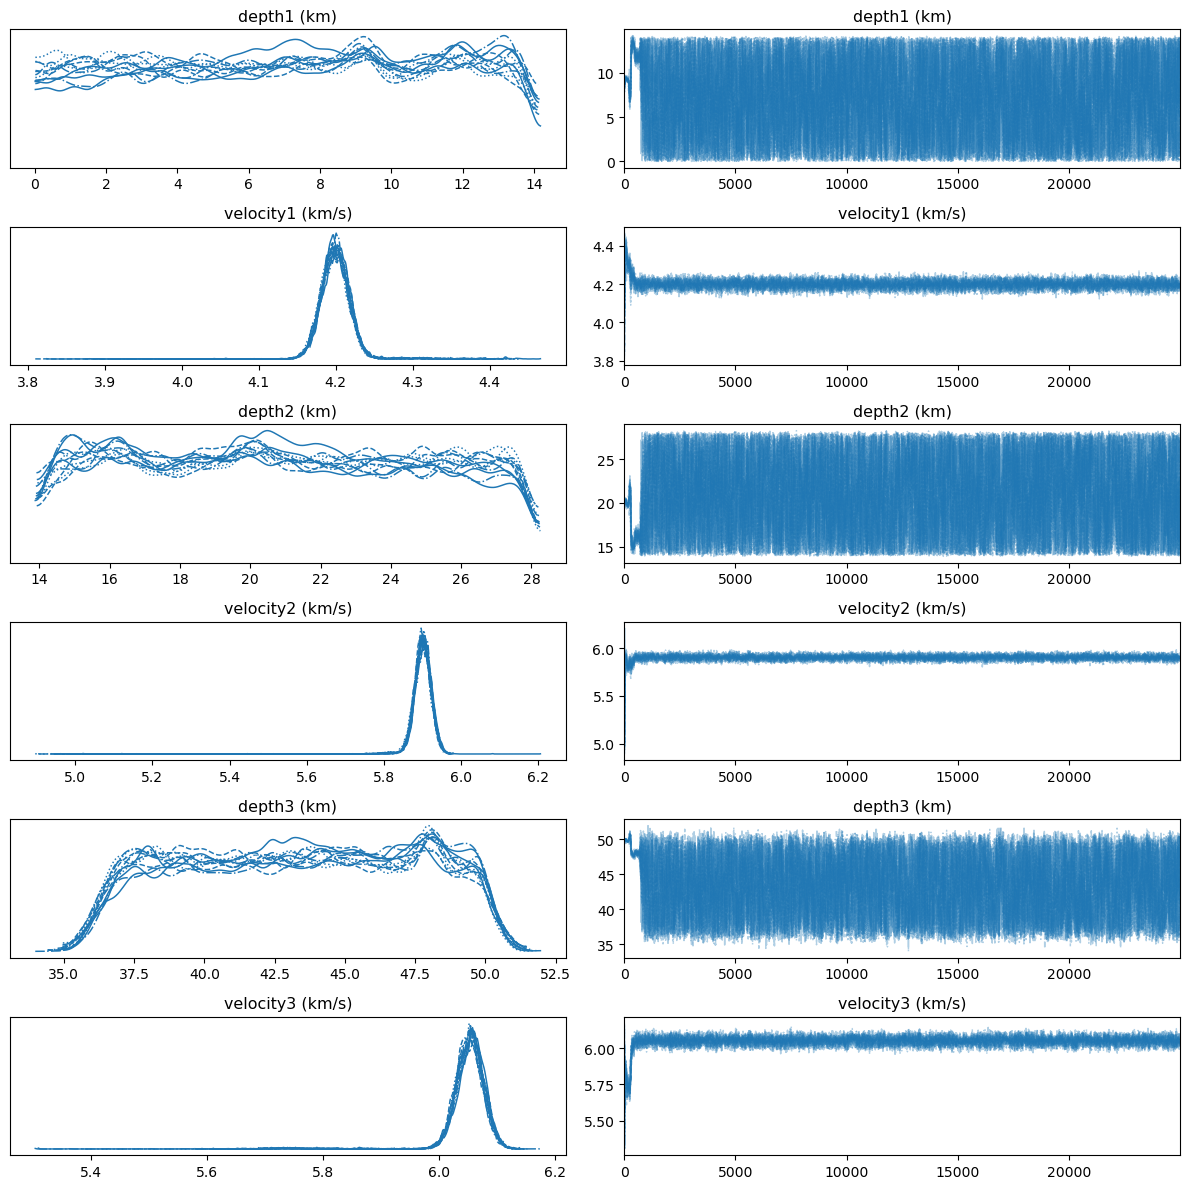

In [19]:
arviz.plot_trace(az_inf_data);
plt.tight_layout();

The walkers start in small distributions around some chosen values and then they quickly wander and start exploring the full posterior distribution. In fact, after a relatively small number of steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the integrated autocorrelation time (see Emcee's package the -[*Autocorrelation analysis & convergence tutorial*](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) for more details):

In [20]:
tau = inv_result_sampler.sampler.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [135.38823586 153.72316531 131.04308315 103.78555045 151.31468991
 241.05200227]


Let’s discard the initial 300 steps and make a corner plot:

Reference good model: [ 8.   4.2 20.   6.  45.   6.2]


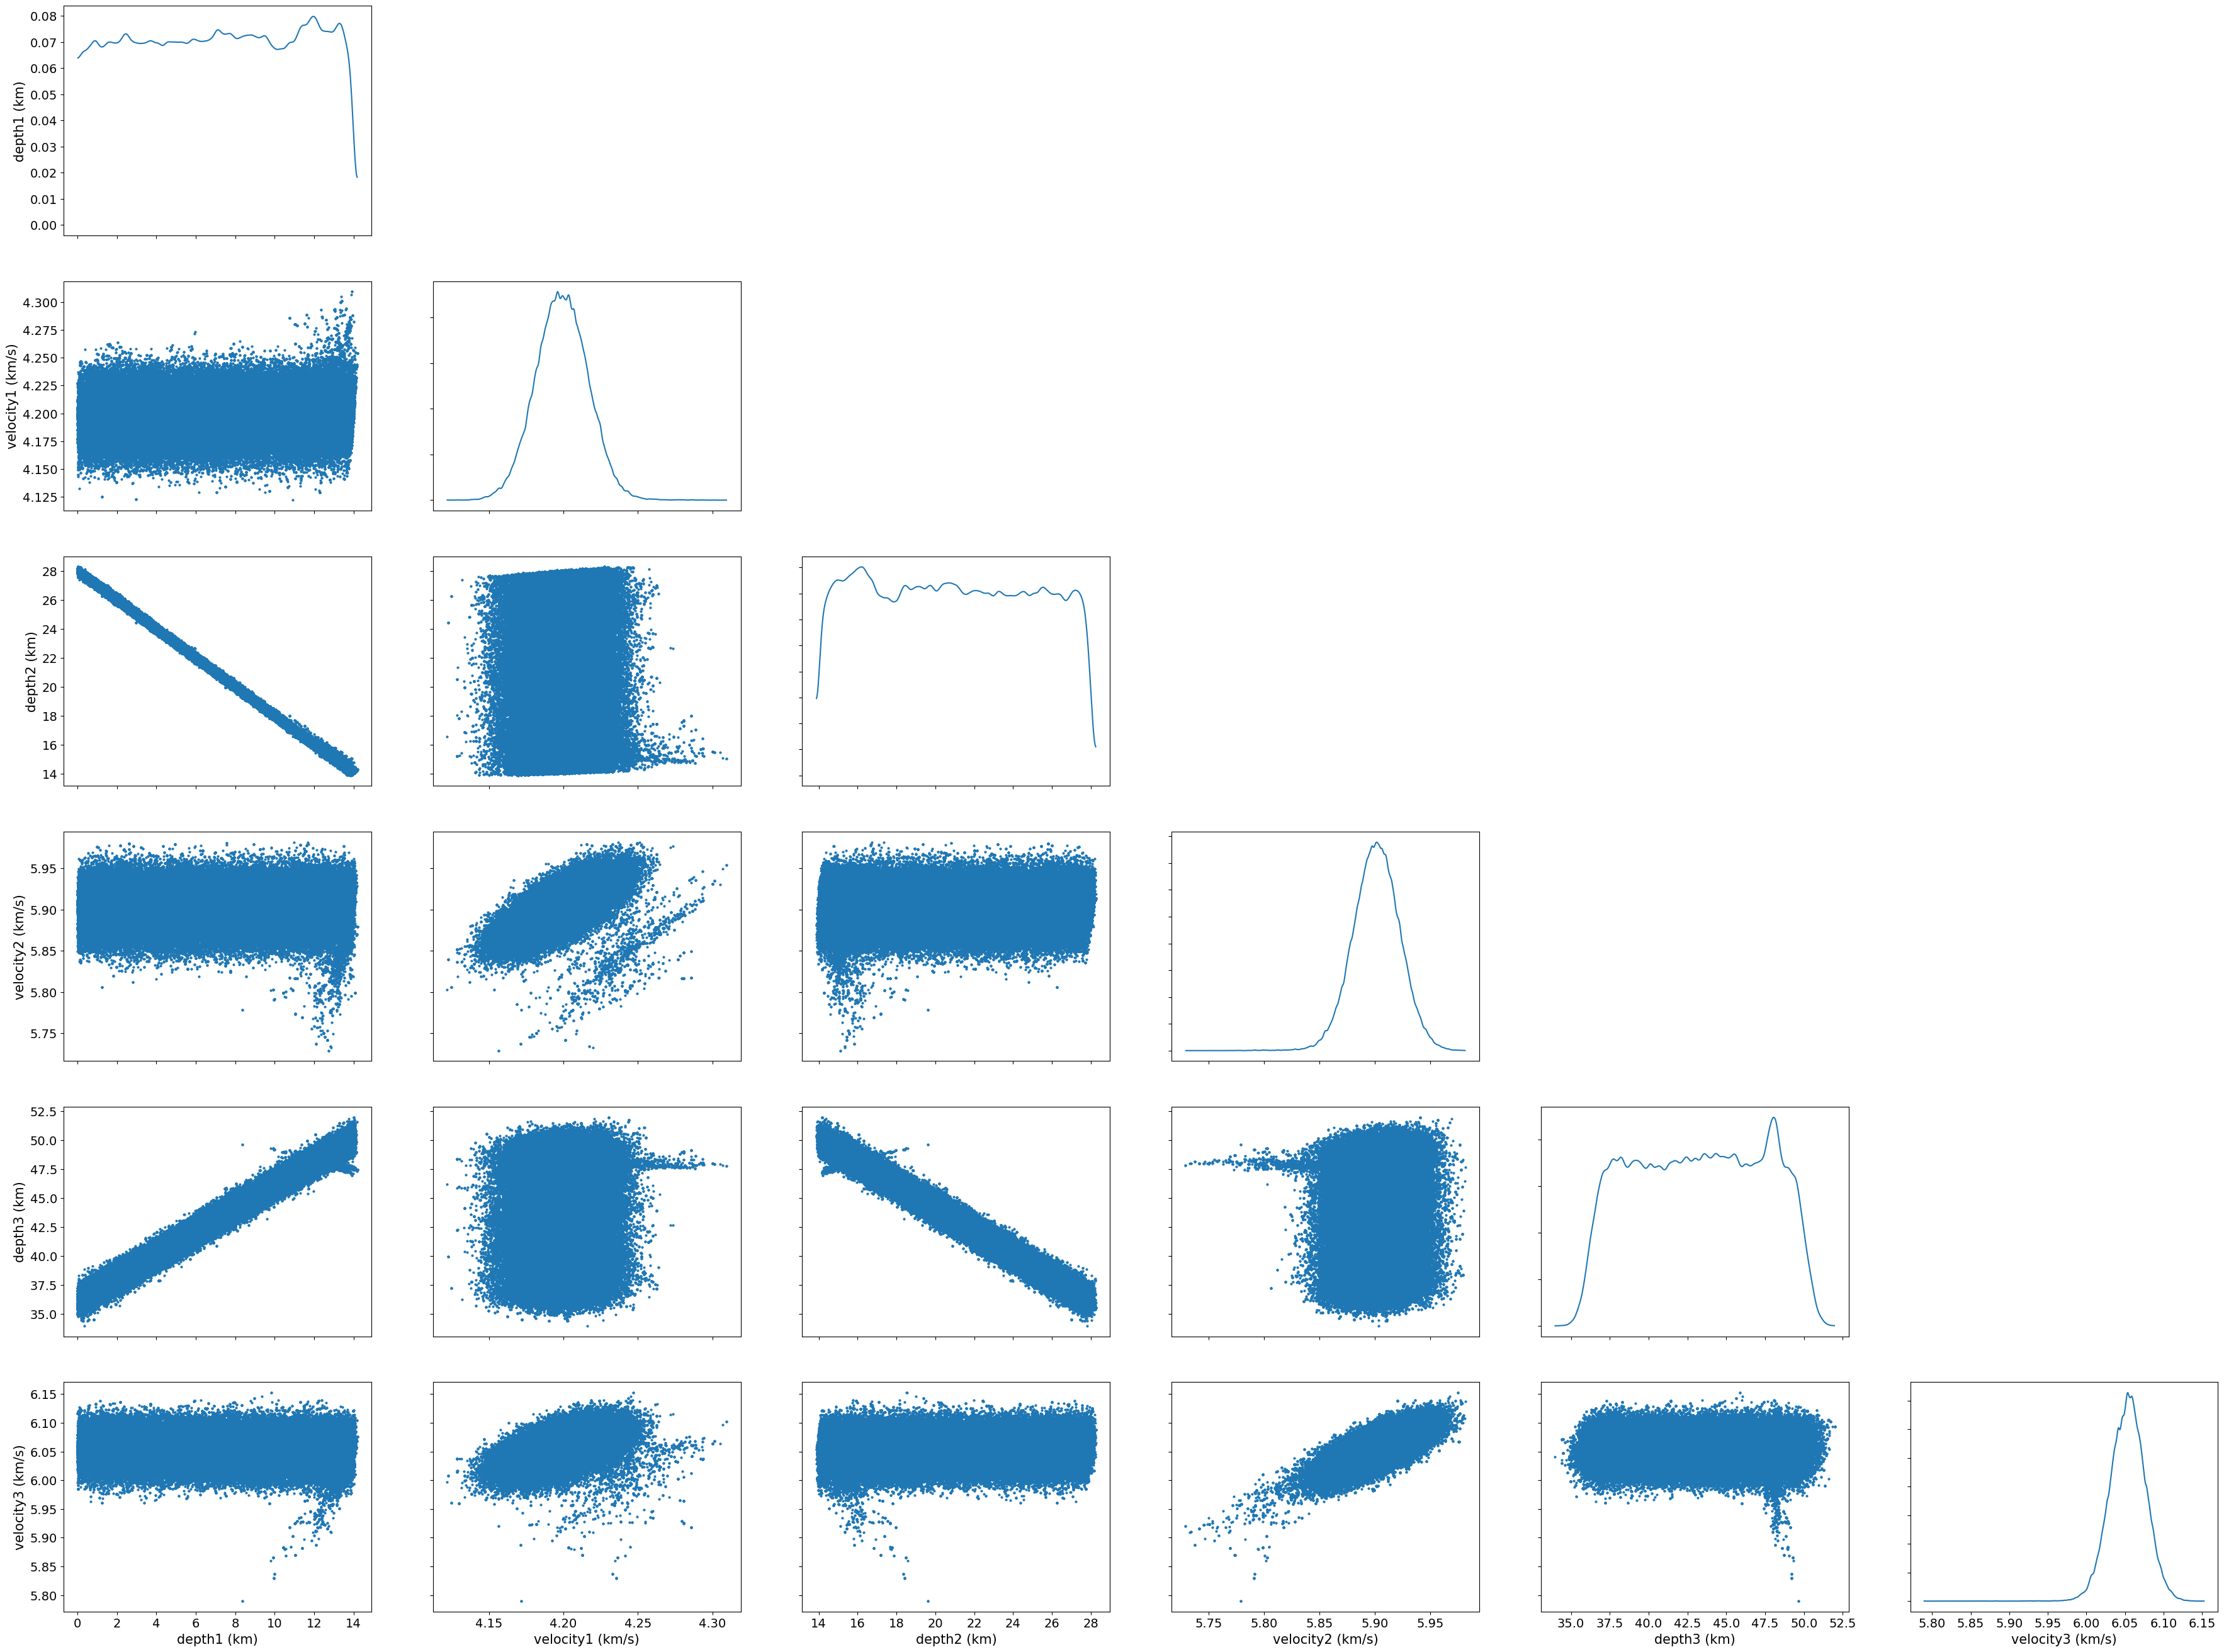

In [21]:
az_inf_data_after_300 = az_inf_data.sel(draw=slice(300,None))

arviz.plot_pair(
    az_inf_data_after_300, 
    marginals=True, 
)

print("Reference good model:", my_receiver_function.good_model)

Mean of samples:      [ 7.11534577  4.20008063 20.90613286  5.89967921 43.31460248  6.0499425 ]
Reference good model: [ 8.   4.2 20.   6.  45.   6.2]


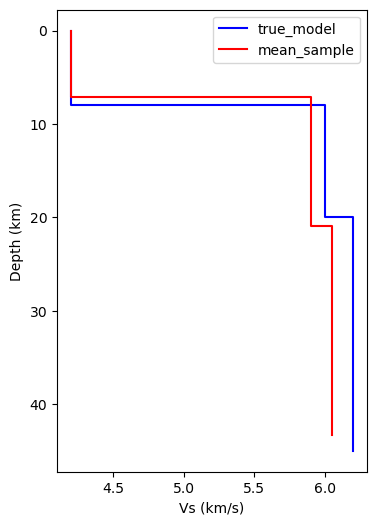

In [22]:
true_model = my_receiver_function.good_model
mean_sample = np.array(az_inf_data["posterior"].mean().to_array())
median_sample = np.array(az_inf_data["posterior"].median().to_array())

print("Mean of samples:     ", mean_sample)
print("Reference good model:", true_model)

my_receiver_function.plot_model(true_model, mean_sample, "true_model", "mean_sample")
plt.legend();

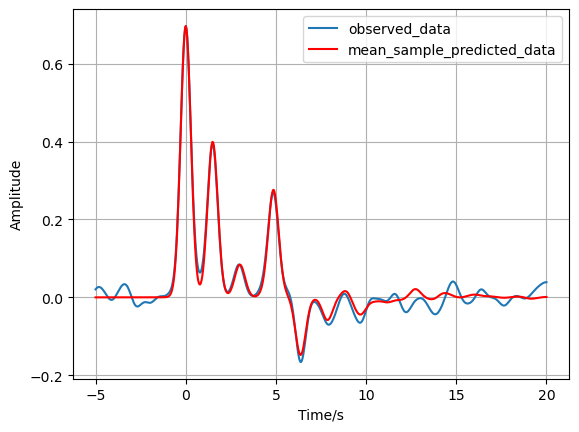

In [23]:
mean_sample_predicted_data = my_receiver_function.forward(mean_sample)
my_receiver_function.plot_data(
    observed_data, 
    mean_sample_predicted_data,
    "observed_data",
    "mean_sample_predicted_data",
);
plt.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [24]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.2
espresso 0.3.10
numpy 1.23.5
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
